> ### **OPTIMAL DATA RANGE**
---
*   ClipLimit: 2-3
*   Learning rate: 0.0001 < lr < 0.1
*   Batch size: 32, 64, 128
*   Dropout rate: 0,5 - 0,8
*   Weight: otomatis

> ### **STRUKTUR**
---

*   Optimizer: Adam
*   Activation function: ReLu (training), Softmax (final)
*   Pooling: _Max Pooling_
*   Kernel size: 130x242
*   Training/testing/validation: 70/10/20
*   Epoch: 30-65
*   Class: 7
*   Weight: ImageNet
*   Loss: Cross-Entropy

 ## **DATA PREPARATION**
---
menyiapkan data (termasuk penerapan image enhancement)

In [1]:
pip install -r "D:\00 Ardina\Model Skripsi\requirements.txt"

     ---------------------------------------- 38.2/38.2 MB 2.2 MB/s eta 0:00:00
     -------------------------------------- 47.0/47.0 kB 471.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 278.7/278.7 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydot: filename=pydot-1.2.3-py3-none-any.whl size=18942 sha256=ad9a32ff87f4e706ea66bac9a2f909c4cc20cd81cf23b97a4d5a796a0fe5f945
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\a8\0a\63\6ea0aa7a137559306d1c8886ac43d1f752c9fa90d45e1cbc7b
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24578 sha256=2b8886bab4765b9a06c8502fd944e664878de35c4f4ca0e06f8e7e7da96aa4c8
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\5c\94\1f\953aa60af58ef512e5256e538ff0772c340229e5996ac51

In [1]:
import os
import cv2
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
path = r"D:\UNAIR\Semester_8\Skripsi\deteksi_nominal_vending_machine\datasetUang"

kelas = os.listdir(path)
print("Daftar kelas = ",kelas,"\n\nBanyak kelas = ", len(kelas))
dataset = path

Daftar kelas =  ['1000', '10000', '100000', '2000', '20000', '5000', '50000'] 

Banyak kelas =  7


In [25]:
import splitfolders
splitfolders.ratio(dataset, output="datasetSplit", seed=1307, ratio=(0.7, 0.2, 0.1)) #70% : 10% : 20%

Copying files: 700 files [00:10, 63.86 files/s]


In [26]:
dataset = "datasetSplit"
#daftar_file(dataset)

In [3]:
import pandas as pd
import random
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [4]:
IMAGE_SIZE = (130, 242, 3)
dataset="datasetSplit"
train_pred_test_folders = os.listdir(dataset)
train_path = dataset+'/train'
test_path = dataset+'/test'
val_path = dataset+'/val'

Banyak citra di training set: 490
Banyak citra di testing set: 70
Banyak citra di prediction set: 140
Total citra: 700


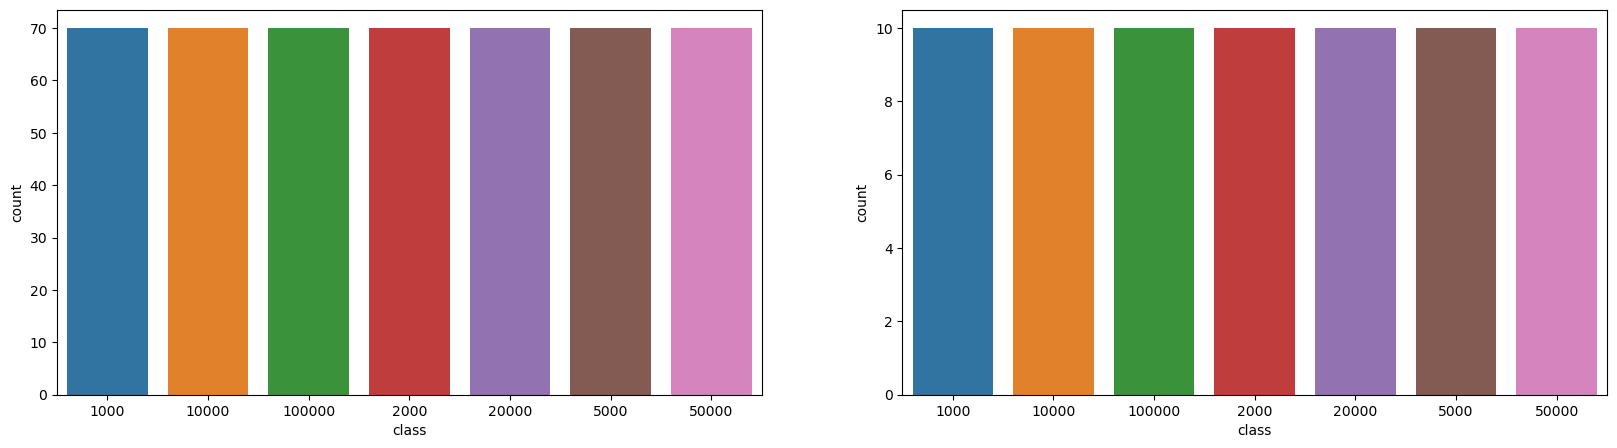

In [5]:
quantity_train = {} 
quantity_test = {}
quantity_val = {}
for folder in os.listdir(train_path):
    quantity_train[folder] = len(os.listdir(train_path+'/'+folder))

for folder in os.listdir(test_path):
    quantity_test[folder] = len(os.listdir(test_path+'/'+folder))

for folder in os.listdir(val_path):
    quantity_val[folder] = len(os.listdir(val_path+'/'+folder))

quantity_train = pd.DataFrame(list(quantity_train.items()), index=range(0,len(quantity_train)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_test.items()), index=range(0,len(quantity_test)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_val.items()), index=range(0,len(quantity_val)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Banyak citra di training set:", sum(quantity_train['count'].values))
print("Banyak citra di testing set:",sum(quantity_test['count'].values))
print("Banyak citra di prediction set:",sum(quantity_val['count'].values))
print("Total citra:",sum(quantity_train['count'].values)+sum(quantity_test['count'].values)+sum(quantity_val['count'].values))

plt.show()

In [6]:
def save_history(i, history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save ke json 
    hist_json_file = 'percobaan'+str(i)+'_noImgPro/'+model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save ke csv 
    hist_csv_file = 'percobaan'+str(i)+'_noImgPro/'+model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
  try:
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
  except TypeError:
    pass
    
def plot_loss_from_history(history):
  try:
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
  except TypeError:
    pass
    
def do_history_stuff(i, history, history_file_name, isinception=False):
    save_history(i, history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [7]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_path)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_path)):
        image_ids = os.listdir(os.path.join(train_path,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            display = plt.imread(os.path.join(train_path,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(vgg16_final_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

In [8]:
tf.keras.backend.clear_session()

In [9]:
import os
def savePercobaan(i):
  try: 
    os.mkdir("percobaan"+str(i)+"_noImgPro") 
  except OSError as error: 
    print(error)
  saveModel(i)

In [10]:
def saveModel(i):
  try: 
    os.mkdir("percobaan"+str(i)+"_noImgPro/model") 
  except OSError as error: 
    print(error)

 ## **VGG-16**
---
Visual Geometry Group (16 layers)

#### **<font color='Pink'>Data Generator</font>**

In [11]:
#normalisasi
train_datagen = ImageDataGenerator(rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
train_generator16 = train_datagen.flow_from_directory(train_path,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(130, 242))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

test_datagen = ImageDataGenerator(rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
test_generator16 = test_datagen.flow_from_directory(test_path, target_size=(130, 242),
    batch_size=1,
    shuffle=True,
    class_mode='categorical')

validation_generator16 = validation_datagen.flow_from_directory(val_path, shuffle=True, batch_size=1, class_mode='categorical', target_size=(130, 242))

Found 490 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [12]:
inv_map_classes = {v: k for k, v in validation_generator16.class_indices.items()}
#print(validation_generator16.class_indices)
print(inv_map_classes)

{0: '1000', 1: '10000', 2: '100000', 3: '2000', 4: '20000', 5: '5000', 6: '50000'}


#### **<font color='Pink'>Hyperparameter</font>**

In [13]:
import itertools
import random

array = [['ep1','ep2','ep3','ep4'], ['lr1', 'lr2', 'lr3', 'lr4'], [32, 64, 128], ['dr1', 'dr2', 'dr3', 'dr4']]

parameter = []
lr_values = array[1][1:]  

for _ in range(1):
    updated_array = [array[0], ['lr1'] + lr_values, array[2], array[3]]
    parameter.extend(list(itertools.product(*updated_array)))

parameter = [
    [
        random.randint(30, 38) if val == 'ep1' else
        random.randint(39, 47) if val == 'ep2' else
        random.randint(48, 56) if val == 'ep3' else
        random.randint(57, 65) if val == 'ep4' else

        random.uniform(0.0001, 0.0250249) if val == 'lr1' else
        random.uniform(0.025025, 0.050049) if val == 'lr2' else
        random.uniform(0.05005, 0.0750749) if val == 'lr3' else
        random.uniform(0.075075, 0.1) if val == 'lr4' else

        random.uniform(0.5,0.5749) if val == 'dr1' else
        random.uniform(0.575,0.649) if val == 'dr2' else
        random.uniform(0.65,0.7249) if val == 'dr3' else
        random.uniform(0.725,0.8) if val == 'dr4' else

        val
        for val in kombinasi
    ]
    for kombinasi in parameter
]

In [15]:
for kombinasi in parameter:
    print(kombinasi)

[36, 0.003373380751101915, 32, 0.5098543477601742]
[32, 0.005496665022592807, 32, 0.6080104487879617]
[36, 0.004662849646228612, 32, 0.687732078524114]
[34, 0.01190268897277744, 32, 0.7389753114194317]
[38, 0.015246180491445624, 64, 0.5057734648671738]
[33, 0.023653093933468625, 64, 0.5931168335537779]
[35, 0.020694432839000187, 64, 0.7035923844540974]
[33, 0.021363949619930322, 64, 0.743230126828475]
[30, 0.010782093337654343, 128, 0.5260731884539503]
[36, 0.016504344312570828, 128, 0.599890573697134]
[34, 0.0205449920354826, 128, 0.6915085113618809]
[36, 0.024881247532097524, 128, 0.77681798187871]
[38, 0.031015623475420754, 32, 0.5166230079897134]
[30, 0.03479498747505785, 32, 0.6257901546234617]
[34, 0.036836166087951774, 32, 0.7109004843910651]
[31, 0.0424535288047127, 32, 0.7535125881771295]
[36, 0.03962534179801804, 64, 0.5329734609067738]
[33, 0.038345107192264194, 64, 0.5785973290075381]
[38, 0.04555272952658948, 64, 0.6869451179212805]
[38, 0.03546295958438139, 64, 0.72720273

#### **<font color='Pink'>Model Training</font>**

In [14]:
from keras.layers import BatchNormalization
def vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate):
  vgg16_model = VGG16(pooling='max', weights='imagenet', include_top=False, input_shape=(130,242,3), classes=7) #defaultnya AVERAGE POOLING
  for layers in vgg16_model.layers:
              layers.trainable=False

  last_output_vgg16 = vgg16_model.layers[-1].output
  vgg_16 = Flatten()(last_output_vgg16) #awalnya di bawah last output
  vgg_16 = BatchNormalization()(vgg_16)
  vgg_16 = Dense(128, activation = 'relu')(vgg_16)
  vgg_16 = BatchNormalization()(vgg_16)
  vgg_16 = Dropout(dropout_rate)(vgg_16)

  #vgg_16 = Dense(64, activation = 'relu')(vgg_16)
  #vgg_16 = Dropout(dropout_rate)(vgg_16)
  vgg_16 = Dense(7, activation = 'softmax')(vgg_16)
  vgg16_final_model = Model(vgg16_model.input, vgg_16)
  
  opt = Adam(learning_rate=learning_rate)
  vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])
  #vgg16_final_model.summary()

  #plot_model(model=vgg16_final_model, show_shapes=True)

  train_generator16.batch_size = batch_size

  vgg16_filepath = 'percobaan'+str(i)+'_noImgPro/model/vgg_16_'+str(i)+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
  vgg16_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  vgg16_history = vgg16_final_model.fit(train_generator16, epochs = vgg_epoch, validation_data = validation_generator16,callbacks=[vgg16_checkpoint,early_stopping],verbose=1)

  do_history_stuff(i, vgg16_history, 'vgg16_model')
  save_vgg16(i, vgg16_final_model)

  predictionTest(i, vgg16_final_model)

  return(vgg16_final_model)

In [15]:
def save_vgg16(i, vgg16_final_model):
  vgg16_final_model.save(('percobaan'+str(i)+'_noImgPro/vgg16-model'+str(i)+'.h5'))

#### **<font color='Pink'>Evaluation</font>**

In [16]:
def acc_plot(vgg16_history):
  plt.figure(figsize=(10, 8))
  plt.plot(vgg16_history.history['acc'], label='train acc')
  plt.plot(vgg16_history.history['val_acc'], label='val acc')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

In [17]:
def loss_plot(vgg16_history):
  plt.figure(figsize=(10, 8))
  plt.plot(vgg16_history.history['loss'], label='train loss')
  plt.plot(vgg16_history.history['val_loss'], label='val loss')
  plt.legend()
  plt.title('Loss')
  plt.show()

In [18]:
def predictionTest(i, vgg16_final_model):
  true_value = []
  vgg_pred = []
  for folder in os.listdir(test_path):
      test_image_ids = os.listdir(os.path.join(test_path,folder))
      
      for image_id in test_image_ids[:int(len(test_image_ids))]:
          path = os.path.join(test_path,folder,image_id)
          #print(path)
          true_value.append(test_generator16.class_indices[folder])
          img = cv2.resize(cv2.imread(path),(242,130))
          img_normalized = img/255
          #vgg
          vgg16_image_prediction = np.argmax(vgg16_final_model.predict(np.array([img_normalized]), verbose = 0)) #verbose biar gak ngeprint
          vgg_pred.append(vgg16_image_prediction)

  print("\n")
  clf_report(i, true_value, vgg_pred)

In [19]:
arr_accuracy16 = []
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(k, true_value, model_pred):
    classes = validation_generator16.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    arr_accuracy16.append(model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    plt.savefig("percobaan"+str(k)+"_noImgPro/conf_matrix"+str(k)+".png")
    print(classification_report(true_value, model_pred, target_names = list(classes)))

In [20]:
hasilTabel = pd.DataFrame(columns=['Epoch', 'Learning Rate', 'Batch Size', 'Dropout Rate','Accuracy'])
print(hasilTabel)

Empty DataFrame
Columns: [Epoch, Learning Rate, Batch Size, Dropout Rate, Accuracy]
Index: []


#### **<font color='Pink'>Code Running</font>**

Percobaan ke- 98 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 56
learning rate: 0.024056461955002946
batch size: 32
dropout rate: 0.5844897179570151
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/56
16/16 [==============================] - ETA: 0s - loss: 2.4121 - acc: 0.3388
Epoch 1: val_acc improved from -inf to 0.29286, saving model to percobaan98_noImgPro/model\vgg_16_98-saved-model-01-acc-0.29.hdf5
16/16 [==============================] - 38s 2s/step - loss: 2.4121 - acc: 0.3388 - val_loss: 3.9458 - val_acc: 0.2929
Epoch 2/56
16/16 [==============================] - ETA: 0s - loss: 1.4294 - acc: 0.5000
Epoch 2: val_acc did not improve from 0.29286
16/16 [==============================] - 33s 2s/step - loss: 1.4294 - acc: 0.5000 - val_loss: 2.7370 - val_acc: 0.2786
Epoch 3/56
16/16 [==============================] - ETA: 0s - loss: 1.0796 - acc: 0.6429


C:\Users\ardin\AppData\Local\Temp\ipykernel_53828\2052248251.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


────────────────────────────────────────────────────────────────────────────────────────────────────


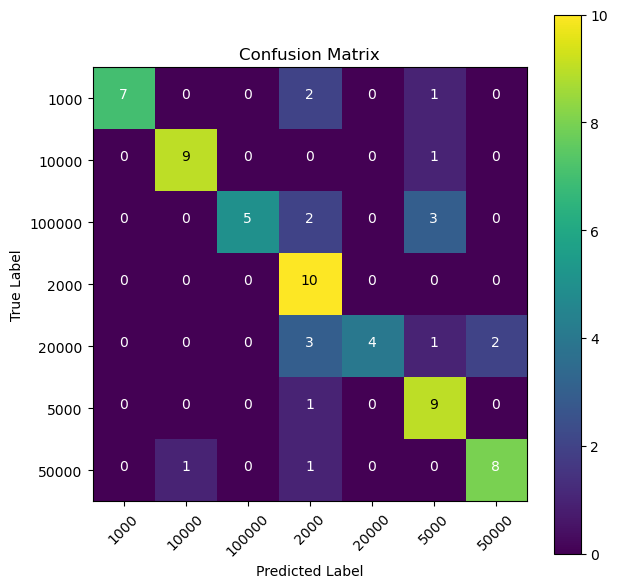

In [23]:
#run ulang percobaan 98
j = 97
for i in range (j,98):
  vgg_epoch = (parameter[i][0])
  learning_rate = (parameter[i][1])
  batch_size = (parameter[i][2])
  dropout_rate = (parameter[i][3])
  i=i+1
  savePercobaan(i)
  print("Percobaan ke-",i,"↓")
  print("HYPERPARAMETER".center(100,"─"))
  print("vgg epoch:",vgg_epoch)
  print("learning rate:",learning_rate)
  print("batch size:",batch_size)
  print("dropout rate:",dropout_rate)
  print("".center(100,"─"))
  vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate)
  new_row = {'Epoch': vgg_epoch, 'Learning Rate': learning_rate, 'Batch Size': batch_size,
             'Dropout Rate': dropout_rate, 'Accuracy': arr_accuracy16[-1]}
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)
  hasilTabel.index = hasilTabel.index + (j+1)
  hasilTabel.to_excel("hasilTabel.xlsx")
  print("".center(100,"─"))

In [ ]:
j = 0
for i in range (j,len(parameter)):
  vgg_epoch = (parameter[i][0])
  learning_rate = (parameter[i][1])
  batch_size = (parameter[i][2])
  dropout_rate = (parameter[i][3])
  i=i+1
  savePercobaan(i)
  print("Percobaan ke-",i,"↓")
  print("HYPERPARAMETER".center(100,"─"))
  print("vgg epoch:",vgg_epoch)
  print("learning rate:",learning_rate)
  print("batch size:",batch_size)
  print("dropout rate:",dropout_rate)
  print("".center(100,"─"))
  vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate)
  new_row = {'Epoch': vgg_epoch, 'Learning Rate': learning_rate, 'Batch Size': batch_size,
             'Dropout Rate': dropout_rate, 'Accuracy': arr_accuracy16[-1]}
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)
  hasilTabel.index = hasilTabel.index + (j+1)
  hasilTabel.to_excel("hasilTabel.xlsx")
  print("".center(100,"─"))

Percobaan ke- 1 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 32
learning rate: 0.02267326808914284
batch size: 32
dropout rate: 0.5748920853555588
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/32
16/16 [==============================] - ETA: 0s - loss: 2.4950 - acc: 0.3122
Epoch 1: val_acc improved from -inf to 0.25000, saving model to percobaan1_noImgPro/model\vgg_16_1-saved-model-01-acc-0.25.hdf5
16/16 [==============================] - 39s 2s/step - loss: 2.4950 - acc: 0.3122 - val_loss: 3.3581 - val_acc: 0.2500
Epoch 2/32
16/16 [==============================] - ETA: 0s - loss: 1.4351 - acc: 0.5327
Epoch 2: val_acc did not improve from 0.25000
16/16 [==============================] - 38s 2s/step - loss: 1.4351 - acc: 0.5327 - val_loss: 3.9602 - val_acc: 0.2000
Epoch 3/32
16/16 [==============================] - ETA: 0s - loss: 1.0583 - acc: 0.6082
Epoc

C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\940263153.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/31
16/16 [==============================] - ETA: 0s - loss: 2.3100 - acc: 0.3612
Epoch 1: val_acc improved from -inf to 0.22143, saving model to percobaan2_noImgPro/model\vgg_16_2-saved-model-01-acc-0.22.hdf5
16/16 [==============================] - 44s 3s/step - loss: 2.3100 - acc: 0.3612 - val_loss: 4.2895 - val_acc: 0.2214
Epoch 2/31
16/16 [==============================] - ETA: 0s - loss: 1.3600 - acc: 0.5245
Epoch 2: val_acc improved from 0.22143 to 0.25714, saving model to percobaan2_noImgPro/model\vgg_16_2-saved-model-02-acc-0.26.hdf5
16/16 [==============================] - 44s 3s/step - loss: 1.3600 - acc: 0.5245 - val_loss: 3.5285 - val_acc: 0.2571
Epoch 3/31
16/16 [==============================] - ETA: 0s - loss: 1.0417 - acc: 0.6408
Epoch 3: val_acc improved from 0.25714 to 0.29286, saving model to percobaan2_noImgPro/model\vgg_16_2-saved-model-03-acc-0.29.hdf5
16/16 [==============================] - 43s 3s/step - loss: 1.0417 - acc: 0.6408 - val_loss: 2.4304 - va

C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\940263153.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/31
16/16 [==============================] - ETA: 0s - loss: 3.4349 - acc: 0.1673
Epoch 1: val_acc improved from -inf to 0.15714, saving model to percobaan3_noImgPro/model\vgg_16_3-saved-model-01-acc-0.16.hdf5
16/16 [==============================] - 52s 3s/step - loss: 3.4349 - acc: 0.1673 - val_loss: 2.2222 - val_acc: 0.1571
Epoch 2/31
16/16 [==============================] - ETA: 0s - loss: 2.8505 - acc: 0.2204
Epoch 2: val_acc did not improve from 0.15714
16/16 [==============================] - 49s 3s/step - loss: 2.8505 - acc: 0.2204 - val_loss: 2.0327 - val_acc: 0.1571
Epoch 3/31
16/16 [==============================] - ETA: 0s - loss: 2.5479 - acc: 0.2837
Epoch 3: val_acc improved from 0.15714 to 0.19286, saving model to percobaan3_noImgPro/model\vgg_16_3-saved-model-03-acc-0.19.hdf5
16/16 [==============================] - 49s 3s/step - loss: 2.5479 - acc: 0.2837 - val_loss: 1.8834 - val_acc: 0.1929
Epoch 4/31
16/16 [==============================] - ETA: 0s - loss: 2.0

C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\940263153.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/31
16/16 [==============================] - ETA: 0s - loss: 3.5587 - acc: 0.1898
Epoch 1: val_acc improved from -inf to 0.15714, saving model to percobaan4_noImgPro/model\vgg_16_4-saved-model-01-acc-0.16.hdf5
16/16 [==============================] - 34s 2s/step - loss: 3.5587 - acc: 0.1898 - val_loss: 2.5197 - val_acc: 0.1571
Epoch 2/31
16/16 [==============================] - ETA: 0s - loss: 2.3049 - acc: 0.3714
Epoch 2: val_acc improved from 0.15714 to 0.18571, saving model to percobaan4_noImgPro/model\vgg_16_4-saved-model-02-acc-0.19.hdf5
16/16 [==============================] - 41s 2s/step - loss: 2.3049 - acc: 0.3714 - val_loss: 2.2676 - val_acc: 0.1857
Epoch 3/31
16/16 [==============================] - ETA: 0s - loss: 1.8361 - acc: 0.4490
Epoch 3: val_acc improved from 0.18571 to 0.31429, saving model to percobaan4_noImgPro/model\vgg_16_4-saved-model-03-acc-0.31.hdf5
16/16 [==============================] - 43s 2s/step - loss: 1.8361 - acc: 0.4490 - val_loss: 1.8831 - va

C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\940263153.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/31
8/8 [==============================] - ETA: 0s - loss: 2.1445 - acc: 0.3449
Epoch 1: val_acc improved from -inf to 0.23571, saving model to percobaan5_noImgPro/model\vgg_16_5-saved-model-01-acc-0.24.hdf5
8/8 [==============================] - 39s 5s/step - loss: 2.1445 - acc: 0.3449 - val_loss: 4.0885 - val_acc: 0.2357
Epoch 2/31
8/8 [==============================] - ETA: 0s - loss: 1.2509 - acc: 0.5878
Epoch 2: val_acc improved from 0.23571 to 0.32857, saving model to percobaan5_noImgPro/model\vgg_16_5-saved-model-02-acc-0.33.hdf5
8/8 [==============================] - 38s 5s/step - loss: 1.2509 - acc: 0.5878 - val_loss: 3.1191 - val_acc: 0.3286
Epoch 3/31
8/8 [==============================] - ETA: 0s - loss: 0.8238 - acc: 0.6980
Epoch 3: val_acc did not improve from 0.32857
8/8 [==============================] - 38s 5s/step - loss: 0.8238 - acc: 0.6980 - val_loss: 3.0508 - val_acc: 0.2357
Epoch 4/31
8/8 [==============================] - ETA: 0s - loss: 0.6456 - acc: 0.7

C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\940263153.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 2.5417 - acc: 0.3163
Epoch 1: val_acc improved from -inf to 0.25714, saving model to percobaan6_noImgPro/model\vgg_16_6-saved-model-01-acc-0.26.hdf5
8/8 [==============================] - 50s 6s/step - loss: 2.5417 - acc: 0.3163 - val_loss: 2.1425 - val_acc: 0.2571
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.1706 - acc: 0.6000
Epoch 2: val_acc improved from 0.25714 to 0.27857, saving model to percobaan6_noImgPro/model\vgg_16_6-saved-model-02-acc-0.28.hdf5
8/8 [==============================] - 72s 9s/step - loss: 1.1706 - acc: 0.6000 - val_loss: 2.1077 - val_acc: 0.2786
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.9568 - acc: 0.6653
Epoch 3: val_acc did not improve from 0.27857
8/8 [==============================] - 77s 10s/step - loss: 0.9568 - acc: 0.6653 - val_loss: 2.0970 - val_acc: 0.2714
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.7880 - acc: 0.

C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\940263153.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 7 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 31
learning rate: 0.012823036611208162
batch size: 64
dropout rate: 0.6952522796211565
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/31
8/8 [==============================] - ETA: 0s - loss: 2.6579 - acc: 0.2980
Epoch 1: val_acc improved from -inf to 0.20714, saving model to percobaan7_noImgPro/model\vgg_16_7-saved-model-01-acc-0.21.hdf5
8/8 [==============================] - 41s 5s/step - loss: 2.6579 - acc: 0.2980 - val_loss: 3.5181 - val_acc: 0.2071
Epoch 2/31
8/8 [==============================] - ETA: 0s - loss: 1.4786 - acc: 0.5184
Epoch 2: val_acc did not improve from 0.20714
8/8 [==============================] - 39s 5s/step - loss: 1.4786 - acc: 0.5184 - val_loss: 3.8721 - val_acc: 0.1714

C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\940263153.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/36
8/8 [==============================] - ETA: 0s - loss: 3.1501 - acc: 0.2408
Epoch 1: val_acc improved from -inf to 0.20714, saving model to percobaan8_noImgPro/model\vgg_16_8-saved-model-01-acc-0.21.hdf5
8/8 [==============================] - 40s 5s/step - loss: 3.1501 - acc: 0.2408 - val_loss: 3.2582 - val_acc: 0.2071
Epoch 2/36
8/8 [==============================] - ETA: 0s - loss: 1.9627 - acc: 0.4041
Epoch 2: val_acc did not improve from 0.20714
8/8 [==============================] - 38s 5s/step - loss: 1.9627 - acc: 0.4041 - val_loss: 4.8538 - val_acc: 0.1786
Epoch 3/36
8/8 [==============================] - ETA: 0s - loss: 1.7975 - acc: 0.4163
Epoch 3: val_acc did not improve from 0.20714
8/8 [==============================] - 38s 5s/step - loss: 1.7975 - acc: 0.4163 - val_loss: 3.4192 - val_acc: 0.1714
Epoch 4/36
8/8 [==============================] - ETA: 0s - loss: 1.4154 - acc: 0.4959
Epoch 4: val_acc improved from 0.20714 to 0.21429, saving model to percobaan8_noI

C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\940263153.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


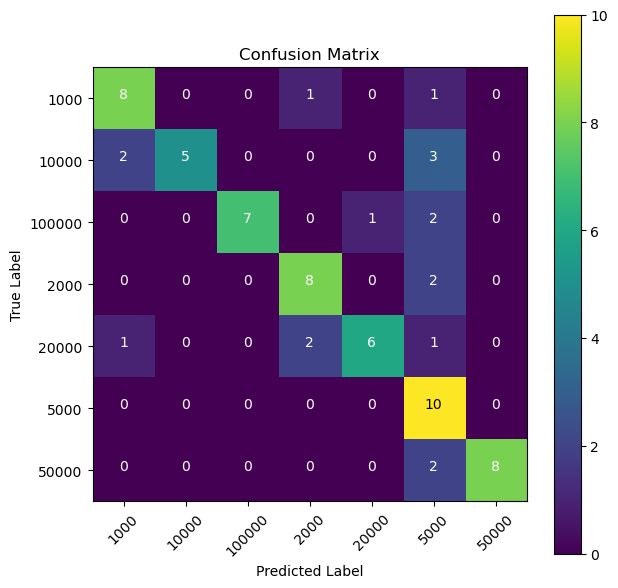

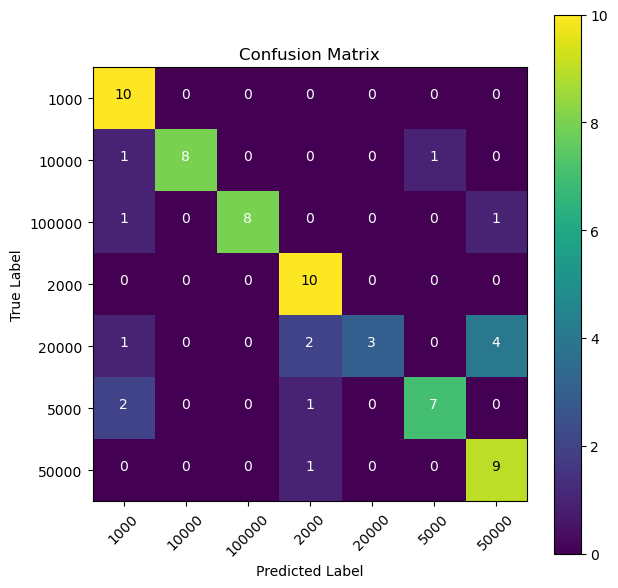

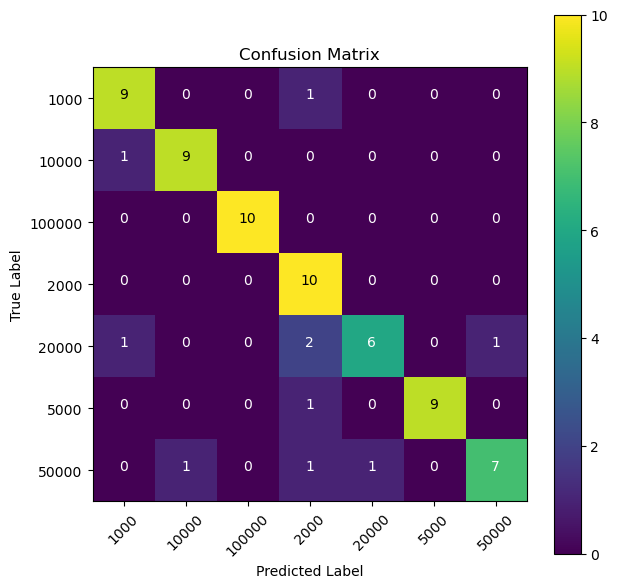

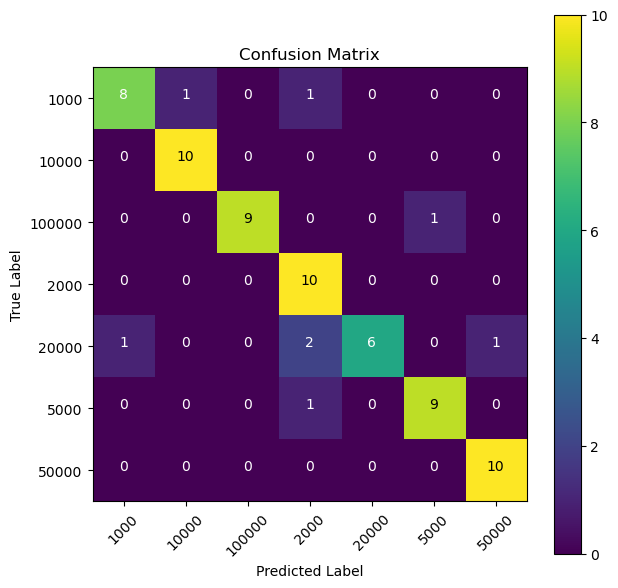

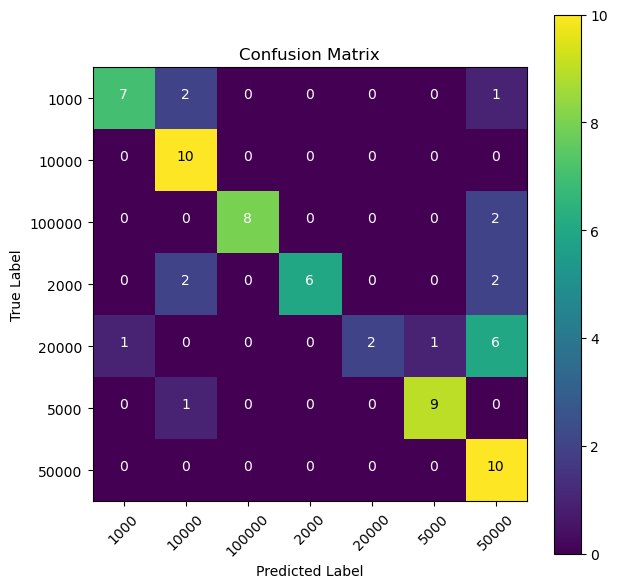

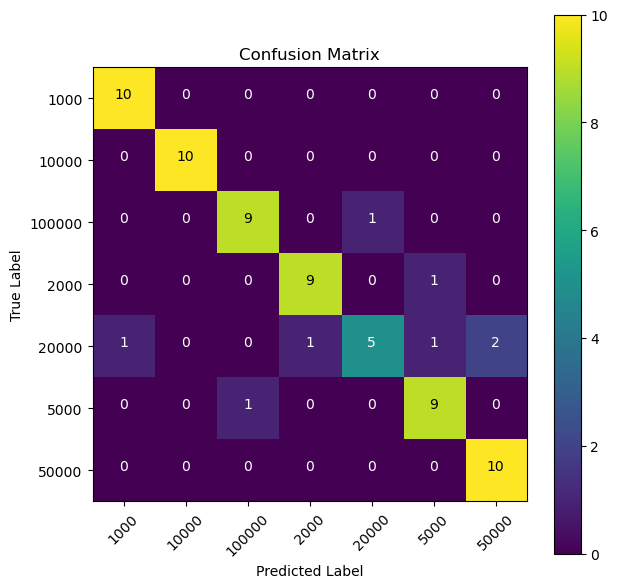

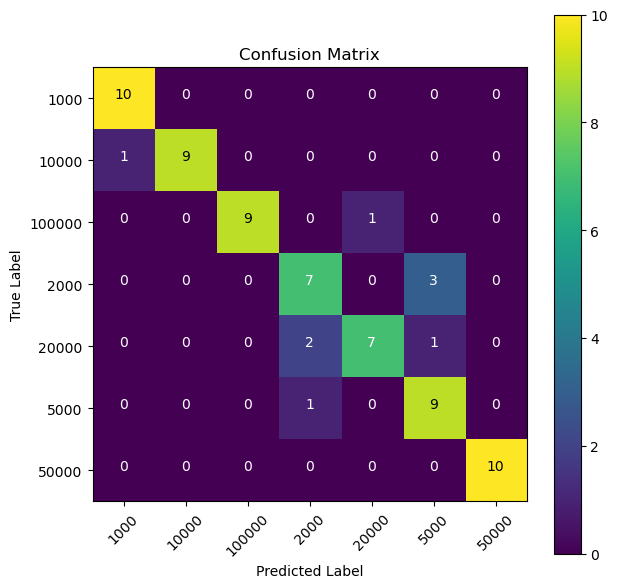

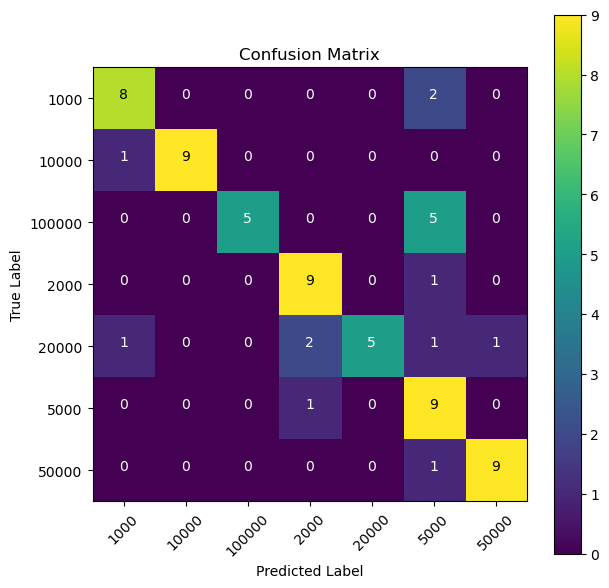

In [24]:
j = 0
for i in range (j,8):
#for i in range (0,10): #aslinya in range len(parameter) tapi kalau mau coba per sedikit2 ya gini deh
  vgg_epoch = (parameter[i][0])
  learning_rate = (parameter[i][1])
  batch_size = (parameter[i][2])
  dropout_rate = (parameter[i][3])
  i=i+1
  savePercobaan(i)
  print("Percobaan ke-",i,"↓")
  print("HYPERPARAMETER".center(100,"─"))
  print("vgg epoch:",vgg_epoch)
  print("learning rate:",learning_rate)
  print("batch size:",batch_size)
  print("dropout rate:",dropout_rate)
  print("".center(100,"─"))
  vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate)
  new_row = {'Epoch': vgg_epoch, 'Learning Rate': learning_rate, 'Batch Size': batch_size, 'Dropout Rate': dropout_rate, 'Accuracy': arr_accuracy16[-1]}
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)
  hasilTabel.index = hasilTabel.index + (j+1)
  hasilTabel.to_excel("hasilTabel.xlsx")
  print("".center(100,"─"))

In [23]:
j = 8
for i in range (j,len(parameter)):
#for i in range (0,10): #aslinya in range len(parameter) tapi kalau mau coba per sedikit2 ya gini deh
  vgg_epoch = (parameter[i][0])
  learning_rate = (parameter[i][1])
  batch_size = (parameter[i][2])
  dropout_rate = (parameter[i][3])
  i=i+1
  savePercobaan(i)
  print("Percobaan ke-",i,"↓")
  print("HYPERPARAMETER".center(100,"─"))
  print("vgg epoch:",vgg_epoch)
  print("learning rate:",learning_rate)
  print("batch size:",batch_size)
  print("dropout rate:",dropout_rate)
  print("".center(100,"─"))
  vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate)
  new_row = {'Epoch': vgg_epoch, 'Learning Rate': learning_rate, 'Batch Size': batch_size, 'Dropout Rate': dropout_rate, 'Accuracy': arr_accuracy16[-1]}
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)
  hasilTabel.index = hasilTabel.index + (j+1)
  hasilTabel.to_excel("hasilTabel.xlsx")
  print("".center(100,"─"))

Percobaan ke- 9 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 32
learning rate: 0.024096434180242803
batch size: 128
dropout rate: 0.5155662584872833
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/32
4/4 [==============================] - ETA: 0s - loss: 2.3052 - acc: 0.3286 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan9_noImgPro/model\vgg_16_9-saved-model-01-acc-0.14.hdf5
4/4 [==============================] - 75s 20s/step - loss: 2.3052 - acc: 0.3286 - val_loss: 5.7815 - val_acc: 0.1429
Epoch 2/32
4/4 [==============================] - ETA: 0s - loss: 1.1638 - acc: 0.6122 
Epoch 2: val_acc improved from 0.14286 to 0.18571, saving model to percobaan9_noImgPro/model\vgg_16_9-saved-model-02-acc-0.19.hdf5
4/4 [==============================] - 74s 19s/step - loss: 1.1638 - acc: 0.6122 - val_loss: 5.9001 - val_acc: 0.1857
Epoch 3/32

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.67      0.20      0.31        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.16      1.00      0.27        10
        5000       0.00      0.00      0.00        10
       50000       0.67      0.20      0.31        10

    accuracy                           0.20        70
   macro avg       0.21      0.20      0.13        70
weighted avg       0.21      0.20      0.13        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 10 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 35
learning rate: 0.0071169807105828185
batch size: 128
dropout rate: 0.6467938900729733
──────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/33
4/4 [==============================] - ETA: 0s - loss: 3.2461 - acc: 0.1510 
Epoch 1: val_acc improved from -inf to 0.16429, saving model to percobaan11_noImgPro/model\vgg_16_11-saved-model-01-acc-0.16.hdf5
4/4 [==============================] - 80s 21s/step - loss: 3.2461 - acc: 0.1510 - val_loss: 2.4452 - val_acc: 0.1643
Epoch 2/33
4/4 [==============================] - ETA: 0s - loss: 2.4056 - acc: 0.2939 
Epoch 2: val_acc improved from 0.16429 to 0.17143, saving model to percobaan11_noImgPro/model\vgg_16_11-saved-model-02-acc-0.17.hdf5
4/4 [==============================] - 79s 21s/step - loss: 2.4056 - acc: 0.2939 - val_loss: 2.5438 - val_acc: 0.1714
Epoch 3/33
4/4 [==============================] - ETA: 0s - loss: 2.0327 - acc: 0.3939 
Epoch 3: val_acc improved from 0.17143 to 0.17857, saving model to percobaan11_noImgPro/model\vgg_16_11-saved-model-03-acc-0.18.hdf5
4/4 [==============================] - 79s 22s/step - loss: 2.0327 - acc: 0.3939 - val_loss: 2.5073 - va

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/38
4/4 [==============================] - ETA: 0s - loss: 3.1390 - acc: 0.2347 
Epoch 1: val_acc improved from -inf to 0.32143, saving model to percobaan12_noImgPro/model\vgg_16_12-saved-model-01-acc-0.32.hdf5
4/4 [==============================] - 80s 22s/step - loss: 3.1390 - acc: 0.2347 - val_loss: 2.6825 - val_acc: 0.3214
Epoch 2/38
4/4 [==============================] - ETA: 0s - loss: 1.8887 - acc: 0.4204 
Epoch 2: val_acc improved from 0.32143 to 0.36429, saving model to percobaan12_noImgPro/model\vgg_16_12-saved-model-02-acc-0.36.hdf5
4/4 [==============================] - 79s 22s/step - loss: 1.8887 - acc: 0.4204 - val_loss: 2.4787 - val_acc: 0.3643
Epoch 3/38
4/4 [==============================] - ETA: 0s - loss: 1.4096 - acc: 0.4959 
Epoch 3: val_acc improved from 0.36429 to 0.41429, saving model to percobaan12_noImgPro/model\vgg_16_12-saved-model-03-acc-0.41.hdf5
4/4 [==============================] - 79s 21s/step - loss: 1.4096 - acc: 0.4959 - val_loss: 2.7327 - va

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 2.8832 - acc: 0.3082
Epoch 1: val_acc improved from -inf to 0.19286, saving model to percobaan13_noImgPro/model\vgg_16_13-saved-model-01-acc-0.19.hdf5
16/16 [==============================] - 77s 5s/step - loss: 2.8832 - acc: 0.3082 - val_loss: 6.3108 - val_acc: 0.1929
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 1.8099 - acc: 0.4755
Epoch 2: val_acc improved from 0.19286 to 0.31429, saving model to percobaan13_noImgPro/model\vgg_16_13-saved-model-02-acc-0.31.hdf5
16/16 [==============================] - 75s 5s/step - loss: 1.8099 - acc: 0.4755 - val_loss: 3.3989 - val_acc: 0.3143
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 1.3709 - acc: 0.5571
Epoch 3: val_acc did not improve from 0.31429
16/16 [==============================] - 75s 5s/step - loss: 1.3709 - acc: 0.5571 - val_loss: 2.0417 - val_acc: 0.2714
Epoch 4/30
16/16 [==============================] - ETA: 0s - loss:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/35
16/16 [==============================] - ETA: 0s - loss: 2.8537 - acc: 0.2653
Epoch 1: val_acc improved from -inf to 0.20714, saving model to percobaan14_noImgPro/model\vgg_16_14-saved-model-01-acc-0.21.hdf5
16/16 [==============================] - 75s 5s/step - loss: 2.8537 - acc: 0.2653 - val_loss: 4.4763 - val_acc: 0.2071
Epoch 2/35
16/16 [==============================] - ETA: 0s - loss: 1.8063 - acc: 0.4469
Epoch 2: val_acc improved from 0.20714 to 0.35000, saving model to percobaan14_noImgPro/model\vgg_16_14-saved-model-02-acc-0.35.hdf5
16/16 [==============================] - 75s 5s/step - loss: 1.8063 - acc: 0.4469 - val_loss: 2.1868 - val_acc: 0.3500
Epoch 3/35
16/16 [==============================] - ETA: 0s - loss: 1.4184 - acc: 0.5571
Epoch 3: val_acc did not improve from 0.35000
16/16 [==============================] - 75s 5s/step - loss: 1.4184 - acc: 0.5571 - val_loss: 2.5885 - val_acc: 0.2643
Epoch 4/35
16/16 [==============================] - ETA: 0s - loss:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/34
16/16 [==============================] - ETA: 0s - loss: 2.7426 - acc: 0.2714
Epoch 1: val_acc improved from -inf to 0.22143, saving model to percobaan15_noImgPro/model\vgg_16_15-saved-model-01-acc-0.22.hdf5
16/16 [==============================] - 76s 5s/step - loss: 2.7426 - acc: 0.2714 - val_loss: 6.5940 - val_acc: 0.2214
Epoch 2/34
16/16 [==============================] - ETA: 0s - loss: 1.8847 - acc: 0.4143
Epoch 2: val_acc improved from 0.22143 to 0.23571, saving model to percobaan15_noImgPro/model\vgg_16_15-saved-model-02-acc-0.24.hdf5
16/16 [==============================] - 75s 5s/step - loss: 1.8847 - acc: 0.4143 - val_loss: 4.2643 - val_acc: 0.2357
Epoch 3/34
16/16 [==============================] - ETA: 0s - loss: 1.3738 - acc: 0.5347
Epoch 3: val_acc improved from 0.23571 to 0.30000, saving model to percobaan15_noImgPro/model\vgg_16_15-saved-model-03-acc-0.30.hdf5
16/16 [==============================] - 74s 5s/step - loss: 1.3738 - acc: 0.5347 - val_loss: 2.324

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/37
16/16 [==============================] - ETA: 0s - loss: 3.1379 - acc: 0.2327
Epoch 1: val_acc improved from -inf to 0.19286, saving model to percobaan16_noImgPro/model\vgg_16_16-saved-model-01-acc-0.19.hdf5
16/16 [==============================] - 81s 5s/step - loss: 3.1379 - acc: 0.2327 - val_loss: 6.0471 - val_acc: 0.1929
Epoch 2/37
16/16 [==============================] - ETA: 0s - loss: 2.0591 - acc: 0.3796
Epoch 2: val_acc improved from 0.19286 to 0.26429, saving model to percobaan16_noImgPro/model\vgg_16_16-saved-model-02-acc-0.26.hdf5
16/16 [==============================] - 78s 5s/step - loss: 2.0591 - acc: 0.3796 - val_loss: 4.1387 - val_acc: 0.2643
Epoch 3/37
16/16 [==============================] - ETA: 0s - loss: 1.6866 - acc: 0.4510
Epoch 3: val_acc did not improve from 0.26429
16/16 [==============================] - 78s 5s/step - loss: 1.6866 - acc: 0.4510 - val_loss: 3.2344 - val_acc: 0.2214
Epoch 4/37
16/16 [==============================] - ETA: 0s - loss:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/36
8/8 [==============================] - ETA: 0s - loss: 2.3439 - acc: 0.3735
Epoch 1: val_acc improved from -inf to 0.22857, saving model to percobaan17_noImgPro/model\vgg_16_17-saved-model-01-acc-0.23.hdf5
8/8 [==============================] - 73s 9s/step - loss: 2.3439 - acc: 0.3735 - val_loss: 4.3006 - val_acc: 0.2286
Epoch 2/36
8/8 [==============================] - ETA: 0s - loss: 1.1668 - acc: 0.5939
Epoch 2: val_acc improved from 0.22857 to 0.31429, saving model to percobaan17_noImgPro/model\vgg_16_17-saved-model-02-acc-0.31.hdf5
8/8 [==============================] - 73s 9s/step - loss: 1.1668 - acc: 0.5939 - val_loss: 4.2674 - val_acc: 0.3143
Epoch 3/36
8/8 [==============================] - ETA: 0s - loss: 1.0322 - acc: 0.6347
Epoch 3: val_acc improved from 0.31429 to 0.33571, saving model to percobaan17_noImgPro/model\vgg_16_17-saved-model-03-acc-0.34.hdf5
8/8 [==============================] - 73s 9s/step - loss: 1.0322 - acc: 0.6347 - val_loss: 2.8691 - val_acc:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/33
8/8 [==============================] - ETA: 0s - loss: 2.2972 - acc: 0.3429
Epoch 1: val_acc improved from -inf to 0.17857, saving model to percobaan18_noImgPro/model\vgg_16_18-saved-model-01-acc-0.18.hdf5
8/8 [==============================] - 70s 9s/step - loss: 2.2972 - acc: 0.3429 - val_loss: 8.3109 - val_acc: 0.1786
Epoch 2/33
8/8 [==============================] - ETA: 0s - loss: 1.4309 - acc: 0.5286
Epoch 2: val_acc improved from 0.17857 to 0.21429, saving model to percobaan18_noImgPro/model\vgg_16_18-saved-model-02-acc-0.21.hdf5
8/8 [==============================] - 69s 9s/step - loss: 1.4309 - acc: 0.5286 - val_loss: 7.8088 - val_acc: 0.2143
Epoch 3/33
8/8 [==============================] - ETA: 0s - loss: 1.0866 - acc: 0.6286
Epoch 3: val_acc improved from 0.21429 to 0.22143, saving model to percobaan18_noImgPro/model\vgg_16_18-saved-model-03-acc-0.22.hdf5
8/8 [==============================] - 69s 9s/step - loss: 1.0866 - acc: 0.6286 - val_loss: 6.6012 - val_acc:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/32
8/8 [==============================] - ETA: 0s - loss: 3.0111 - acc: 0.2633
Epoch 1: val_acc improved from -inf to 0.25714, saving model to percobaan19_noImgPro/model\vgg_16_19-saved-model-01-acc-0.26.hdf5
8/8 [==============================] - 78s 10s/step - loss: 3.0111 - acc: 0.2633 - val_loss: 6.5781 - val_acc: 0.2571
Epoch 2/32
8/8 [==============================] - ETA: 0s - loss: 2.2288 - acc: 0.3673
Epoch 2: val_acc improved from 0.25714 to 0.27143, saving model to percobaan19_noImgPro/model\vgg_16_19-saved-model-02-acc-0.27.hdf5
8/8 [==============================] - 77s 10s/step - loss: 2.2288 - acc: 0.3673 - val_loss: 5.0959 - val_acc: 0.2714
Epoch 3/32
8/8 [==============================] - ETA: 0s - loss: 1.7248 - acc: 0.4408
Epoch 3: val_acc improved from 0.27143 to 0.42143, saving model to percobaan19_noImgPro/model\vgg_16_19-saved-model-03-acc-0.42.hdf5
8/8 [==============================] - 77s 10s/step - loss: 1.7248 - acc: 0.4408 - val_loss: 2.0299 - val_a

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.80      0.40      0.53        10
       10000       0.70      0.70      0.70        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.40      0.57        10
       20000       0.50      0.10      0.17        10
        5000       0.38      1.00      0.56        10
       50000       0.43      1.00      0.61        10

    accuracy                           0.51        70
   macro avg       0.55      0.51      0.45        70
weighted avg       0.55      0.51      0.45        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 20 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 30
learning rate: 0.04755848726110507
batch size: 64
dropout rate: 0.7734304230040852
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/32
4/4 [==============================] - ETA: 0s - loss: 2.3079 - acc: 0.3510 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan21_noImgPro/model\vgg_16_21-saved-model-01-acc-0.14.hdf5
4/4 [==============================] - 87s 24s/step - loss: 2.3079 - acc: 0.3510 - val_loss: 8.2195 - val_acc: 0.1429
Epoch 2/32
4/4 [==============================] - ETA: 0s - loss: 1.2725 - acc: 0.5551 
Epoch 2: val_acc improved from 0.14286 to 0.32857, saving model to percobaan21_noImgPro/model\vgg_16_21-saved-model-02-acc-0.33.hdf5
4/4 [==============================] - 85s 22s/step - loss: 1.2725 - acc: 0.5551 - val_loss: 3.9490 - val_acc: 0.3286
Epoch 3/32
4/4 [==============================] - ETA: 0s - loss: 0.9624 - acc: 0.6592 
Epoch 3: val_acc did not improve from 0.32857
4/4 [==============================] - 86s 23s/step - loss: 0.9624 - acc: 0.6592 - val_loss: 7.7078 - val_acc: 0.1571
Epoch 4/32
4/4 [==============================] - ETA: 0s - loss: 0.8351 

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.16      1.00      0.27        10
        5000       0.00      0.00      0.00        10
       50000       0.17      0.10      0.12        10

    accuracy                           0.16        70
   macro avg       0.05      0.16      0.06        70
weighted avg       0.05      0.16      0.06        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 22 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 30
learning rate: 0.03341344754006047
batch size: 128
dropout rate: 0.6409141666625097
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.30      0.46        10
       10000       0.00      0.00      0.00        10
      100000       1.00      0.10      0.18        10
        2000       0.00      0.00      0.00        10
       20000       0.21      0.90      0.35        10
        5000       0.00      0.00      0.00        10
       50000       0.38      0.90      0.53        10

    accuracy                           0.31        70
   macro avg       0.37      0.31      0.22        70
weighted avg       0.37      0.31      0.22        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 23 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 30
learning rate: 0.03475828415470619
batch size: 128
dropout rate: 0.655559140376386
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.80      0.40      0.53        10
       10000       1.00      0.10      0.18        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.16      1.00      0.28        10
        5000       0.00      0.00      0.00        10
       50000       1.00      0.20      0.33        10

    accuracy                           0.24        70
   macro avg       0.42      0.24      0.19        70
weighted avg       0.42      0.24      0.19        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 24 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 37
learning rate: 0.045757894416961285
batch size: 128
dropout rate: 0.7887693764347964
───────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.40      0.57        10
       10000       0.56      1.00      0.71        10
      100000       0.00      0.00      0.00        10
        2000       0.67      0.40      0.50        10
       20000       0.57      0.40      0.47        10
        5000       0.60      0.60      0.60        10
       50000       0.40      1.00      0.57        10

    accuracy                           0.54        70
   macro avg       0.54      0.54      0.49        70
weighted avg       0.54      0.54      0.49        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 25 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 37
learning rate: 0.05827483055439125
batch size: 32
dropout rate: 0.5015267677516464
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/38
16/16 [==============================] - ETA: 0s - loss: 3.7654 - acc: 0.2327
Epoch 1: val_acc improved from -inf to 0.27857, saving model to percobaan26_noImgPro/model\vgg_16_26-saved-model-01-acc-0.28.hdf5
16/16 [==============================] - 82s 5s/step - loss: 3.7654 - acc: 0.2327 - val_loss: 6.3996 - val_acc: 0.2786
Epoch 2/38
16/16 [==============================] - ETA: 0s - loss: 2.4807 - acc: 0.3469
Epoch 2: val_acc improved from 0.27857 to 0.30714, saving model to percobaan26_noImgPro/model\vgg_16_26-saved-model-02-acc-0.31.hdf5
16/16 [==============================] - 82s 5s/step - loss: 2.4807 - acc: 0.3469 - val_loss: 1.7650 - val_acc: 0.3071
Epoch 3/38
16/16 [==============================] - ETA: 0s - loss: 1.8380 - acc: 0.3959
Epoch 3: val_acc improved from 0.30714 to 0.37857, saving model to percobaan26_noImgPro/model\vgg_16_26-saved-model-03-acc-0.38.hdf5
16/16 [==============================] - 82s 5s/step - loss: 1.8380 - acc: 0.3959 - val_loss: 1.695

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       0.00      0.00      0.00        10
      100000       1.00      0.10      0.18        10
        2000       0.18      1.00      0.31        10
       20000       0.00      0.00      0.00        10
        5000       1.00      0.10      0.18        10
       50000       0.70      0.70      0.70        10

    accuracy                           0.30        70
   macro avg       0.55      0.30      0.24        70
weighted avg       0.55      0.30      0.24        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 27 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 33
learning rate: 0.051464393031196
batch size: 32
dropout rate: 0.7143158810350841
───────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/38
16/16 [==============================] - ETA: 0s - loss: 4.0687 - acc: 0.2490
Epoch 1: val_acc improved from -inf to 0.35000, saving model to percobaan28_noImgPro/model\vgg_16_28-saved-model-01-acc-0.35.hdf5
16/16 [==============================] - 76s 5s/step - loss: 4.0687 - acc: 0.2490 - val_loss: 3.9937 - val_acc: 0.3500
Epoch 2/38
16/16 [==============================] - ETA: 0s - loss: 2.9521 - acc: 0.2837
Epoch 2: val_acc did not improve from 0.35000
16/16 [==============================] - 76s 5s/step - loss: 2.9521 - acc: 0.2837 - val_loss: 2.5060 - val_acc: 0.3143
Epoch 3/38
16/16 [==============================] - ETA: 0s - loss: 2.0784 - acc: 0.3306
Epoch 3: val_acc improved from 0.35000 to 0.35714, saving model to percobaan28_noImgPro/model\vgg_16_28-saved-model-03-acc-0.36.hdf5
16/16 [==============================] - 76s 5s/step - loss: 2.0784 - acc: 0.3306 - val_loss: 1.7166 - val_acc: 0.3571
Epoch 4/38
16/16 [==============================] - ETA: 0s - loss:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/32
8/8 [==============================] - ETA: 0s - loss: 2.9343 - acc: 0.2592
Epoch 1: val_acc improved from -inf to 0.15000, saving model to percobaan29_noImgPro/model\vgg_16_29-saved-model-01-acc-0.15.hdf5
8/8 [==============================] - 77s 10s/step - loss: 2.9343 - acc: 0.2592 - val_loss: 16.1075 - val_acc: 0.1500
Epoch 2/32
8/8 [==============================] - ETA: 0s - loss: 1.7636 - acc: 0.4673
Epoch 2: val_acc improved from 0.15000 to 0.33571, saving model to percobaan29_noImgPro/model\vgg_16_29-saved-model-02-acc-0.34.hdf5
8/8 [==============================] - 77s 10s/step - loss: 1.7636 - acc: 0.4673 - val_loss: 5.7817 - val_acc: 0.3357
Epoch 3/32
8/8 [==============================] - ETA: 0s - loss: 1.2053 - acc: 0.6184
Epoch 3: val_acc did not improve from 0.33571
8/8 [==============================] - 78s 10s/step - loss: 1.2053 - acc: 0.6184 - val_loss: 5.7200 - val_acc: 0.2714
Epoch 4/32
8/8 [==============================] - ETA: 0s - loss: 0.9995 - 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\2095710237.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,7))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       0.58      0.70      0.64        10
      100000       0.00      0.00      0.00        10
        2000       0.50      0.30      0.37        10
       20000       1.00      0.10      0.18        10
        5000       0.00      0.00      0.00        10
       50000       0.20      1.00      0.34        10

    accuracy                           0.33        70
   macro avg       0.47      0.33      0.27        70
weighted avg       0.47      0.33      0.27        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 30 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 32
learning rate: 0.052514880469720165
batch size: 64
dropout rate: 0.5772702507998597
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/33
8/8 [==============================] - ETA: 0s - loss: 3.2389 - acc: 0.2531
Epoch 1: val_acc improved from -inf to 0.22857, saving model to percobaan31_noImgPro/model\vgg_16_31-saved-model-01-acc-0.23.hdf5
8/8 [==============================] - 76s 10s/step - loss: 3.2389 - acc: 0.2531 - val_loss: 7.9996 - val_acc: 0.2286
Epoch 2/33
8/8 [==============================] - ETA: 0s - loss: 2.3242 - acc: 0.3816
Epoch 2: val_acc did not improve from 0.22857
8/8 [==============================] - 79s 10s/step - loss: 2.3242 - acc: 0.3816 - val_loss: 3.2221 - val_acc: 0.2143
Epoch 3/33
8/8 [==============================] - ETA: 0s - loss: 1.7486 - acc: 0.4327
Epoch 3: val_acc did not improve from 0.22857
8/8 [==============================] - 76s 10s/step - loss: 1.7486 - acc: 0.4327 - val_loss: 4.0706 - val_acc: 0.2214
Epoch 4/33
8/8 [==============================] - ETA: 0s - loss: 1.4788 - acc: 0.4980
Epoch 4: val_acc improved from 0.22857 to 0.40000, saving model to percobaan

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.60      0.60      0.60        10
      100000       1.00      0.10      0.18        10
        2000       0.50      0.70      0.58        10
       20000       0.25      0.90      0.39        10
        5000       0.00      0.00      0.00        10
       50000       0.89      0.80      0.84        10

    accuracy                           0.44        70
   macro avg       0.46      0.44      0.37        70
weighted avg       0.46      0.44      0.37        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 32 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 31
learning rate: 0.06224209044328398
batch size: 64
dropout rate: 0.738134795482572
──────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.60      0.30      0.40        10
       10000       1.00      0.20      0.33        10
      100000       0.00      0.00      0.00        10
        2000       0.75      0.30      0.43        10
       20000       0.25      0.10      0.14        10
        5000       0.67      0.20      0.31        10
       50000       0.19      1.00      0.32        10

    accuracy                           0.30        70
   macro avg       0.49      0.30      0.28        70
weighted avg       0.49      0.30      0.28        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 33 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 33
learning rate: 0.05149635710961387
batch size: 128
dropout rate: 0.5702717226932095
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.38      0.90      0.53        10
       10000       0.37      1.00      0.54        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.38      0.60      0.46        10
        5000       1.00      0.10      0.18        10
       50000       1.00      0.20      0.33        10

    accuracy                           0.40        70
   macro avg       0.45      0.40      0.29        70
weighted avg       0.45      0.40      0.29        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 34 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 36
learning rate: 0.06264392145702406
batch size: 128
dropout rate: 0.5982631681504014
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.50      0.20      0.29        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.16      1.00      0.27        10

    accuracy                           0.17        70
   macro avg       0.09      0.17      0.08        70
weighted avg       0.09      0.17      0.08        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 35 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 35
learning rate: 0.06393342505698188
batch size: 128
dropout rate: 0.6523359949511304
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.67      0.40      0.50        10
       10000       0.24      1.00      0.39        10
      100000       0.00      0.00      0.00        10
        2000       0.60      0.30      0.40        10
       20000       0.00      0.00      0.00        10
        5000       0.62      0.50      0.56        10
       50000       0.70      0.70      0.70        10

    accuracy                           0.41        70
   macro avg       0.41      0.41      0.36        70
weighted avg       0.41      0.41      0.36        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 36 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 35
learning rate: 0.07478640809020295
batch size: 128
dropout rate: 0.758477513278394
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.40      0.57        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.18      1.00      0.30        10
        5000       0.00      0.00      0.00        10
       50000       0.50      0.40      0.44        10

    accuracy                           0.26        70
   macro avg       0.24      0.26      0.19        70
weighted avg       0.24      0.26      0.19        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 37 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 33
learning rate: 0.08456574177123914
batch size: 32
dropout rate: 0.5637037390571091
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/36
16/16 [==============================] - ETA: 0s - loss: 3.3158 - acc: 0.2959
Epoch 1: val_acc improved from -inf to 0.22857, saving model to percobaan38_noImgPro/model\vgg_16_38-saved-model-01-acc-0.23.hdf5
16/16 [==============================] - 79s 5s/step - loss: 3.3158 - acc: 0.2959 - val_loss: 9.4339 - val_acc: 0.2286
Epoch 2/36
16/16 [==============================] - ETA: 0s - loss: 2.2204 - acc: 0.4245
Epoch 2: val_acc did not improve from 0.22857
16/16 [==============================] - 77s 5s/step - loss: 2.2204 - acc: 0.4245 - val_loss: 4.4518 - val_acc: 0.1643
Epoch 3/36
16/16 [==============================] - ETA: 0s - loss: 1.8204 - acc: 0.4490
Epoch 3: val_acc did not improve from 0.22857
16/16 [==============================] - 78s 5s/step - loss: 1.8204 - acc: 0.4490 - val_loss: 3.3408 - val_acc: 0.2143
Epoch 4/36
16/16 [==============================] - ETA: 0s - loss: 1.2885 - acc: 0.5735
Epoch 4: val_acc improved from 0.22857 to 0.27857, saving model t

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.78      0.70      0.74        10
       10000       1.00      0.40      0.57        10
      100000       1.00      0.30      0.46        10
        2000       0.64      0.70      0.67        10
       20000       0.00      0.00      0.00        10
        5000       0.38      1.00      0.56        10
       50000       0.53      0.90      0.67        10

    accuracy                           0.57        70
   macro avg       0.62      0.57      0.52        70
weighted avg       0.62      0.57      0.52        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 39 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 31
learning rate: 0.09493047751101746
batch size: 32
dropout rate: 0.7162267192082791
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.00      0.00      0.00        10
      100000       0.53      1.00      0.69        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.28      0.80      0.41        10
       50000       0.47      0.90      0.62        10

    accuracy                           0.40        70
   macro avg       0.33      0.40      0.27        70
weighted avg       0.33      0.40      0.27        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 40 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 38
learning rate: 0.09262727628166398
batch size: 32
dropout rate: 0.79723846300863
───────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.14      1.00      0.25        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.14        70
   macro avg       0.02      0.14      0.04        70
weighted avg       0.02      0.14      0.04        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 41 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 32
learning rate: 0.09341545875707691
batch size: 64
dropout rate: 0.54414579916867
───────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.82      0.90      0.86        10
       10000       1.00      0.80      0.89        10
      100000       0.00      0.00      0.00        10
        2000       0.64      0.90      0.75        10
       20000       0.00      0.00      0.00        10
        5000       0.59      1.00      0.74        10
       50000       0.45      0.90      0.60        10

    accuracy                           0.64        70
   macro avg       0.50      0.64      0.55        70
weighted avg       0.50      0.64      0.55        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 42 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 33
learning rate: 0.08357986191640457
batch size: 64
dropout rate: 0.6178940993264393
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.88      0.70      0.78        10
       10000       1.00      0.60      0.75        10
      100000       1.00      0.10      0.18        10
        2000       1.00      0.10      0.18        10
       20000       0.00      0.00      0.00        10
        5000       0.36      1.00      0.53        10
       50000       0.38      1.00      0.56        10

    accuracy                           0.50        70
   macro avg       0.66      0.50      0.42        70
weighted avg       0.66      0.50      0.42        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 43 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 35
learning rate: 0.08801821117022995
batch size: 64
dropout rate: 0.6837065126645538
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.80      0.40      0.53        10
       10000       1.00      0.30      0.46        10
      100000       0.00      0.00      0.00        10
        2000       0.44      0.70      0.54        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.22      1.00      0.36        10

    accuracy                           0.34        70
   macro avg       0.35      0.34      0.27        70
weighted avg       0.35      0.34      0.27        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 44 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 34
learning rate: 0.08502832751877068
batch size: 64
dropout rate: 0.7557551130442524
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.60      0.75        10
       10000       0.24      1.00      0.38        10
      100000       0.00      0.00      0.00        10
        2000       0.67      0.60      0.63        10
       20000       0.60      0.60      0.60        10
        5000       0.00      0.00      0.00        10
       50000       1.00      0.30      0.46        10

    accuracy                           0.44        70
   macro avg       0.50      0.44      0.40        70
weighted avg       0.50      0.44      0.40        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 45 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 35
learning rate: 0.086017275135224
batch size: 128
dropout rate: 0.5441284754498331
──────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.70      0.82        10
       10000       1.00      0.90      0.95        10
      100000       0.00      0.00      0.00        10
        2000       0.67      1.00      0.80        10
       20000       0.75      0.60      0.67        10
        5000       0.56      1.00      0.71        10
       50000       0.62      0.80      0.70        10

    accuracy                           0.71        70
   macro avg       0.66      0.71      0.66        70
weighted avg       0.66      0.71      0.66        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 46 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 37
learning rate: 0.07845587489952437
batch size: 128
dropout rate: 0.6446680957669143
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       1.00      0.20      0.33        10
      100000       0.00      0.00      0.00        10
        2000       0.38      0.60      0.46        10
       20000       0.00      0.00      0.00        10
        5000       1.00      0.20      0.33        10
       50000       0.21      1.00      0.34        10

    accuracy                           0.31        70
   macro avg       0.51      0.31      0.26        70
weighted avg       0.51      0.31      0.26        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 47 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 33
learning rate: 0.09356215504020778
batch size: 128
dropout rate: 0.6581876155822749
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.17      0.90      0.29        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.41      0.70      0.52        10

    accuracy                           0.23        70
   macro avg       0.08      0.23      0.11        70
weighted avg       0.08      0.23      0.11        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 48 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 33
learning rate: 0.09477885747205307
batch size: 128
dropout rate: 0.765374298742985
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/40
16/16 [==============================] - ETA: 0s - loss: 2.2005 - acc: 0.3571
Epoch 1: val_acc improved from -inf to 0.22143, saving model to percobaan49_noImgPro/model\vgg_16_49-saved-model-01-acc-0.22.hdf5
16/16 [==============================] - 82s 5s/step - loss: 2.2005 - acc: 0.3571 - val_loss: 2.6643 - val_acc: 0.2214
Epoch 2/40
16/16 [==============================] - ETA: 0s - loss: 1.0928 - acc: 0.6204
Epoch 2: val_acc improved from 0.22143 to 0.23571, saving model to percobaan49_noImgPro/model\vgg_16_49-saved-model-02-acc-0.24.hdf5
16/16 [==============================] - 79s 5s/step - loss: 1.0928 - acc: 0.6204 - val_loss: 2.3389 - val_acc: 0.2357
Epoch 3/40
16/16 [==============================] - ETA: 0s - loss: 0.8150 - acc: 0.7000
Epoch 3: val_acc improved from 0.23571 to 0.42143, saving model to percobaan49_noImgPro/model\vgg_16_49-saved-model-03-acc-0.42.hdf5
16/16 [==============================] - 80s 5s/step - loss: 0.8150 - acc: 0.7000 - val_loss: 1.656

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/45
16/16 [==============================] - ETA: 0s - loss: 2.4726 - acc: 0.3000
Epoch 1: val_acc improved from -inf to 0.18571, saving model to percobaan50_noImgPro/model\vgg_16_50-saved-model-01-acc-0.19.hdf5
16/16 [==============================] - 85s 5s/step - loss: 2.4726 - acc: 0.3000 - val_loss: 2.2891 - val_acc: 0.1857
Epoch 2/45
16/16 [==============================] - ETA: 0s - loss: 1.5176 - acc: 0.5265
Epoch 2: val_acc improved from 0.18571 to 0.27143, saving model to percobaan50_noImgPro/model\vgg_16_50-saved-model-02-acc-0.27.hdf5
16/16 [==============================] - 83s 5s/step - loss: 1.5176 - acc: 0.5265 - val_loss: 2.0564 - val_acc: 0.2714
Epoch 3/45
16/16 [==============================] - ETA: 0s - loss: 1.0992 - acc: 0.6204
Epoch 3: val_acc improved from 0.27143 to 0.47857, saving model to percobaan50_noImgPro/model\vgg_16_50-saved-model-03-acc-0.48.hdf5
16/16 [==============================] - 83s 5s/step - loss: 1.0992 - acc: 0.6204 - val_loss: 1.593

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/42
16/16 [==============================] - ETA: 0s - loss: 2.8308 - acc: 0.2980
Epoch 1: val_acc improved from -inf to 0.30000, saving model to percobaan51_noImgPro/model\vgg_16_51-saved-model-01-acc-0.30.hdf5
16/16 [==============================] - 84s 5s/step - loss: 2.8308 - acc: 0.2980 - val_loss: 2.6987 - val_acc: 0.3000
Epoch 2/42
16/16 [==============================] - ETA: 0s - loss: 1.6391 - acc: 0.4531
Epoch 2: val_acc improved from 0.30000 to 0.35000, saving model to percobaan51_noImgPro/model\vgg_16_51-saved-model-02-acc-0.35.hdf5
16/16 [==============================] - 82s 5s/step - loss: 1.6391 - acc: 0.4531 - val_loss: 2.3572 - val_acc: 0.3500
Epoch 3/42
16/16 [==============================] - ETA: 0s - loss: 1.2555 - acc: 0.5918
Epoch 3: val_acc did not improve from 0.35000
16/16 [==============================] - 82s 5s/step - loss: 1.2555 - acc: 0.5918 - val_loss: 2.2720 - val_acc: 0.2429
Epoch 4/42
16/16 [==============================] - ETA: 0s - loss:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/43
16/16 [==============================] - ETA: 0s - loss: 2.8122 - acc: 0.2714
Epoch 1: val_acc improved from -inf to 0.20714, saving model to percobaan52_noImgPro/model\vgg_16_52-saved-model-01-acc-0.21.hdf5
16/16 [==============================] - 83s 5s/step - loss: 2.8122 - acc: 0.2714 - val_loss: 2.8152 - val_acc: 0.2071
Epoch 2/43
16/16 [==============================] - ETA: 0s - loss: 2.0589 - acc: 0.4041
Epoch 2: val_acc improved from 0.20714 to 0.35000, saving model to percobaan52_noImgPro/model\vgg_16_52-saved-model-02-acc-0.35.hdf5
16/16 [==============================] - 81s 5s/step - loss: 2.0589 - acc: 0.4041 - val_loss: 2.1099 - val_acc: 0.3500
Epoch 3/43
16/16 [==============================] - ETA: 0s - loss: 1.5890 - acc: 0.4857
Epoch 3: val_acc improved from 0.35000 to 0.48571, saving model to percobaan52_noImgPro/model\vgg_16_52-saved-model-03-acc-0.49.hdf5
16/16 [==============================] - 81s 5s/step - loss: 1.5890 - acc: 0.4857 - val_loss: 1.316

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/47
8/8 [==============================] - ETA: 0s - loss: 2.4626 - acc: 0.3347
Epoch 1: val_acc improved from -inf to 0.19286, saving model to percobaan53_noImgPro/model\vgg_16_53-saved-model-01-acc-0.19.hdf5
8/8 [==============================] - 82s 10s/step - loss: 2.4626 - acc: 0.3347 - val_loss: 4.1532 - val_acc: 0.1929
Epoch 2/47
8/8 [==============================] - ETA: 0s - loss: 1.2487 - acc: 0.5531
Epoch 2: val_acc improved from 0.19286 to 0.20714, saving model to percobaan53_noImgPro/model\vgg_16_53-saved-model-02-acc-0.21.hdf5
8/8 [==============================] - 80s 10s/step - loss: 1.2487 - acc: 0.5531 - val_loss: 4.3500 - val_acc: 0.2071
Epoch 3/47
8/8 [==============================] - ETA: 0s - loss: 0.7805 - acc: 0.7327
Epoch 3: val_acc did not improve from 0.20714
8/8 [==============================] - 80s 10s/step - loss: 0.7805 - acc: 0.7327 - val_loss: 4.9615 - val_acc: 0.1857
Epoch 4/47
8/8 [==============================] - ETA: 0s - loss: 0.6993 - a

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/45
8/8 [==============================] - ETA: 0s - loss: 2.3799 - acc: 0.3469
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan54_noImgPro/model\vgg_16_54-saved-model-01-acc-0.14.hdf5
8/8 [==============================] - 81s 10s/step - loss: 2.3799 - acc: 0.3469 - val_loss: 7.6465 - val_acc: 0.1429
Epoch 2/45
8/8 [==============================] - ETA: 0s - loss: 1.5761 - acc: 0.4980
Epoch 2: val_acc did not improve from 0.14286
8/8 [==============================] - 79s 10s/step - loss: 1.5761 - acc: 0.4980 - val_loss: 7.7545 - val_acc: 0.1429
Epoch 3/45
8/8 [==============================] - ETA: 0s - loss: 1.1358 - acc: 0.5857
Epoch 3: val_acc improved from 0.14286 to 0.16429, saving model to percobaan54_noImgPro/model\vgg_16_54-saved-model-03-acc-0.16.hdf5
8/8 [==============================] - 79s 11s/step - loss: 1.1358 - acc: 0.5857 - val_loss: 6.5852 - val_acc: 0.1643
Epoch 4/45
8/8 [==============================] - ETA: 0s - loss: 0.8804 - a

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.86      0.60      0.71        10
       10000       0.89      0.80      0.84        10
      100000       1.00      0.50      0.67        10
        2000       0.75      0.60      0.67        10
       20000       0.00      0.00      0.00        10
        5000       1.00      0.50      0.67        10
       50000       0.28      1.00      0.43        10

    accuracy                           0.57        70
   macro avg       0.68      0.57      0.57        70
weighted avg       0.68      0.57      0.57        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 55 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 41
learning rate: 0.006729553818609509
batch size: 64
dropout rate: 0.6962827005674291
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/45
8/8 [==============================] - ETA: 0s - loss: 3.4286 - acc: 0.2286
Epoch 1: val_acc improved from -inf to 0.24286, saving model to percobaan56_noImgPro/model\vgg_16_56-saved-model-01-acc-0.24.hdf5
8/8 [==============================] - 85s 11s/step - loss: 3.4286 - acc: 0.2286 - val_loss: 2.7561 - val_acc: 0.2429
Epoch 2/45
8/8 [==============================] - ETA: 0s - loss: 2.2585 - acc: 0.3592
Epoch 2: val_acc did not improve from 0.24286
8/8 [==============================] - 83s 11s/step - loss: 2.2585 - acc: 0.3592 - val_loss: 2.8330 - val_acc: 0.2429
Epoch 3/45
8/8 [==============================] - ETA: 0s - loss: 1.7196 - acc: 0.4327
Epoch 3: val_acc did not improve from 0.24286
8/8 [==============================] - 84s 11s/step - loss: 1.7196 - acc: 0.4327 - val_loss: 2.4114 - val_acc: 0.1857
Epoch 4/45
8/8 [==============================] - ETA: 0s - loss: 1.5333 - acc: 0.4796
Epoch 4: val_acc improved from 0.24286 to 0.31429, saving model to percobaan

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/39
4/4 [==============================] - ETA: 0s - loss: 2.5222 - acc: 0.2694 
Epoch 1: val_acc improved from -inf to 0.20000, saving model to percobaan57_noImgPro/model\vgg_16_57-saved-model-01-acc-0.20.hdf5
4/4 [==============================] - 84s 22s/step - loss: 2.5222 - acc: 0.2694 - val_loss: 2.3259 - val_acc: 0.2000
Epoch 2/39
4/4 [==============================] - ETA: 0s - loss: 1.4085 - acc: 0.5102 
Epoch 2: val_acc improved from 0.20000 to 0.22857, saving model to percobaan57_noImgPro/model\vgg_16_57-saved-model-02-acc-0.23.hdf5
4/4 [==============================] - 83s 22s/step - loss: 1.4085 - acc: 0.5102 - val_loss: 2.1836 - val_acc: 0.2286
Epoch 3/39
4/4 [==============================] - ETA: 0s - loss: 0.8763 - acc: 0.7020 
Epoch 3: val_acc improved from 0.22857 to 0.24286, saving model to percobaan57_noImgPro/model\vgg_16_57-saved-model-03-acc-0.24.hdf5
4/4 [==============================] - 82s 23s/step - loss: 0.8763 - acc: 0.7020 - val_loss: 2.0224 - va

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/40
4/4 [==============================] - ETA: 0s - loss: 2.6934 - acc: 0.3020 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan58_noImgPro/model\vgg_16_58-saved-model-01-acc-0.14.hdf5
4/4 [==============================] - 84s 22s/step - loss: 2.6934 - acc: 0.3020 - val_loss: 3.5216 - val_acc: 0.1429
Epoch 2/40
4/4 [==============================] - ETA: 0s - loss: 1.5034 - acc: 0.5122 
Epoch 2: val_acc did not improve from 0.14286
4/4 [==============================] - 82s 22s/step - loss: 1.5034 - acc: 0.5122 - val_loss: 4.7036 - val_acc: 0.1429
Epoch 3/40
4/4 [==============================] - ETA: 0s - loss: 0.9953 - acc: 0.6510 
Epoch 3: val_acc improved from 0.14286 to 0.17857, saving model to percobaan58_noImgPro/model\vgg_16_58-saved-model-03-acc-0.18.hdf5
4/4 [==============================] - 82s 22s/step - loss: 0.9953 - acc: 0.6510 - val_loss: 4.6416 - val_acc: 0.1786
Epoch 4/40
4/4 [==============================] - ETA: 0s - loss: 0.8174 

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.14      1.00      0.25        10
        5000       0.00      0.00      0.00        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.14        70
   macro avg       0.02      0.14      0.04        70
weighted avg       0.02      0.14      0.04        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 59 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 39
learning rate: 0.011381522511268167
batch size: 128
dropout rate: 0.6673745779355464
───────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/47
4/4 [==============================] - ETA: 0s - loss: 3.0912 - acc: 0.2796 
Epoch 1: val_acc improved from -inf to 0.20000, saving model to percobaan60_noImgPro/model\vgg_16_60-saved-model-01-acc-0.20.hdf5
4/4 [==============================] - 81s 21s/step - loss: 3.0912 - acc: 0.2796 - val_loss: 3.1322 - val_acc: 0.2000
Epoch 2/47
4/4 [==============================] - ETA: 0s - loss: 1.7876 - acc: 0.4449 
Epoch 2: val_acc did not improve from 0.20000
4/4 [==============================] - 80s 22s/step - loss: 1.7876 - acc: 0.4449 - val_loss: 4.2065 - val_acc: 0.1857
Epoch 3/47
4/4 [==============================] - ETA: 0s - loss: 1.4855 - acc: 0.5000 
Epoch 3: val_acc improved from 0.20000 to 0.20714, saving model to percobaan60_noImgPro/model\vgg_16_60-saved-model-03-acc-0.21.hdf5
4/4 [==============================] - 80s 21s/step - loss: 1.4855 - acc: 0.5000 - val_loss: 3.0575 - val_acc: 0.2071
Epoch 4/47
4/4 [==============================] - ETA: 0s - loss: 1.1842 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/47
16/16 [==============================] - ETA: 0s - loss: 2.2780 - acc: 0.3347
Epoch 1: val_acc improved from -inf to 0.20714, saving model to percobaan61_noImgPro/model\vgg_16_61-saved-model-01-acc-0.21.hdf5
16/16 [==============================] - 81s 5s/step - loss: 2.2780 - acc: 0.3347 - val_loss: 9.1378 - val_acc: 0.2071
Epoch 2/47
16/16 [==============================] - ETA: 0s - loss: 1.3823 - acc: 0.5449
Epoch 2: val_acc improved from 0.20714 to 0.31429, saving model to percobaan61_noImgPro/model\vgg_16_61-saved-model-02-acc-0.31.hdf5
16/16 [==============================] - 80s 5s/step - loss: 1.3823 - acc: 0.5449 - val_loss: 4.3499 - val_acc: 0.3143
Epoch 3/47
16/16 [==============================] - ETA: 0s - loss: 0.9943 - acc: 0.6592
Epoch 3: val_acc improved from 0.31429 to 0.37143, saving model to percobaan61_noImgPro/model\vgg_16_61-saved-model-03-acc-0.37.hdf5
16/16 [==============================] - 80s 5s/step - loss: 0.9943 - acc: 0.6592 - val_loss: 2.120

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/43
16/16 [==============================] - ETA: 0s - loss: 2.9209 - acc: 0.2878
Epoch 1: val_acc improved from -inf to 0.28571, saving model to percobaan62_noImgPro/model\vgg_16_62-saved-model-01-acc-0.29.hdf5
16/16 [==============================] - 91s 6s/step - loss: 2.9209 - acc: 0.2878 - val_loss: 5.3152 - val_acc: 0.2857
Epoch 2/43
16/16 [==============================] - ETA: 0s - loss: 1.8966 - acc: 0.4184
Epoch 2: val_acc improved from 0.28571 to 0.30000, saving model to percobaan62_noImgPro/model\vgg_16_62-saved-model-02-acc-0.30.hdf5
16/16 [==============================] - 89s 6s/step - loss: 1.8966 - acc: 0.4184 - val_loss: 2.1220 - val_acc: 0.3000
Epoch 3/43
16/16 [==============================] - ETA: 0s - loss: 1.3812 - acc: 0.5531
Epoch 3: val_acc improved from 0.30000 to 0.32857, saving model to percobaan62_noImgPro/model\vgg_16_62-saved-model-03-acc-0.33.hdf5
16/16 [==============================] - 89s 6s/step - loss: 1.3812 - acc: 0.5531 - val_loss: 2.414

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.30      0.46        10
       10000       0.38      1.00      0.56        10
      100000       1.00      0.40      0.57        10
        2000       0.88      0.70      0.78        10
       20000       0.00      0.00      0.00        10
        5000       0.57      0.80      0.67        10
       50000       0.53      0.80      0.64        10

    accuracy                           0.57        70
   macro avg       0.62      0.57      0.52        70
weighted avg       0.62      0.57      0.52        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 63 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 47
learning rate: 0.038412123460315806
batch size: 32
dropout rate: 0.6918322085659435
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/41
16/16 [==============================] - ETA: 0s - loss: 3.6183 - acc: 0.2449
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan64_noImgPro/model\vgg_16_64-saved-model-01-acc-0.14.hdf5
16/16 [==============================] - 84s 5s/step - loss: 3.6183 - acc: 0.2449 - val_loss: 7.2196 - val_acc: 0.1429
Epoch 2/41
16/16 [==============================] - ETA: 0s - loss: 2.7898 - acc: 0.3286
Epoch 2: val_acc improved from 0.14286 to 0.15000, saving model to percobaan64_noImgPro/model\vgg_16_64-saved-model-02-acc-0.15.hdf5
16/16 [==============================] - 83s 5s/step - loss: 2.7898 - acc: 0.3286 - val_loss: 3.9133 - val_acc: 0.1500
Epoch 3/41
16/16 [==============================] - ETA: 0s - loss: 1.8694 - acc: 0.4245
Epoch 3: val_acc improved from 0.15000 to 0.33571, saving model to percobaan64_noImgPro/model\vgg_16_64-saved-model-03-acc-0.34.hdf5
16/16 [==============================] - 83s 5s/step - loss: 1.8694 - acc: 0.4245 - val_loss: 1.773

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.70      0.70      0.70        10
       10000       0.62      1.00      0.77        10
      100000       1.00      0.10      0.18        10
        2000       0.59      1.00      0.74        10
       20000       0.00      0.00      0.00        10
        5000       0.45      1.00      0.62        10
       50000       1.00      0.40      0.57        10

    accuracy                           0.60        70
   macro avg       0.62      0.60      0.51        70
weighted avg       0.62      0.60      0.51        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 65 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 46
learning rate: 0.03510578985599961
batch size: 64
dropout rate: 0.5400655375727882
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.80      0.40      0.53        10
       10000       1.00      0.80      0.89        10
      100000       1.00      0.20      0.33        10
        2000       0.62      0.50      0.56        10
       20000       0.00      0.00      0.00        10
        5000       0.75      0.60      0.67        10
       50000       0.26      1.00      0.41        10

    accuracy                           0.50        70
   macro avg       0.63      0.50      0.48        70
weighted avg       0.63      0.50      0.48        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 66 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 41
learning rate: 0.025477405232305943
batch size: 64
dropout rate: 0.6475337603577649
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.60      0.75        10
       10000       0.73      0.80      0.76        10
      100000       0.00      0.00      0.00        10
        2000       0.34      1.00      0.51        10
       20000       0.58      0.70      0.64        10
        5000       0.43      0.30      0.35        10
       50000       1.00      0.50      0.67        10

    accuracy                           0.56        70
   macro avg       0.58      0.56      0.53        70
weighted avg       0.58      0.56      0.53        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 67 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 45
learning rate: 0.03221898468621499
batch size: 64
dropout rate: 0.6947811546867682
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/46
8/8 [==============================] - ETA: 0s - loss: 3.4060 - acc: 0.2510
Epoch 1: val_acc improved from -inf to 0.27143, saving model to percobaan68_noImgPro/model\vgg_16_68-saved-model-01-acc-0.27.hdf5
8/8 [==============================] - 81s 10s/step - loss: 3.4060 - acc: 0.2510 - val_loss: 6.7598 - val_acc: 0.2714
Epoch 2/46
8/8 [==============================] - ETA: 0s - loss: 2.5057 - acc: 0.3245
Epoch 2: val_acc did not improve from 0.27143
8/8 [==============================] - 80s 10s/step - loss: 2.5057 - acc: 0.3245 - val_loss: 6.3570 - val_acc: 0.2214
Epoch 3/46
8/8 [==============================] - ETA: 0s - loss: 2.1250 - acc: 0.3714
Epoch 3: val_acc did not improve from 0.27143
8/8 [==============================] - 80s 11s/step - loss: 2.1250 - acc: 0.3714 - val_loss: 4.3696 - val_acc: 0.2000
Epoch 4/46
8/8 [==============================] - ETA: 0s - loss: 1.6981 - acc: 0.4469
Epoch 4: val_acc did not improve from 0.27143
8/8 [=========================

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/45
4/4 [==============================] - ETA: 0s - loss: 2.6095 - acc: 0.2959 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan69_noImgPro/model\vgg_16_69-saved-model-01-acc-0.14.hdf5
4/4 [==============================] - 97s 25s/step - loss: 2.6095 - acc: 0.2959 - val_loss: 15.0431 - val_acc: 0.1429
Epoch 2/45
4/4 [==============================] - ETA: 0s - loss: 1.6719 - acc: 0.4694 
Epoch 2: val_acc improved from 0.14286 to 0.44286, saving model to percobaan69_noImgPro/model\vgg_16_69-saved-model-02-acc-0.44.hdf5
4/4 [==============================] - 95s 25s/step - loss: 1.6719 - acc: 0.4694 - val_loss: 2.6004 - val_acc: 0.4429
Epoch 3/45
4/4 [==============================] - ETA: 0s - loss: 1.2323 - acc: 0.5857 
Epoch 3: val_acc did not improve from 0.44286
4/4 [==============================] - 95s 25s/step - loss: 1.2323 - acc: 0.5857 - val_loss: 4.4976 - val_acc: 0.3143
Epoch 4/45
4/4 [==============================] - ETA: 0s - loss: 0.8707

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.48      1.00      0.65        10
       10000       1.00      0.40      0.57        10
      100000       0.00      0.00      0.00        10
        2000       0.67      0.80      0.73        10
       20000       0.58      0.70      0.64        10
        5000       0.50      0.60      0.55        10
       50000       0.78      0.70      0.74        10

    accuracy                           0.60        70
   macro avg       0.57      0.60      0.55        70
weighted avg       0.57      0.60      0.55        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 70 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 41
learning rate: 0.036948476327394536
batch size: 128
dropout rate: 0.6292675460443933
───────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.16      0.90      0.28        10
        5000       0.00      0.00      0.00        10
       50000       0.47      0.70      0.56        10

    accuracy                           0.23        70
   macro avg       0.09      0.23      0.12        70
weighted avg       0.09      0.23      0.12        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 71 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 41
learning rate: 0.03146642764999384
batch size: 128
dropout rate: 0.6960082246834093
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.15      1.00      0.26        10
        5000       0.00      0.00      0.00        10
       50000       0.67      0.20      0.31        10

    accuracy                           0.19        70
   macro avg       0.26      0.19      0.11        70
weighted avg       0.26      0.19      0.11        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 72 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 44
learning rate: 0.03212767513452438
batch size: 128
dropout rate: 0.7934341953052013
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.30      0.46        10
       10000       0.34      1.00      0.51        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.20      0.33        10
       20000       0.30      1.00      0.47        10
        5000       1.00      0.10      0.18        10
       50000       1.00      0.20      0.33        10

    accuracy                           0.40        70
   macro avg       0.66      0.40      0.33        70
weighted avg       0.66      0.40      0.33        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 73 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 47
learning rate: 0.06698139375607384
batch size: 32
dropout rate: 0.5413751453714145
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/41
16/16 [==============================] - ETA: 0s - loss: 3.4835 - acc: 0.2367
Epoch 1: val_acc improved from -inf to 0.18571, saving model to percobaan74_noImgPro/model\vgg_16_74-saved-model-01-acc-0.19.hdf5
16/16 [==============================] - 76s 5s/step - loss: 3.4835 - acc: 0.2367 - val_loss: 9.9180 - val_acc: 0.1857
Epoch 2/41
16/16 [==============================] - ETA: 0s - loss: 2.2134 - acc: 0.4020
Epoch 2: val_acc improved from 0.18571 to 0.35714, saving model to percobaan74_noImgPro/model\vgg_16_74-saved-model-02-acc-0.36.hdf5
16/16 [==============================] - 75s 5s/step - loss: 2.2134 - acc: 0.4020 - val_loss: 2.4552 - val_acc: 0.3571
Epoch 3/41
16/16 [==============================] - ETA: 0s - loss: 1.4862 - acc: 0.5122
Epoch 3: val_acc did not improve from 0.35714
16/16 [==============================] - 74s 5s/step - loss: 1.4862 - acc: 0.5122 - val_loss: 2.1827 - val_acc: 0.3071
Epoch 4/41
16/16 [==============================] - ETA: 0s - loss:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/39
16/16 [==============================] - ETA: 0s - loss: 3.6877 - acc: 0.2714
Epoch 1: val_acc improved from -inf to 0.18571, saving model to percobaan75_noImgPro/model\vgg_16_75-saved-model-01-acc-0.19.hdf5
16/16 [==============================] - 75s 5s/step - loss: 3.6877 - acc: 0.2714 - val_loss: 8.9351 - val_acc: 0.1857
Epoch 2/39
16/16 [==============================] - ETA: 0s - loss: 2.3731 - acc: 0.3184
Epoch 2: val_acc improved from 0.18571 to 0.32857, saving model to percobaan75_noImgPro/model\vgg_16_75-saved-model-02-acc-0.33.hdf5
16/16 [==============================] - 74s 5s/step - loss: 2.3731 - acc: 0.3184 - val_loss: 2.8409 - val_acc: 0.3286
Epoch 3/39
16/16 [==============================] - ETA: 0s - loss: 1.7602 - acc: 0.4122
Epoch 3: val_acc did not improve from 0.32857
16/16 [==============================] - 73s 5s/step - loss: 1.7602 - acc: 0.4122 - val_loss: 2.6117 - val_acc: 0.1929
Epoch 4/39
16/16 [==============================] - ETA: 0s - loss:

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.45      1.00      0.62        10
       10000       0.00      0.00      0.00        10
      100000       0.91      1.00      0.95        10
        2000       1.00      0.20      0.33        10
       20000       0.00      0.00      0.00        10
        5000       0.24      0.80      0.37        10
       50000       1.00      0.20      0.33        10

    accuracy                           0.46        70
   macro avg       0.52      0.46      0.37        70
weighted avg       0.52      0.46      0.37        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 76 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 42
learning rate: 0.05918509628551732
batch size: 32
dropout rate: 0.7866902326462578
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       0.67      0.80      0.73        10
      100000       1.00      0.20      0.33        10
        2000       0.47      0.90      0.62        10
       20000       0.00      0.00      0.00        10
        5000       0.29      0.80      0.42        10
       50000       0.71      0.50      0.59        10

    accuracy                           0.49        70
   macro avg       0.59      0.49      0.43        70
weighted avg       0.59      0.49      0.43        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 77 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 45
learning rate: 0.062270088622348334
batch size: 64
dropout rate: 0.5437485841268793
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       1.00      0.50      0.67        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.30      0.46        10
       20000       0.30      1.00      0.47        10
        5000       0.50      0.70      0.58        10
       50000       0.54      0.70      0.61        10

    accuracy                           0.49        70
   macro avg       0.62      0.49      0.45        70
weighted avg       0.62      0.49      0.45        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 78 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 44
learning rate: 0.07291144411361447
batch size: 64
dropout rate: 0.5812252549116338
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       1.00      0.60      0.75        10
      100000       1.00      0.10      0.18        10
        2000       0.75      0.30      0.43        10
       20000       0.23      1.00      0.37        10
        5000       0.67      0.20      0.31        10
       50000       0.42      0.50      0.45        10

    accuracy                           0.39        70
   macro avg       0.58      0.39      0.36        70
weighted avg       0.58      0.39      0.36        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 79 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 44
learning rate: 0.05159433229172141
batch size: 64
dropout rate: 0.6767810530881683
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.89      0.80      0.84        10
       10000       1.00      0.60      0.75        10
      100000       1.00      0.30      0.46        10
        2000       0.62      0.50      0.56        10
       20000       0.00      0.00      0.00        10
        5000       0.67      0.80      0.73        10
       50000       0.31      1.00      0.48        10

    accuracy                           0.57        70
   macro avg       0.64      0.57      0.54        70
weighted avg       0.64      0.57      0.54        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 80 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 44
learning rate: 0.06885726003756203
batch size: 64
dropout rate: 0.7618449154168362
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/47
4/4 [==============================] - ETA: 0s - loss: 2.6217 - acc: 0.2796 
Epoch 1: val_acc improved from -inf to 0.26429, saving model to percobaan81_noImgPro/model\vgg_16_81-saved-model-01-acc-0.26.hdf5
4/4 [==============================] - 77s 20s/step - loss: 2.6217 - acc: 0.2796 - val_loss: 7.9772 - val_acc: 0.2643
Epoch 2/47
4/4 [==============================] - ETA: 0s - loss: 1.6391 - acc: 0.5102 
Epoch 2: val_acc did not improve from 0.26429
4/4 [==============================] - 77s 20s/step - loss: 1.6391 - acc: 0.5102 - val_loss: 9.9216 - val_acc: 0.1429
Epoch 3/47
4/4 [==============================] - ETA: 0s - loss: 1.3580 - acc: 0.5755 
Epoch 3: val_acc improved from 0.26429 to 0.47143, saving model to percobaan81_noImgPro/model\vgg_16_81-saved-model-03-acc-0.47.hdf5
4/4 [==============================] - 77s 20s/step - loss: 1.3580 - acc: 0.5755 - val_loss: 4.4881 - val_acc: 0.4714
Epoch 4/47
4/4 [==============================] - ETA: 0s - loss: 1.1099 

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.47      0.80      0.59        10
      100000       0.00      0.00      0.00        10
        2000       0.50      0.10      0.17        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.20      1.00      0.33        10

    accuracy                           0.29        70
   macro avg       0.31      0.29      0.18        70
weighted avg       0.31      0.29      0.18        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 82 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 39
learning rate: 0.06266656947744377
batch size: 128
dropout rate: 0.6064223618744655
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.33      0.10      0.15        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.67      0.20      0.31        10
        5000       0.00      0.00      0.00        10
       50000       0.16      1.00      0.27        10

    accuracy                           0.20        70
   macro avg       0.31      0.20      0.13        70
weighted avg       0.31      0.20      0.13        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 83 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 40
learning rate: 0.062827615143139
batch size: 128
dropout rate: 0.6712696140217007
──────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.45      0.50      0.48        10
       10000       0.83      0.50      0.62        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       1.00      0.10      0.18        10
       50000       0.20      1.00      0.34        10

    accuracy                           0.30        70
   macro avg       0.36      0.30      0.23        70
weighted avg       0.36      0.30      0.23        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 84 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 44
learning rate: 0.05440035592238784
batch size: 128
dropout rate: 0.7474872199419714
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.40      0.57        10
       10000       0.44      0.70      0.54        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.10      0.18        10
       20000       0.22      1.00      0.36        10
        5000       0.00      0.00      0.00        10
       50000       1.00      0.20      0.33        10

    accuracy                           0.34        70
   macro avg       0.52      0.34      0.28        70
weighted avg       0.52      0.34      0.28        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 85 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 43
learning rate: 0.08089764280833031
batch size: 32
dropout rate: 0.530404217453236
──────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.53      0.90      0.67        10
      100000       0.00      0.00      0.00        10
        2000       0.67      0.20      0.31        10
       20000       0.33      0.10      0.15        10
        5000       0.26      0.90      0.41        10
       50000       0.54      0.70      0.61        10

    accuracy                           0.40        70
   macro avg       0.33      0.40      0.31        70
weighted avg       0.33      0.40      0.31        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 86 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 41
learning rate: 0.09630756590417831
batch size: 32
dropout rate: 0.5756779594445361
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/44
16/16 [==============================] - ETA: 0s - loss: 5.0533 - acc: 0.2082
Epoch 1: val_acc improved from -inf to 0.17857, saving model to percobaan87_noImgPro/model\vgg_16_87-saved-model-01-acc-0.18.hdf5
16/16 [==============================] - 206s 13s/step - loss: 5.0533 - acc: 0.2082 - val_loss: 12.9228 - val_acc: 0.1786
Epoch 2/44
16/16 [==============================] - ETA: 0s - loss: 3.2886 - acc: 0.2980
Epoch 2: val_acc improved from 0.17857 to 0.25714, saving model to percobaan87_noImgPro/model\vgg_16_87-saved-model-02-acc-0.26.hdf5
16/16 [==============================] - 201s 13s/step - loss: 3.2886 - acc: 0.2980 - val_loss: 2.9203 - val_acc: 0.2571
Epoch 3/44
16/16 [==============================] - ETA: 0s - loss: 2.5390 - acc: 0.3184
Epoch 3: val_acc did not improve from 0.25714
16/16 [==============================] - 202s 13s/step - loss: 2.5390 - acc: 0.3184 - val_loss: 3.1286 - val_acc: 0.1714
Epoch 4/44
16/16 [==============================] - ETA: 0s 

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.48      1.00      0.65        10
       10000       1.00      0.50      0.67        10
      100000       0.89      0.80      0.84        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       1.00      0.10      0.18        10
       50000       0.29      1.00      0.45        10

    accuracy                           0.49        70
   macro avg       0.52      0.49      0.40        70
weighted avg       0.52      0.49      0.40        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 88 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 47
learning rate: 0.09869709619674959
batch size: 32
dropout rate: 0.7588466577178008
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.22      0.20      0.21        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.17      1.00      0.29        10
        5000       0.00      0.00      0.00        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.19        70
   macro avg       0.20      0.19      0.10        70
weighted avg       0.20      0.19      0.10        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 89 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 41
learning rate: 0.08054367257550588
batch size: 64
dropout rate: 0.5186875717808102
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/45
8/8 [==============================] - ETA: 0s - loss: 3.3316 - acc: 0.2755
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan90_noImgPro/model\vgg_16_90-saved-model-01-acc-0.14.hdf5
8/8 [==============================] - 108s 14s/step - loss: 3.3316 - acc: 0.2755 - val_loss: 24.3447 - val_acc: 0.1429
Epoch 2/45
8/8 [==============================] - ETA: 0s - loss: 2.4923 - acc: 0.3837 
Epoch 2: val_acc improved from 0.14286 to 0.18571, saving model to percobaan90_noImgPro/model\vgg_16_90-saved-model-02-acc-0.19.hdf5
8/8 [==============================] - 117s 15s/step - loss: 2.4923 - acc: 0.3837 - val_loss: 8.8649 - val_acc: 0.1857
Epoch 3/45
8/8 [==============================] - ETA: 0s - loss: 1.8463 - acc: 0.3959 
Epoch 3: val_acc improved from 0.18571 to 0.38571, saving model to percobaan90_noImgPro/model\vgg_16_90-saved-model-03-acc-0.39.hdf5
8/8 [==============================] - 115s 15s/step - loss: 1.8463 - acc: 0.3959 - val_loss: 3.4360 -

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       0.45      0.90      0.60        10
      100000       0.00      0.00      0.00        10
        2000       0.31      1.00      0.48        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.53      0.80      0.64        10

    accuracy                           0.41        70
   macro avg       0.33      0.41      0.29        70
weighted avg       0.33      0.41      0.29        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 91 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 39
learning rate: 0.08231544393644043
batch size: 64
dropout rate: 0.6543141510138896
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       1.00      0.60      0.75        10
      100000       0.00      0.00      0.00        10
        2000       0.56      0.50      0.53        10
       20000       1.00      0.10      0.18        10
        5000       0.43      0.60      0.50        10
       50000       0.25      1.00      0.40        10

    accuracy                           0.40        70
   macro avg       0.46      0.40      0.34        70
weighted avg       0.46      0.40      0.34        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 92 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 44
learning rate: 0.08413975663252353
batch size: 64
dropout rate: 0.7789253411554502
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.23      0.90      0.37        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.10      0.18        10
       20000       1.00      0.20      0.33        10
        5000       0.33      0.10      0.15        10
       50000       0.38      0.90      0.53        10

    accuracy                           0.33        70
   macro avg       0.56      0.33      0.25        70
weighted avg       0.56      0.33      0.25        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 93 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 45
learning rate: 0.07651261683469705
batch size: 128
dropout rate: 0.5237486670920499
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.17      1.00      0.29        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.83      0.50      0.62        10

    accuracy                           0.21        70
   macro avg       0.14      0.21      0.13        70
weighted avg       0.14      0.21      0.13        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 94 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 43
learning rate: 0.09757464689264725
batch size: 128
dropout rate: 0.6051247423444349
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.20      1.00      0.34        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.10      0.18        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.47      0.90      0.62        10

    accuracy                           0.30        70
   macro avg       0.38      0.30      0.19        70
weighted avg       0.38      0.30      0.19        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 95 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 39
learning rate: 0.08171992118605788
batch size: 128
dropout rate: 0.6743381041170281
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.62      0.80      0.70        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.18      0.90      0.30        10
        5000       0.00      0.00      0.00        10
       50000       0.50      0.30      0.37        10

    accuracy                           0.29        70
   macro avg       0.19      0.29      0.20        70
weighted avg       0.19      0.29      0.20        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 96 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 42
learning rate: 0.08354636121146751
batch size: 128
dropout rate: 0.7264866354983216
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.19      1.00      0.31        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.47      0.70      0.56        10
        5000       0.00      0.00      0.00        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.26        70
   macro avg       0.24      0.26      0.15        70
weighted avg       0.24      0.26      0.15        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 97 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 50
learning rate: 0.01625412684038976
batch size: 32
dropout rate: 0.5367568989558104
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.5691 - acc: 0.2959
Epoch 1: val_acc improved from -inf to 0.35000, saving model to percobaan98_noImgPro/model\vgg_16_98-saved-model-01-acc-0.35.hdf5
16/16 [==============================] - 183s 12s/step - loss: 2.5691 - acc: 0.2959 - val_loss: 2.6122 - val_acc: 0.3500
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 1.5775 - acc: 0.4918
Epoch 2: val_acc did not improve from 0.35000
16/16 [==============================] - 180s 11s/step - loss: 1.5775 - acc: 0.4918 - val_loss: 1.9897 - val_acc: 0.3000
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.1076 - acc: 0.6020
Epoch 3: val_acc improved from 0.35000 to 0.41429, saving model to percobaan98_noImgPro/model\vgg_16_98-saved-model-03-acc-0.41.hdf5
16/16 [==============================] - 177s 11s/step - loss: 1.1076 - acc: 0.6020 - val_loss: 1.5771 - val_acc: 0.4143
Epoch 4/50
16/16 [==============================] - ETA: 0s -

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/54
16/16 [==============================] - ETA: 0s - loss: 2.6529 - acc: 0.2898
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan99_noImgPro/model\vgg_16_99-saved-model-01-acc-0.14.hdf5
16/16 [==============================] - 122s 8s/step - loss: 2.6529 - acc: 0.2898 - val_loss: 3.5708 - val_acc: 0.1429
Epoch 2/54
16/16 [==============================] - ETA: 0s - loss: 1.4981 - acc: 0.5061
Epoch 2: val_acc improved from 0.14286 to 0.16429, saving model to percobaan99_noImgPro/model\vgg_16_99-saved-model-02-acc-0.16.hdf5
16/16 [==============================] - 117s 7s/step - loss: 1.4981 - acc: 0.5061 - val_loss: 3.5123 - val_acc: 0.1643
Epoch 3/54
16/16 [==============================] - ETA: 0s - loss: 1.3028 - acc: 0.5490
Epoch 3: val_acc improved from 0.16429 to 0.39286, saving model to percobaan99_noImgPro/model\vgg_16_99-saved-model-03-acc-0.39.hdf5
16/16 [==============================] - 127s 8s/step - loss: 1.3028 - acc: 0.5490 - val_loss: 1.

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.9684 - acc: 0.2694
Epoch 1: val_acc improved from -inf to 0.23571, saving model to percobaan100_noImgPro/model\vgg_16_100-saved-model-01-acc-0.24.hdf5
16/16 [==============================] - 117s 7s/step - loss: 2.9684 - acc: 0.2694 - val_loss: 3.6228 - val_acc: 0.2357
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.0994 - acc: 0.3673
Epoch 2: val_acc did not improve from 0.23571
16/16 [==============================] - 136s 9s/step - loss: 2.0994 - acc: 0.3673 - val_loss: 2.6153 - val_acc: 0.2357
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.6014 - acc: 0.4857
Epoch 3: val_acc did not improve from 0.23571
16/16 [==============================] - 136s 9s/step - loss: 1.6014 - acc: 0.4857 - val_loss: 2.0517 - val_acc: 0.2286
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 1.4486 - acc: 0.5184
Epoch 4: val_acc improved from 0.23571 to 0.50714, saving mo

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/55
8/8 [==============================] - ETA: 0s - loss: 2.3636 - acc: 0.3388 
Epoch 1: val_acc improved from -inf to 0.25714, saving model to percobaan101_noImgPro/model\vgg_16_101-saved-model-01-acc-0.26.hdf5
8/8 [==============================] - 128s 16s/step - loss: 2.3636 - acc: 0.3388 - val_loss: 2.6049 - val_acc: 0.2571
Epoch 2/55
8/8 [==============================] - ETA: 0s - loss: 1.2770 - acc: 0.5571 
Epoch 2: val_acc improved from 0.25714 to 0.30000, saving model to percobaan101_noImgPro/model\vgg_16_101-saved-model-02-acc-0.30.hdf5
8/8 [==============================] - 133s 17s/step - loss: 1.2770 - acc: 0.5571 - val_loss: 4.2906 - val_acc: 0.3000
Epoch 3/55
8/8 [==============================] - ETA: 0s - loss: 1.0366 - acc: 0.6327 
Epoch 3: val_acc improved from 0.30000 to 0.41429, saving model to percobaan101_noImgPro/model\vgg_16_101-saved-model-03-acc-0.41.hdf5
8/8 [==============================] - 132s 18s/step - loss: 1.0366 - acc: 0.6327 - val_loss: 2.

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/48
8/8 [==============================] - ETA: 0s - loss: 3.1714 - acc: 0.1653 
Epoch 1: val_acc improved from -inf to 0.24286, saving model to percobaan102_noImgPro/model\vgg_16_102-saved-model-01-acc-0.24.hdf5
8/8 [==============================] - 113s 14s/step - loss: 3.1714 - acc: 0.1653 - val_loss: 2.0764 - val_acc: 0.2429
Epoch 2/48
8/8 [==============================] - ETA: 0s - loss: 2.1033 - acc: 0.3449 
Epoch 2: val_acc improved from 0.24286 to 0.26429, saving model to percobaan102_noImgPro/model\vgg_16_102-saved-model-02-acc-0.26.hdf5
8/8 [==============================] - 120s 15s/step - loss: 2.1033 - acc: 0.3449 - val_loss: 1.9583 - val_acc: 0.2643
Epoch 3/48
8/8 [==============================] - ETA: 0s - loss: 1.5472 - acc: 0.4980 
Epoch 3: val_acc improved from 0.26429 to 0.37857, saving model to percobaan102_noImgPro/model\vgg_16_102-saved-model-03-acc-0.38.hdf5
8/8 [==============================] - 115s 15s/step - loss: 1.5472 - acc: 0.4980 - val_loss: 1.

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/54
8/8 [==============================] - ETA: 0s - loss: 2.7106 - acc: 0.2980 
Epoch 1: val_acc improved from -inf to 0.17857, saving model to percobaan103_noImgPro/model\vgg_16_103-saved-model-01-acc-0.18.hdf5
8/8 [==============================] - 195s 25s/step - loss: 2.7106 - acc: 0.2980 - val_loss: 4.1075 - val_acc: 0.1786
Epoch 2/54
8/8 [==============================] - ETA: 0s - loss: 1.5539 - acc: 0.4796 
Epoch 2: val_acc improved from 0.17857 to 0.27857, saving model to percobaan103_noImgPro/model\vgg_16_103-saved-model-02-acc-0.28.hdf5
8/8 [==============================] - 193s 25s/step - loss: 1.5539 - acc: 0.4796 - val_loss: 3.1490 - val_acc: 0.2786
Epoch 3/54
8/8 [==============================] - ETA: 0s - loss: 1.2165 - acc: 0.5878 
Epoch 3: val_acc did not improve from 0.27857
8/8 [==============================] - 191s 25s/step - loss: 1.2165 - acc: 0.5878 - val_loss: 2.7609 - val_acc: 0.2571
Epoch 4/54
8/8 [==============================] - ETA: 0s - loss: 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/51
8/8 [==============================] - ETA: 0s - loss: 3.3232 - acc: 0.2776 
Epoch 1: val_acc improved from -inf to 0.22857, saving model to percobaan104_noImgPro/model\vgg_16_104-saved-model-01-acc-0.23.hdf5
8/8 [==============================] - 166s 21s/step - loss: 3.3232 - acc: 0.2776 - val_loss: 4.2317 - val_acc: 0.2286
Epoch 2/51
8/8 [==============================] - ETA: 0s - loss: 2.0232 - acc: 0.3490 
Epoch 2: val_acc improved from 0.22857 to 0.30714, saving model to percobaan104_noImgPro/model\vgg_16_104-saved-model-02-acc-0.31.hdf5
8/8 [==============================] - 166s 21s/step - loss: 2.0232 - acc: 0.3490 - val_loss: 4.1746 - val_acc: 0.3071
Epoch 3/51
8/8 [==============================] - ETA: 0s - loss: 1.7817 - acc: 0.4531 
Epoch 3: val_acc did not improve from 0.30714
8/8 [==============================] - 165s 21s/step - loss: 1.7817 - acc: 0.4531 - val_loss: 4.8974 - val_acc: 0.1571
Epoch 4/51
8/8 [==============================] - ETA: 0s - loss: 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/48
4/4 [==============================] - ETA: 0s - loss: 2.3897 - acc: 0.3184 
Epoch 1: val_acc improved from -inf to 0.30000, saving model to percobaan105_noImgPro/model\vgg_16_105-saved-model-01-acc-0.30.hdf5
4/4 [==============================] - 158s 41s/step - loss: 2.3897 - acc: 0.3184 - val_loss: 2.6661 - val_acc: 0.3000
Epoch 2/48
4/4 [==============================] - ETA: 0s - loss: 1.1234 - acc: 0.6061 
Epoch 2: val_acc did not improve from 0.30000
4/4 [==============================] - 156s 41s/step - loss: 1.1234 - acc: 0.6061 - val_loss: 3.8068 - val_acc: 0.2143
Epoch 3/48
4/4 [==============================] - ETA: 0s - loss: 0.8665 - acc: 0.7020 
Epoch 3: val_acc did not improve from 0.30000
4/4 [==============================] - 156s 41s/step - loss: 0.8665 - acc: 0.7020 - val_loss: 6.1906 - val_acc: 0.1429
Epoch 4/48
4/4 [==============================] - ETA: 0s - loss: 0.6926 - acc: 0.7551 
Epoch 4: val_acc did not improve from 0.30000
4/4 [================

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.50      0.30      0.37        10
       10000       0.67      0.40      0.50        10
      100000       0.00      0.00      0.00        10
        2000       0.75      0.30      0.43        10
       20000       0.60      0.30      0.40        10
        5000       1.00      0.20      0.33        10
       50000       0.21      1.00      0.35        10

    accuracy                           0.36        70
   macro avg       0.53      0.36      0.34        70
weighted avg       0.53      0.36      0.34        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 106 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 54
learning rate: 0.015622899303237911
batch size: 128
dropout rate: 0.5824454210894686
──────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 2.9294 - acc: 0.2653 
Epoch 1: val_acc improved from -inf to 0.21429, saving model to percobaan107_noImgPro/model\vgg_16_107-saved-model-01-acc-0.21.hdf5
4/4 [==============================] - 199s 54s/step - loss: 2.9294 - acc: 0.2653 - val_loss: 3.5246 - val_acc: 0.2143
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.8294 - acc: 0.4551 
Epoch 2: val_acc improved from 0.21429 to 0.22143, saving model to percobaan107_noImgPro/model\vgg_16_107-saved-model-02-acc-0.22.hdf5
4/4 [==============================] - 203s 56s/step - loss: 1.8294 - acc: 0.4551 - val_loss: 3.2307 - val_acc: 0.2214
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 1.3581 - acc: 0.5571 
Epoch 3: val_acc improved from 0.22143 to 0.26429, saving model to percobaan107_noImgPro/model\vgg_16_107-saved-model-03-acc-0.26.hdf5
4/4 [==============================] - 199s 55s/step - loss: 1.3581 - acc: 0.5571 - val_loss: 3.

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/49
4/4 [==============================] - ETA: 0s - loss: 3.8116 - acc: 0.1510 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan108_noImgPro/model\vgg_16_108-saved-model-01-acc-0.14.hdf5
4/4 [==============================] - 198s 54s/step - loss: 3.8116 - acc: 0.1510 - val_loss: 2.5411 - val_acc: 0.1429
Epoch 2/49
4/4 [==============================] - ETA: 0s - loss: 3.1072 - acc: 0.2388 
Epoch 2: val_acc did not improve from 0.14286
4/4 [==============================] - 198s 56s/step - loss: 3.1072 - acc: 0.2388 - val_loss: 2.5118 - val_acc: 0.1429
Epoch 3/49
4/4 [==============================] - ETA: 0s - loss: 2.4198 - acc: 0.3204 
Epoch 3: val_acc improved from 0.14286 to 0.15000, saving model to percobaan108_noImgPro/model\vgg_16_108-saved-model-03-acc-0.15.hdf5
4/4 [==============================] - 194s 52s/step - loss: 2.4198 - acc: 0.3204 - val_loss: 2.3044 - val_acc: 0.1500
Epoch 4/49
4/4 [==============================] - ETA: 0s - loss: 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/52
16/16 [==============================] - ETA: 0s - loss: 2.7111 - acc: 0.2898
Epoch 1: val_acc improved from -inf to 0.18571, saving model to percobaan109_noImgPro/model\vgg_16_109-saved-model-01-acc-0.19.hdf5
16/16 [==============================] - 181s 11s/step - loss: 2.7111 - acc: 0.2898 - val_loss: 7.9736 - val_acc: 0.1857
Epoch 2/52
16/16 [==============================] - ETA: 0s - loss: 1.6457 - acc: 0.4571
Epoch 2: val_acc improved from 0.18571 to 0.38571, saving model to percobaan109_noImgPro/model\vgg_16_109-saved-model-02-acc-0.39.hdf5
16/16 [==============================] - 181s 11s/step - loss: 1.6457 - acc: 0.4571 - val_loss: 4.2416 - val_acc: 0.3857
Epoch 3/52
16/16 [==============================] - ETA: 0s - loss: 1.1335 - acc: 0.6204
Epoch 3: val_acc improved from 0.38571 to 0.42143, saving model to percobaan109_noImgPro/model\vgg_16_109-saved-model-03-acc-0.42.hdf5
16/16 [==============================] - 176s 11s/step - loss: 1.1335 - acc: 0.6204 - val

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/55
16/16 [==============================] - ETA: 0s - loss: 2.7373 - acc: 0.3367
Epoch 1: val_acc improved from -inf to 0.19286, saving model to percobaan110_noImgPro/model\vgg_16_110-saved-model-01-acc-0.19.hdf5
16/16 [==============================] - 130s 8s/step - loss: 2.7373 - acc: 0.3367 - val_loss: 7.3130 - val_acc: 0.1929
Epoch 2/55
16/16 [==============================] - ETA: 0s - loss: 1.9004 - acc: 0.4449
Epoch 2: val_acc improved from 0.19286 to 0.22857, saving model to percobaan110_noImgPro/model\vgg_16_110-saved-model-02-acc-0.23.hdf5
16/16 [==============================] - 135s 9s/step - loss: 1.9004 - acc: 0.4449 - val_loss: 2.9363 - val_acc: 0.2286
Epoch 3/55
16/16 [==============================] - ETA: 0s - loss: 1.5316 - acc: 0.5327
Epoch 3: val_acc improved from 0.22857 to 0.45000, saving model to percobaan110_noImgPro/model\vgg_16_110-saved-model-03-acc-0.45.hdf5
16/16 [==============================] - 145s 9s/step - loss: 1.5316 - acc: 0.5327 - val_lo

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.58      0.70      0.64        10
       10000       0.53      1.00      0.69        10
      100000       0.00      0.00      0.00        10
        2000       0.70      0.70      0.70        10
       20000       0.50      0.60      0.55        10
        5000       0.58      0.70      0.64        10
       50000       1.00      0.50      0.67        10

    accuracy                           0.60        70
   macro avg       0.56      0.60      0.55        70
weighted avg       0.56      0.60      0.55        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 111 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 54
learning rate: 0.031191842779565455
batch size: 32
dropout rate: 0.6909476108881752
───────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/48
16/16 [==============================] - ETA: 0s - loss: 3.5843 - acc: 0.2449
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan112_noImgPro/model\vgg_16_112-saved-model-01-acc-0.14.hdf5
16/16 [==============================] - 172s 11s/step - loss: 3.5843 - acc: 0.2449 - val_loss: 12.3211 - val_acc: 0.1429
Epoch 2/48
16/16 [==============================] - ETA: 0s - loss: 2.5973 - acc: 0.3327 
Epoch 2: val_acc did not improve from 0.14286
16/16 [==============================] - 243s 15s/step - loss: 2.5973 - acc: 0.3327 - val_loss: 7.1618 - val_acc: 0.1429
Epoch 3/48
16/16 [==============================] - ETA: 0s - loss: 1.8800 - acc: 0.3878 
Epoch 3: val_acc improved from 0.14286 to 0.16429, saving model to percobaan112_noImgPro/model\vgg_16_112-saved-model-03-acc-0.16.hdf5
16/16 [==============================] - 249s 16s/step - loss: 1.8800 - acc: 0.3878 - val_loss: 3.8162 - val_acc: 0.1643
Epoch 4/48
16/16 [==============================] - ET

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/49
8/8 [==============================] - ETA: 0s - loss: 2.5123 - acc: 0.3082 
Epoch 1: val_acc improved from -inf to 0.30714, saving model to percobaan113_noImgPro/model\vgg_16_113-saved-model-01-acc-0.31.hdf5
8/8 [==============================] - 182s 23s/step - loss: 2.5123 - acc: 0.3082 - val_loss: 5.5707 - val_acc: 0.3071
Epoch 2/49
8/8 [==============================] - ETA: 0s - loss: 1.5989 - acc: 0.4939 
Epoch 2: val_acc did not improve from 0.30714
8/8 [==============================] - 182s 23s/step - loss: 1.5989 - acc: 0.4939 - val_loss: 4.2286 - val_acc: 0.2643
Epoch 3/49
8/8 [==============================] - ETA: 0s - loss: 1.1483 - acc: 0.6245 
Epoch 3: val_acc improved from 0.30714 to 0.37143, saving model to percobaan113_noImgPro/model\vgg_16_113-saved-model-03-acc-0.37.hdf5
8/8 [==============================] - 183s 24s/step - loss: 1.1483 - acc: 0.6245 - val_loss: 2.5722 - val_acc: 0.3714
Epoch 4/49
8/8 [==============================] - ETA: 0s - loss: 

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.31      1.00      0.48        10
       10000       0.86      0.60      0.71        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.10      0.18        10
       20000       0.44      0.40      0.42        10
        5000       0.75      0.30      0.43        10
       50000       0.59      1.00      0.74        10

    accuracy                           0.49        70
   macro avg       0.56      0.49      0.42        70
weighted avg       0.56      0.49      0.42        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 114 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 50
learning rate: 0.04569561010812357
batch size: 64
dropout rate: 0.6367333612981663
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/54
8/8 [==============================] - ETA: 0s - loss: 3.0401 - acc: 0.2837 
Epoch 1: val_acc improved from -inf to 0.22857, saving model to percobaan115_noImgPro/model\vgg_16_115-saved-model-01-acc-0.23.hdf5
8/8 [==============================] - 169s 22s/step - loss: 3.0401 - acc: 0.2837 - val_loss: 10.1051 - val_acc: 0.2286
Epoch 2/54
8/8 [==============================] - ETA: 0s - loss: 2.1723 - acc: 0.3694 
Epoch 2: val_acc improved from 0.22857 to 0.27857, saving model to percobaan115_noImgPro/model\vgg_16_115-saved-model-02-acc-0.28.hdf5
8/8 [==============================] - 167s 22s/step - loss: 2.1723 - acc: 0.3694 - val_loss: 4.1738 - val_acc: 0.2786
Epoch 3/54
8/8 [==============================] - ETA: 0s - loss: 1.6205 - acc: 0.4571 
Epoch 3: val_acc did not improve from 0.27857
8/8 [==============================] - 167s 21s/step - loss: 1.6205 - acc: 0.4571 - val_loss: 3.9987 - val_acc: 0.1857
Epoch 4/54
8/8 [==============================] - ETA: 0s - loss:

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       1.00      0.70      0.82        10
      100000       0.00      0.00      0.00        10
        2000       0.46      0.60      0.52        10
       20000       0.00      0.00      0.00        10
        5000       0.71      0.50      0.59        10
       50000       0.24      1.00      0.39        10

    accuracy                           0.43        70
   macro avg       0.49      0.43      0.38        70
weighted avg       0.49      0.43      0.38        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 116 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 53
learning rate: 0.04957407700967298
batch size: 64
dropout rate: 0.7400604825804461
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/51
4/4 [==============================] - ETA: 0s - loss: 2.4416 - acc: 0.3776 
Epoch 1: val_acc improved from -inf to 0.37857, saving model to percobaan117_noImgPro/model\vgg_16_117-saved-model-01-acc-0.38.hdf5
4/4 [==============================] - 157s 43s/step - loss: 2.4416 - acc: 0.3776 - val_loss: 4.6786 - val_acc: 0.3786
Epoch 2/51
4/4 [==============================] - ETA: 0s - loss: 1.4029 - acc: 0.5184 
Epoch 2: val_acc did not improve from 0.37857
4/4 [==============================] - 157s 44s/step - loss: 1.4029 - acc: 0.5184 - val_loss: 14.2091 - val_acc: 0.2143
Epoch 3/51
4/4 [==============================] - ETA: 0s - loss: 1.0260 - acc: 0.6347 
Epoch 3: val_acc did not improve from 0.37857
4/4 [==============================] - 157s 42s/step - loss: 1.0260 - acc: 0.6347 - val_loss: 10.5426 - val_acc: 0.1786
Epoch 4/51
4/4 [==============================] - ETA: 0s - loss: 0.8549 - acc: 0.7020 
Epoch 4: val_acc did not improve from 0.37857
4/4 [==============

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.14      1.00      0.25        10
        5000       0.00      0.00      0.00        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.16        70
   macro avg       0.16      0.16      0.06        70
weighted avg       0.16      0.16      0.06        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 118 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 54
learning rate: 0.044304778076834264
batch size: 128
dropout rate: 0.6319761999927644
──────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.80      0.40      0.53        10
       10000       0.20      1.00      0.34        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.10      0.18        10
       20000       0.36      0.50      0.42        10
        5000       0.00      0.00      0.00        10
       50000       1.00      0.10      0.18        10

    accuracy                           0.30        70
   macro avg       0.48      0.30      0.24        70
weighted avg       0.48      0.30      0.24        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 119 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 51
learning rate: 0.03816398116556126
batch size: 128
dropout rate: 0.7178631312931926
───────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/54
4/4 [==============================] - ETA: 0s - loss: 3.4478 - acc: 0.2000 
Epoch 1: val_acc improved from -inf to 0.15714, saving model to percobaan120_noImgPro/model\vgg_16_120-saved-model-01-acc-0.16.hdf5
4/4 [==============================] - 150s 42s/step - loss: 3.4478 - acc: 0.2000 - val_loss: 7.8292 - val_acc: 0.1571
Epoch 2/54
4/4 [==============================] - ETA: 0s - loss: 2.0779 - acc: 0.3571 
Epoch 2: val_acc improved from 0.15714 to 0.19286, saving model to percobaan120_noImgPro/model\vgg_16_120-saved-model-02-acc-0.19.hdf5
4/4 [==============================] - 153s 41s/step - loss: 2.0779 - acc: 0.3571 - val_loss: 6.9062 - val_acc: 0.1929
Epoch 3/54
4/4 [==============================] - ETA: 0s - loss: 1.9155 - acc: 0.3755 
Epoch 3: val_acc did not improve from 0.19286
4/4 [==============================] - 153s 40s/step - loss: 1.9155 - acc: 0.3755 - val_loss: 7.3499 - val_acc: 0.1429
Epoch 4/54
4/4 [==============================] - ETA: 0s - loss: 

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.15      0.80      0.25        10
        5000       0.00      0.00      0.00        10
       50000       0.57      0.80      0.67        10

    accuracy                           0.24        70
   macro avg       0.25      0.24      0.16        70
weighted avg       0.25      0.24      0.16        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 121 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 56
learning rate: 0.06782261527805995
batch size: 32
dropout rate: 0.5261888147347026
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/55
16/16 [==============================] - ETA: 0s - loss: 3.1215 - acc: 0.3061
Epoch 1: val_acc improved from -inf to 0.22857, saving model to percobaan122_noImgPro/model\vgg_16_122-saved-model-01-acc-0.23.hdf5
16/16 [==============================] - 153s 10s/step - loss: 3.1215 - acc: 0.3061 - val_loss: 9.7068 - val_acc: 0.2286
Epoch 2/55
16/16 [==============================] - ETA: 0s - loss: 2.1395 - acc: 0.4122
Epoch 2: val_acc improved from 0.22857 to 0.37857, saving model to percobaan122_noImgPro/model\vgg_16_122-saved-model-02-acc-0.38.hdf5
16/16 [==============================] - 152s 10s/step - loss: 2.1395 - acc: 0.4122 - val_loss: 3.0190 - val_acc: 0.3786
Epoch 3/55
16/16 [==============================] - ETA: 0s - loss: 1.7008 - acc: 0.4939
Epoch 3: val_acc improved from 0.37857 to 0.49286, saving model to percobaan122_noImgPro/model\vgg_16_122-saved-model-03-acc-0.49.hdf5
16/16 [==============================] - 152s 10s/step - loss: 1.7008 - acc: 0.4939 - val

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.73      0.80      0.76        10
       10000       1.00      0.40      0.57        10
      100000       0.62      1.00      0.77        10
        2000       0.88      0.70      0.78        10
       20000       0.00      0.00      0.00        10
        5000       0.45      0.90      0.60        10
       50000       0.64      0.70      0.67        10

    accuracy                           0.64        70
   macro avg       0.62      0.64      0.59        70
weighted avg       0.62      0.64      0.59        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 123 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 48
learning rate: 0.055269683932900285
batch size: 32
dropout rate: 0.654674047830431
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/56
16/16 [==============================] - ETA: 0s - loss: 4.3947 - acc: 0.1918 
Epoch 1: val_acc improved from -inf to 0.17143, saving model to percobaan124_noImgPro/model\vgg_16_124-saved-model-01-acc-0.17.hdf5
16/16 [==============================] - 214s 13s/step - loss: 4.3947 - acc: 0.1918 - val_loss: 11.5709 - val_acc: 0.1714
Epoch 2/56
16/16 [==============================] - ETA: 0s - loss: 3.0553 - acc: 0.3367 
Epoch 2: val_acc did not improve from 0.17143
16/16 [==============================] - 215s 14s/step - loss: 3.0553 - acc: 0.3367 - val_loss: 4.7644 - val_acc: 0.1429
Epoch 3/56
16/16 [==============================] - ETA: 0s - loss: 2.3066 - acc: 0.2980 
Epoch 3: val_acc improved from 0.17143 to 0.32857, saving model to percobaan124_noImgPro/model\vgg_16_124-saved-model-03-acc-0.33.hdf5
16/16 [==============================] - 212s 14s/step - loss: 2.3066 - acc: 0.2980 - val_loss: 2.0702 - val_acc: 0.3286
Epoch 4/56
16/16 [==============================] - E

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/53
8/8 [==============================] - ETA: 0s - loss: 2.9162 - acc: 0.2673 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan125_noImgPro/model\vgg_16_125-saved-model-01-acc-0.14.hdf5
8/8 [==============================] - 214s 27s/step - loss: 2.9162 - acc: 0.2673 - val_loss: 25.5496 - val_acc: 0.1429
Epoch 2/53
8/8 [==============================] - ETA: 0s - loss: 1.8607 - acc: 0.4633 
Epoch 2: val_acc did not improve from 0.14286
8/8 [==============================] - 212s 27s/step - loss: 1.8607 - acc: 0.4633 - val_loss: 7.4326 - val_acc: 0.1429
Epoch 3/53
8/8 [==============================] - ETA: 0s - loss: 1.5515 - acc: 0.5367 
Epoch 3: val_acc improved from 0.14286 to 0.30714, saving model to percobaan125_noImgPro/model\vgg_16_125-saved-model-03-acc-0.31.hdf5
8/8 [==============================] - 212s 27s/step - loss: 1.5515 - acc: 0.5367 - val_loss: 3.4369 - val_acc: 0.3071
Epoch 4/53
8/8 [==============================] - ETA: 0s - loss:

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.50      0.67        10
       10000       0.50      0.60      0.55        10
      100000       1.00      0.40      0.57        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.71      0.50      0.59        10
       50000       0.24      1.00      0.38        10

    accuracy                           0.43        70
   macro avg       0.49      0.43      0.39        70
weighted avg       0.49      0.43      0.39        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 126 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 49
learning rate: 0.055186017152102924
batch size: 64
dropout rate: 0.608827586708589
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/55
8/8 [==============================] - ETA: 0s - loss: 2.9119 - acc: 0.2490 
Epoch 1: val_acc improved from -inf to 0.26429, saving model to percobaan127_noImgPro/model\vgg_16_127-saved-model-01-acc-0.26.hdf5
8/8 [==============================] - 266s 34s/step - loss: 2.9119 - acc: 0.2490 - val_loss: 5.6552 - val_acc: 0.2643
Epoch 2/55
8/8 [==============================] - ETA: 0s - loss: 2.4860 - acc: 0.3469 
Epoch 2: val_acc did not improve from 0.26429
8/8 [==============================] - 266s 34s/step - loss: 2.4860 - acc: 0.3469 - val_loss: 7.0200 - val_acc: 0.2214
Epoch 3/55
8/8 [==============================] - ETA: 0s - loss: 1.6714 - acc: 0.4735 
Epoch 3: val_acc improved from 0.26429 to 0.28571, saving model to percobaan127_noImgPro/model\vgg_16_127-saved-model-03-acc-0.29.hdf5
8/8 [==============================] - 266s 34s/step - loss: 1.6714 - acc: 0.4735 - val_loss: 4.1621 - val_acc: 0.2857
Epoch 4/55
8/8 [==============================] - ETA: 0s - loss: 

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       0.89      0.80      0.84        10
      100000       0.00      0.00      0.00        10
        2000       0.43      1.00      0.61        10
       20000       0.25      0.10      0.14        10
        5000       0.67      0.20      0.31        10
       50000       0.24      0.70      0.36        10

    accuracy                           0.43        70
   macro avg       0.50      0.43      0.37        70
weighted avg       0.50      0.43      0.37        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 128 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 48
learning rate: 0.05013898013829488
batch size: 64
dropout rate: 0.772034721313908
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.69      0.90      0.78        10
      100000       0.00      0.00      0.00        10
        2000       0.58      0.70      0.64        10
       20000       0.29      0.90      0.44        10
        5000       0.50      0.10      0.17        10
       50000       0.64      0.70      0.67        10

    accuracy                           0.49        70
   macro avg       0.53      0.49      0.41        70
weighted avg       0.53      0.49      0.41        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 129 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 54
learning rate: 0.07402448627349667
batch size: 128
dropout rate: 0.5489698755614442
───────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.26      1.00      0.41        10
       10000       0.24      0.50      0.32        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       1.00      0.60      0.75        10
        5000       0.00      0.00      0.00        10
       50000       1.00      0.40      0.57        10

    accuracy                           0.36        70
   macro avg       0.36      0.36      0.29        70
weighted avg       0.36      0.36      0.29        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 130 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 54
learning rate: 0.050625503506525074
batch size: 128
dropout rate: 0.6297935064214283
──────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.47      0.90      0.62        10
       10000       0.80      0.40      0.53        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.20      0.33        10
       20000       1.00      0.10      0.18        10
        5000       0.00      0.00      0.00        10
       50000       0.23      1.00      0.38        10

    accuracy                           0.37        70
   macro avg       0.50      0.37      0.29        70
weighted avg       0.50      0.37      0.29        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 131 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 52
learning rate: 0.05370374909648124
batch size: 128
dropout rate: 0.6537029848566485
───────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/53
4/4 [==============================] - ETA: 0s - loss: 3.2216 - acc: 0.2184 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan132_noImgPro/model\vgg_16_132-saved-model-01-acc-0.14.hdf5
4/4 [==============================] - 158s 44s/step - loss: 3.2216 - acc: 0.2184 - val_loss: 12.6115 - val_acc: 0.1429
Epoch 2/53
4/4 [==============================] - ETA: 0s - loss: 2.6872 - acc: 0.3000 
Epoch 2: val_acc improved from 0.14286 to 0.15000, saving model to percobaan132_noImgPro/model\vgg_16_132-saved-model-02-acc-0.15.hdf5
4/4 [==============================] - 161s 43s/step - loss: 2.6872 - acc: 0.3000 - val_loss: 12.0487 - val_acc: 0.1500
Epoch 3/53
4/4 [==============================] - ETA: 0s - loss: 2.3737 - acc: 0.3918 
Epoch 3: val_acc improved from 0.15000 to 0.17857, saving model to percobaan132_noImgPro/model\vgg_16_132-saved-model-03-acc-0.18.hdf5
4/4 [==============================] - 160s 44s/step - loss: 2.3737 - acc: 0.3918 - val_loss: 

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.50      0.10      0.17        10
      100000       0.00      0.00      0.00        10
        2000       0.26      1.00      0.41        10
       20000       1.00      0.20      0.33        10
        5000       0.43      0.90      0.58        10
       50000       1.00      0.50      0.67        10

    accuracy                           0.40        70
   macro avg       0.60      0.40      0.33        70
weighted avg       0.60      0.40      0.33        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 133 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 48
learning rate: 0.08643874923489848
batch size: 32
dropout rate: 0.5744305781754937
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       0.67      0.80      0.73        10
       10000       1.00      0.10      0.18        10
      100000       0.00      0.00      0.00        10
        2000       0.80      0.80      0.80        10
       20000       0.25      0.20      0.22        10
        5000       0.67      0.80      0.73        10
       50000       0.37      1.00      0.54        10

    accuracy                           0.53        70
   macro avg       0.54      0.53      0.46        70
weighted avg       0.54      0.53      0.46        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 134 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 50
learning rate: 0.09185417623508516
batch size: 32
dropout rate: 0.5966553703966321
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       1.00      0.10      0.18        10
      100000       0.48      1.00      0.65        10
        2000       0.29      1.00      0.45        10
       20000       0.00      0.00      0.00        10
        5000       1.00      0.60      0.75        10
       50000       0.71      0.50      0.59        10

    accuracy                           0.47        70
   macro avg       0.64      0.47      0.40        70
weighted avg       0.64      0.47      0.40        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 135 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 53
learning rate: 0.07551021060525145
batch size: 32
dropout rate: 0.6673321495760528
────────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.40      0.57        10
       10000       0.24      1.00      0.39        10
      100000       1.00      0.20      0.33        10
        2000       0.80      0.40      0.53        10
       20000       0.00      0.00      0.00        10
        5000       0.58      0.70      0.64        10
       50000       0.83      0.50      0.62        10

    accuracy                           0.46        70
   macro avg       0.64      0.46      0.44        70
weighted avg       0.64      0.46      0.44        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 136 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 53
learning rate: 0.07919878223900008
batch size: 32
dropout rate: 0.7726062254152087
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/51
8/8 [==============================] - ETA: 0s - loss: 3.2757 - acc: 0.2306 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan137_noImgPro/model\vgg_16_137-saved-model-01-acc-0.14.hdf5
8/8 [==============================] - 306s 39s/step - loss: 3.2757 - acc: 0.2306 - val_loss: 11.6606 - val_acc: 0.1429
Epoch 2/51
8/8 [==============================] - ETA: 0s - loss: 2.1485 - acc: 0.4286 
Epoch 2: val_acc improved from 0.14286 to 0.15000, saving model to percobaan137_noImgPro/model\vgg_16_137-saved-model-02-acc-0.15.hdf5
8/8 [==============================] - 310s 40s/step - loss: 2.1485 - acc: 0.4286 - val_loss: 11.4908 - val_acc: 0.1500
Epoch 3/51
8/8 [==============================] - ETA: 0s - loss: 1.6810 - acc: 0.4694 
Epoch 3: val_acc did not improve from 0.15000
8/8 [==============================] - 307s 41s/step - loss: 1.6810 - acc: 0.4694 - val_loss: 5.6832 - val_acc: 0.1429
Epoch 4/51
8/8 [==============================] - ETA: 0s - loss

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/55
8/8 [==============================] - ETA: 0s - loss: 3.3066 - acc: 0.2592 
Epoch 1: val_acc improved from -inf to 0.23571, saving model to percobaan138_noImgPro/model\vgg_16_138-saved-model-01-acc-0.24.hdf5
8/8 [==============================] - 223s 28s/step - loss: 3.3066 - acc: 0.2592 - val_loss: 14.9101 - val_acc: 0.2357
Epoch 2/55
8/8 [==============================] - ETA: 0s - loss: 1.9157 - acc: 0.4347 
Epoch 2: val_acc did not improve from 0.23571
8/8 [==============================] - 221s 28s/step - loss: 1.9157 - acc: 0.4347 - val_loss: 8.2805 - val_acc: 0.2000
Epoch 3/55
8/8 [==============================] - ETA: 0s - loss: 1.7104 - acc: 0.4898 
Epoch 3: val_acc did not improve from 0.23571
8/8 [==============================] - 223s 29s/step - loss: 1.7104 - acc: 0.4898 - val_loss: 8.0702 - val_acc: 0.2286
Epoch 4/55
8/8 [==============================] - ETA: 0s - loss: 1.4664 - acc: 0.5388 
Epoch 4: val_acc did not improve from 0.23571
8/8 [===============

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.40      0.57        10
       10000       0.69      0.90      0.78        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.20      0.33        10
       20000       1.00      0.10      0.18        10
        5000       0.36      1.00      0.53        10
       50000       0.45      1.00      0.62        10

    accuracy                           0.51        70
   macro avg       0.64      0.51      0.43        70
weighted avg       0.64      0.51      0.43        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 139 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 54
learning rate: 0.09555647787330854
batch size: 64
dropout rate: 0.6812347897124326
────────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/49
8/8 [==============================] - ETA: 0s - loss: 4.1049 - acc: 0.2327 
Epoch 1: val_acc improved from -inf to 0.23571, saving model to percobaan140_noImgPro/model\vgg_16_140-saved-model-01-acc-0.24.hdf5
8/8 [==============================] - 189s 24s/step - loss: 4.1049 - acc: 0.2327 - val_loss: 14.3874 - val_acc: 0.2357
Epoch 2/49
8/8 [==============================] - ETA: 0s - loss: 3.4984 - acc: 0.2592 
Epoch 2: val_acc did not improve from 0.23571
8/8 [==============================] - 188s 24s/step - loss: 3.4984 - acc: 0.2592 - val_loss: 6.6881 - val_acc: 0.1857
Epoch 3/49
8/8 [==============================] - ETA: 0s - loss: 2.3439 - acc: 0.3490 
Epoch 3: val_acc did not improve from 0.23571
8/8 [==============================] - 189s 24s/step - loss: 2.3439 - acc: 0.3490 - val_loss: 3.0671 - val_acc: 0.1643
Epoch 4/49
8/8 [==============================] - ETA: 0s - loss: 2.0884 - acc: 0.3306 
Epoch 4: val_acc did not improve from 0.23571
8/8 [===============

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.30      0.46        10
       10000       0.20      1.00      0.33        10
      100000       0.00      0.00      0.00        10
        2000       0.67      0.20      0.31        10
       20000       0.55      0.60      0.57        10
        5000       0.67      0.20      0.31        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.33        70
   macro avg       0.44      0.33      0.28        70
weighted avg       0.44      0.33      0.28        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 141 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 52
learning rate: 0.07894636706621386
batch size: 128
dropout rate: 0.5016180082311374
───────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       1.00      0.20      0.33        10
      100000       0.00      0.00      0.00        10
        2000       0.50      0.30      0.37        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.17      1.00      0.29        10

    accuracy                           0.24        70
   macro avg       0.38      0.24      0.19        70
weighted avg       0.38      0.24      0.19        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 142 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 51
learning rate: 0.07962391653178104
batch size: 128
dropout rate: 0.6358311186305512
───────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.30      0.46        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.50      0.10      0.17        10
       20000       0.22      0.50      0.30        10
        5000       0.00      0.00      0.00        10
       50000       0.21      0.90      0.35        10

    accuracy                           0.26        70
   macro avg       0.28      0.26      0.18        70
weighted avg       0.28      0.26      0.18        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 143 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 49
learning rate: 0.07793649304904797
batch size: 128
dropout rate: 0.6616032968211005
───────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.16      1.00      0.27        10
        5000       0.00      0.00      0.00        10
       50000       0.50      0.30      0.37        10

    accuracy                           0.20        70
   macro avg       0.24      0.20      0.12        70
weighted avg       0.24      0.20      0.12        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 144 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 53
learning rate: 0.08708020858273174
batch size: 128
dropout rate: 0.7281884110811517
───────────────────────────────────────────────────────────────────────────────────

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       1.00      0.30      0.46        10
      100000       0.00      0.00      0.00        10
        2000       0.31      1.00      0.48        10
       20000       0.00      0.00      0.00        10
        5000       1.00      0.20      0.33        10
       50000       0.31      1.00      0.48        10

    accuracy                           0.37        70
   macro avg       0.52      0.37      0.28        70
weighted avg       0.52      0.37      0.28        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 145 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 62
learning rate: 0.005474019439907022
batch size: 32
dropout rate: 0.5353925263978926
───────────────────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/57
16/16 [==============================] - ETA: 0s - loss: 2.6300 - acc: 0.2714 
Epoch 1: val_acc improved from -inf to 0.22143, saving model to percobaan146_noImgPro/model\vgg_16_146-saved-model-01-acc-0.22.hdf5
16/16 [==============================] - 269s 17s/step - loss: 2.6300 - acc: 0.2714 - val_loss: 6.1988 - val_acc: 0.2214
Epoch 2/57
16/16 [==============================] - ETA: 0s - loss: 1.5947 - acc: 0.4449 
Epoch 2: val_acc did not improve from 0.22143
16/16 [==============================] - 263s 17s/step - loss: 1.5947 - acc: 0.4449 - val_loss: 3.7110 - val_acc: 0.2143
Epoch 3/57
16/16 [==============================] - ETA: 0s - loss: 1.2594 - acc: 0.5306 
Epoch 3: val_acc improved from 0.22143 to 0.35000, saving model to percobaan146_noImgPro/model\vgg_16_146-saved-model-03-acc-0.35.hdf5
16/16 [==============================] - 265s 17s/step - loss: 1.2594 - acc: 0.5306 - val_loss: 2.6572 - val_acc: 0.3500
Epoch 4/57
16/16 [==============================] - ET

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/65
16/16 [==============================] - ETA: 0s - loss: 2.9804 - acc: 0.2347 
Epoch 1: val_acc improved from -inf to 0.20000, saving model to percobaan147_noImgPro/model\vgg_16_147-saved-model-01-acc-0.20.hdf5
16/16 [==============================] - 265s 17s/step - loss: 2.9804 - acc: 0.2347 - val_loss: 2.1727 - val_acc: 0.2000
Epoch 2/65
16/16 [==============================] - ETA: 0s - loss: 1.6611 - acc: 0.4816 
Epoch 2: val_acc improved from 0.20000 to 0.27857, saving model to percobaan147_noImgPro/model\vgg_16_147-saved-model-02-acc-0.28.hdf5
16/16 [==============================] - 265s 17s/step - loss: 1.6611 - acc: 0.4816 - val_loss: 2.0772 - val_acc: 0.2786
Epoch 3/65
16/16 [==============================] - ETA: 0s - loss: 1.3484 - acc: 0.5449 
Epoch 3: val_acc improved from 0.27857 to 0.35714, saving model to percobaan147_noImgPro/model\vgg_16_147-saved-model-03-acc-0.36.hdf5
16/16 [==============================] - 263s 17s/step - loss: 1.3484 - acc: 0.5449 - 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/58
16/16 [==============================] - ETA: 0s - loss: 3.4203 - acc: 0.2143 
Epoch 1: val_acc improved from -inf to 0.29286, saving model to percobaan148_noImgPro/model\vgg_16_148-saved-model-01-acc-0.29.hdf5
16/16 [==============================] - 260s 16s/step - loss: 3.4203 - acc: 0.2143 - val_loss: 1.9517 - val_acc: 0.2929
Epoch 2/58
16/16 [==============================] - ETA: 0s - loss: 2.0015 - acc: 0.3816 
Epoch 2: val_acc improved from 0.29286 to 0.46429, saving model to percobaan148_noImgPro/model\vgg_16_148-saved-model-02-acc-0.46.hdf5
16/16 [==============================] - 260s 16s/step - loss: 2.0015 - acc: 0.3816 - val_loss: 1.5870 - val_acc: 0.4643
Epoch 3/58
16/16 [==============================] - ETA: 0s - loss: 1.7261 - acc: 0.4735 
Epoch 3: val_acc did not improve from 0.46429
16/16 [==============================] - 258s 16s/step - loss: 1.7261 - acc: 0.4735 - val_loss: 1.4281 - val_acc: 0.4143
Epoch 4/58
16/16 [==============================] - ET

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/65
8/8 [==============================] - ETA: 0s - loss: 2.3331 - acc: 0.3265 
Epoch 1: val_acc improved from -inf to 0.17857, saving model to percobaan149_noImgPro/model\vgg_16_149-saved-model-01-acc-0.18.hdf5
8/8 [==============================] - 254s 33s/step - loss: 2.3331 - acc: 0.3265 - val_loss: 3.6134 - val_acc: 0.1786
Epoch 2/65
8/8 [==============================] - ETA: 0s - loss: 1.0417 - acc: 0.6347 
Epoch 2: val_acc improved from 0.17857 to 0.26429, saving model to percobaan149_noImgPro/model\vgg_16_149-saved-model-02-acc-0.26.hdf5
8/8 [==============================] - 250s 33s/step - loss: 1.0417 - acc: 0.6347 - val_loss: 3.5888 - val_acc: 0.2643
Epoch 3/65
8/8 [==============================] - ETA: 0s - loss: 0.8248 - acc: 0.7102 
Epoch 3: val_acc did not improve from 0.26429
8/8 [==============================] - 253s 32s/step - loss: 0.8248 - acc: 0.7102 - val_loss: 3.2547 - val_acc: 0.2214
Epoch 4/65
8/8 [==============================] - ETA: 0s - loss: 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/61
8/8 [==============================] - ETA: 0s - loss: 2.4566 - acc: 0.3531 
Epoch 1: val_acc improved from -inf to 0.16429, saving model to percobaan150_noImgPro/model\vgg_16_150-saved-model-01-acc-0.16.hdf5
8/8 [==============================] - 243s 31s/step - loss: 2.4566 - acc: 0.3531 - val_loss: 5.3060 - val_acc: 0.1643
Epoch 2/61
8/8 [==============================] - ETA: 0s - loss: 1.4585 - acc: 0.4776 
Epoch 2: val_acc improved from 0.16429 to 0.25714, saving model to percobaan150_noImgPro/model\vgg_16_150-saved-model-02-acc-0.26.hdf5
8/8 [==============================] - 242s 31s/step - loss: 1.4585 - acc: 0.4776 - val_loss: 4.5108 - val_acc: 0.2571
Epoch 3/61
8/8 [==============================] - ETA: 0s - loss: 1.2174 - acc: 0.5755 
Epoch 3: val_acc improved from 0.25714 to 0.27143, saving model to percobaan150_noImgPro/model\vgg_16_150-saved-model-03-acc-0.27.hdf5
8/8 [==============================] - 243s 31s/step - loss: 1.2174 - acc: 0.5755 - val_loss: 2.

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/63
8/8 [==============================] - ETA: 0s - loss: 2.6962 - acc: 0.3020 
Epoch 1: val_acc improved from -inf to 0.17857, saving model to percobaan151_noImgPro/model\vgg_16_151-saved-model-01-acc-0.18.hdf5
8/8 [==============================] - 235s 30s/step - loss: 2.6962 - acc: 0.3020 - val_loss: 3.8433 - val_acc: 0.1786
Epoch 2/63
8/8 [==============================] - ETA: 0s - loss: 1.4859 - acc: 0.5000 
Epoch 2: val_acc did not improve from 0.17857
8/8 [==============================] - 232s 30s/step - loss: 1.4859 - acc: 0.5000 - val_loss: 5.5298 - val_acc: 0.1786
Epoch 3/63
8/8 [==============================] - ETA: 0s - loss: 1.1095 - acc: 0.5918 
Epoch 3: val_acc improved from 0.17857 to 0.21429, saving model to percobaan151_noImgPro/model\vgg_16_151-saved-model-03-acc-0.21.hdf5
8/8 [==============================] - 235s 30s/step - loss: 1.1095 - acc: 0.5918 - val_loss: 3.8361 - val_acc: 0.2143
Epoch 4/63
8/8 [==============================] - ETA: 0s - loss: 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/65
8/8 [==============================] - ETA: 0s - loss: 3.2413 - acc: 0.2163 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan152_noImgPro/model\vgg_16_152-saved-model-01-acc-0.14.hdf5
8/8 [==============================] - 228s 29s/step - loss: 3.2413 - acc: 0.2163 - val_loss: 10.1185 - val_acc: 0.1429
Epoch 2/65
8/8 [==============================] - ETA: 0s - loss: 2.0885 - acc: 0.3776 
Epoch 2: val_acc improved from 0.14286 to 0.25000, saving model to percobaan152_noImgPro/model\vgg_16_152-saved-model-02-acc-0.25.hdf5
8/8 [==============================] - 223s 30s/step - loss: 2.0885 - acc: 0.3776 - val_loss: 4.4780 - val_acc: 0.2500
Epoch 3/65
8/8 [==============================] - ETA: 0s - loss: 1.7455 - acc: 0.4469 
Epoch 3: val_acc did not improve from 0.25000
8/8 [==============================] - 225s 29s/step - loss: 1.7455 - acc: 0.4469 - val_loss: 2.7898 - val_acc: 0.2500
Epoch 4/65
8/8 [==============================] - ETA: 0s - loss:

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/58
4/4 [==============================] - ETA: 0s - loss: 3.0616 - acc: 0.2102 
Epoch 1: val_acc improved from -inf to 0.18571, saving model to percobaan153_noImgPro/model\vgg_16_153-saved-model-01-acc-0.19.hdf5
4/4 [==============================] - 221s 58s/step - loss: 3.0616 - acc: 0.2102 - val_loss: 2.0933 - val_acc: 0.1857
Epoch 2/58
4/4 [==============================] - ETA: 0s - loss: 2.4139 - acc: 0.2959 
Epoch 2: val_acc did not improve from 0.18571
4/4 [==============================] - 220s 59s/step - loss: 2.4139 - acc: 0.2959 - val_loss: 1.9712 - val_acc: 0.1786
Epoch 3/58
4/4 [==============================] - ETA: 0s - loss: 1.8358 - acc: 0.3980 
Epoch 3: val_acc improved from 0.18571 to 0.20714, saving model to percobaan153_noImgPro/model\vgg_16_153-saved-model-03-acc-0.21.hdf5
4/4 [==============================] - 220s 58s/step - loss: 1.8358 - acc: 0.3980 - val_loss: 1.8251 - val_acc: 0.2071
Epoch 4/58
4/4 [==============================] - ETA: 0s - loss: 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/58
4/4 [==============================] - ETA: 0s - loss: 3.0105 - acc: 0.1939 
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan154_noImgPro/model\vgg_16_154-saved-model-01-acc-0.14.hdf5
4/4 [==============================] - 220s 60s/step - loss: 3.0105 - acc: 0.1939 - val_loss: 2.3077 - val_acc: 0.1429
Epoch 2/58
4/4 [==============================] - ETA: 0s - loss: 2.0286 - acc: 0.3571 
Epoch 2: val_acc did not improve from 0.14286
4/4 [==============================] - 217s 58s/step - loss: 2.0286 - acc: 0.3571 - val_loss: 2.6494 - val_acc: 0.1429
Epoch 3/58
4/4 [==============================] - ETA: 0s - loss: 1.7114 - acc: 0.4449 
Epoch 3: val_acc did not improve from 0.14286
4/4 [==============================] - 221s 59s/step - loss: 1.7114 - acc: 0.4449 - val_loss: 2.6414 - val_acc: 0.1429
Epoch 4/58
4/4 [==============================] - ETA: 0s - loss: 1.3749 - acc: 0.5041 
Epoch 4: val_acc improved from 0.14286 to 0.15000, saving model to 

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/64
4/4 [==============================] - ETA: 0s - loss: 2.7900 - acc: 0.2592 
Epoch 1: val_acc improved from -inf to 0.23571, saving model to percobaan155_noImgPro/model\vgg_16_155-saved-model-01-acc-0.24.hdf5
4/4 [==============================] - 223s 62s/step - loss: 2.7900 - acc: 0.2592 - val_loss: 2.8449 - val_acc: 0.2357
Epoch 2/64
4/4 [==============================] - ETA: 0s - loss: 1.5463 - acc: 0.4735 
Epoch 2: val_acc improved from 0.23571 to 0.27143, saving model to percobaan155_noImgPro/model\vgg_16_155-saved-model-02-acc-0.27.hdf5
4/4 [==============================] - 219s 58s/step - loss: 1.5463 - acc: 0.4735 - val_loss: 3.5542 - val_acc: 0.2714
Epoch 3/64
4/4 [==============================] - ETA: 0s - loss: 1.2646 - acc: 0.5490 
Epoch 3: val_acc improved from 0.27143 to 0.36429, saving model to percobaan155_noImgPro/model\vgg_16_155-saved-model-03-acc-0.36.hdf5
4/4 [==============================] - 223s 59s/step - loss: 1.2646 - acc: 0.5490 - val_loss: 2.

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/60
4/4 [==============================] - ETA: 0s - loss: 3.6185 - acc: 0.2408 
Epoch 1: val_acc improved from -inf to 0.20714, saving model to percobaan156_noImgPro/model\vgg_16_156-saved-model-01-acc-0.21.hdf5
4/4 [==============================] - 217s 60s/step - loss: 3.6185 - acc: 0.2408 - val_loss: 3.1011 - val_acc: 0.2071
Epoch 2/60
4/4 [==============================] - ETA: 0s - loss: 2.1363 - acc: 0.3816 
Epoch 2: val_acc did not improve from 0.20714
4/4 [==============================] - 218s 58s/step - loss: 2.1363 - acc: 0.3816 - val_loss: 3.1139 - val_acc: 0.1643
Epoch 3/60
4/4 [==============================] - ETA: 0s - loss: 1.9671 - acc: 0.3837 
Epoch 3: val_acc did not improve from 0.20714
4/4 [==============================] - 218s 57s/step - loss: 1.9671 - acc: 0.3837 - val_loss: 3.4399 - val_acc: 0.1714
Epoch 4/60
4/4 [==============================] - ETA: 0s - loss: 1.5709 - acc: 0.4776 
Epoch 4: val_acc did not improve from 0.20714
4/4 [================

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/65
16/16 [==============================] - ETA: 0s - loss: 2.5023 - acc: 0.3327 
Epoch 1: val_acc improved from -inf to 0.30714, saving model to percobaan157_noImgPro/model\vgg_16_157-saved-model-01-acc-0.31.hdf5
16/16 [==============================] - 216s 14s/step - loss: 2.5023 - acc: 0.3327 - val_loss: 4.0628 - val_acc: 0.3071
Epoch 2/65
16/16 [==============================] - ETA: 0s - loss: 1.6062 - acc: 0.5000 
Epoch 2: val_acc did not improve from 0.30714
16/16 [==============================] - 218s 14s/step - loss: 1.6062 - acc: 0.5000 - val_loss: 5.4894 - val_acc: 0.2286
Epoch 3/65
16/16 [==============================] - ETA: 0s - loss: 1.1127 - acc: 0.6612 
Epoch 3: val_acc improved from 0.30714 to 0.37143, saving model to percobaan157_noImgPro/model\vgg_16_157-saved-model-03-acc-0.37.hdf5
16/16 [==============================] - 213s 14s/step - loss: 1.1127 - acc: 0.6612 - val_loss: 2.6405 - val_acc: 0.3714
Epoch 4/65
16/16 [==============================] - ET

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/57
16/16 [==============================] - ETA: 0s - loss: 2.5730 - acc: 0.2878
Epoch 1: val_acc improved from -inf to 0.17857, saving model to percobaan158_noImgPro/model\vgg_16_158-saved-model-01-acc-0.18.hdf5
16/16 [==============================] - 209s 13s/step - loss: 2.5730 - acc: 0.2878 - val_loss: 5.9996 - val_acc: 0.1786
Epoch 2/57
16/16 [==============================] - ETA: 0s - loss: 1.7571 - acc: 0.4735 
Epoch 2: val_acc improved from 0.17857 to 0.27857, saving model to percobaan158_noImgPro/model\vgg_16_158-saved-model-02-acc-0.28.hdf5
16/16 [==============================] - 207s 14s/step - loss: 1.7571 - acc: 0.4735 - val_loss: 3.1853 - val_acc: 0.2786
Epoch 3/57
16/16 [==============================] - ETA: 0s - loss: 1.2157 - acc: 0.5714
Epoch 3: val_acc improved from 0.27857 to 0.34286, saving model to percobaan158_noImgPro/model\vgg_16_158-saved-model-03-acc-0.34.hdf5
16/16 [==============================] - 207s 13s/step - loss: 1.2157 - acc: 0.5714 - va

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/58
16/16 [==============================] - ETA: 0s - loss: 2.9467 - acc: 0.2510 
Epoch 1: val_acc improved from -inf to 0.20000, saving model to percobaan159_noImgPro/model\vgg_16_159-saved-model-01-acc-0.20.hdf5
16/16 [==============================] - 286s 18s/step - loss: 2.9467 - acc: 0.2510 - val_loss: 9.5293 - val_acc: 0.2000
Epoch 2/58
16/16 [==============================] - ETA: 0s - loss: 2.2479 - acc: 0.4041 
Epoch 2: val_acc did not improve from 0.20000
16/16 [==============================] - 278s 18s/step - loss: 2.2479 - acc: 0.4041 - val_loss: 6.4364 - val_acc: 0.1429
Epoch 3/58
16/16 [==============================] - ETA: 0s - loss: 1.5885 - acc: 0.4898 
Epoch 3: val_acc improved from 0.20000 to 0.25000, saving model to percobaan159_noImgPro/model\vgg_16_159-saved-model-03-acc-0.25.hdf5
16/16 [==============================] - 280s 18s/step - loss: 1.5885 - acc: 0.4898 - val_loss: 2.9409 - val_acc: 0.2500
Epoch 4/58
16/16 [==============================] - ET

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/60
16/16 [==============================] - ETA: 0s - loss: 3.2511 - acc: 0.2571 
Epoch 1: val_acc improved from -inf to 0.23571, saving model to percobaan160_noImgPro/model\vgg_16_160-saved-model-01-acc-0.24.hdf5
16/16 [==============================] - 288s 18s/step - loss: 3.2511 - acc: 0.2571 - val_loss: 3.6255 - val_acc: 0.2357
Epoch 2/60
16/16 [==============================] - ETA: 0s - loss: 2.5706 - acc: 0.3122 
Epoch 2: val_acc improved from 0.23571 to 0.33571, saving model to percobaan160_noImgPro/model\vgg_16_160-saved-model-02-acc-0.34.hdf5
16/16 [==============================] - 285s 18s/step - loss: 2.5706 - acc: 0.3122 - val_loss: 2.4945 - val_acc: 0.3357
Epoch 3/60
16/16 [==============================] - ETA: 0s - loss: 1.7609 - acc: 0.4367 
Epoch 3: val_acc did not improve from 0.33571
16/16 [==============================] - 286s 18s/step - loss: 1.7609 - acc: 0.4367 - val_loss: 2.9041 - val_acc: 0.3000
Epoch 4/60
16/16 [==============================] - ET

C:\Users\User\AppData\Local\Temp\ipykernel_2348\3527758676.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/57
8/8 [==============================] - ETA: 0s - loss: 2.4431 - acc: 0.3347 
Epoch 1: val_acc improved from -inf to 0.27143, saving model to percobaan161_noImgPro/model\vgg_16_161-saved-model-01-acc-0.27.hdf5
8/8 [==============================] - 281s 36s/step - loss: 2.4431 - acc: 0.3347 - val_loss: 5.8221 - val_acc: 0.2714
Epoch 2/57
8/8 [==============================] - ETA: 0s - loss: 1.4118 - acc: 0.5204 
Epoch 2: val_acc did not improve from 0.27143
8/8 [==============================] - 278s 36s/step - loss: 1.4118 - acc: 0.5204 - val_loss: 4.6113 - val_acc: 0.2357
Epoch 3/57
8/8 [==============================] - ETA: 0s - loss: 1.1772 - acc: 0.5939 
Epoch 3: val_acc did not improve from 0.27143
8/8 [==============================] - 276s 35s/step - loss: 1.1772 - acc: 0.5939 - val_loss: 2.8980 - val_acc: 0.2643
Epoch 4/57
8/8 [==============================] - ETA: 0s - loss: 0.9931 - acc: 0.6367 
Epoch 4: val_acc improved from 0.27143 to 0.40000, saving model to 

In [31]:
#start: 11 Juni 5:27 PM
j = 160
for i in range (j,len(parameter)):
#for i in range (0,10): #aslinya in range len(parameter) tapi kalau mau coba per sedikit2 ya gini deh
  vgg_epoch = (parameter[i][0])
  learning_rate = (parameter[i][1])
  batch_size = (parameter[i][2])
  dropout_rate = (parameter[i][3])
  i=i+1
  savePercobaan(i)
  print("Percobaan ke-",i,"↓")
  print("HYPERPARAMETER".center(100,"─"))
  print("vgg epoch:",vgg_epoch)
  print("learning rate:",learning_rate)
  print("batch size:",batch_size)
  print("dropout rate:",dropout_rate)
  print("".center(100,"─"))
  vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate)
  new_row = {'Epoch': vgg_epoch, 'Learning Rate': learning_rate, 'Batch Size': batch_size, 'Dropout Rate': dropout_rate, 'Accuracy': arr_accuracy16[-1]}
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)
  hasilTabel.index = hasilTabel.index + (j+1)
  hasilTabel.to_excel("hasilTabel.xlsx")
  print("".center(100,"─"))

Percobaan ke- 161 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 62
learning rate: 0.030324927544112847
batch size: 64
dropout rate: 0.5494962491831858
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/62
8/8 [==============================] - ETA: 0s - loss: 2.1281 - acc: 0.3816
Epoch 1: val_acc improved from -inf to 0.25000, saving model to percobaan161_noImgPro/model\vgg_16_161-saved-model-01-acc-0.25.hdf5
8/8 [==============================] - 35s 4s/step - loss: 2.1281 - acc: 0.3816 - val_loss: 4.3536 - val_acc: 0.2500
Epoch 2/62
8/8 [==============================] - ETA: 0s - loss: 1.4128 - acc: 0.5204
Epoch 2: val_acc did not improve from 0.25000
8/8 [==============================] - 33s 4s/step - loss: 1.4128 - acc: 0.5204 - val_loss: 7.3806 - val_acc: 0.2214
Epoch 3/62
8/8 [==============================] - ETA: 0s - loss: 1.0200 - acc: 0.6551
Epoch 3

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\3902733085.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 162 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 63
learning rate: 0.048297728483626234
batch size: 64
dropout rate: 0.6330239662804152
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/63
8/8 [==============================] - ETA: 0s - loss: 2.9065 - acc: 0.2816
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan162_noImgPro/model\vgg_16_162-saved-model-01-acc-0.14.hdf5
8/8 [==============================] - 38s 5s/step - loss: 2.9065 - acc: 0.2816 - val_loss: 19.8436 - val_acc: 0.1429
Epoch 2/63
8/8 [==============================] - ETA: 0s - loss: 2.0369 - acc: 0.4000
Epoch 2: val_acc improved from 0.14286 to 0.22143, saving model to percobaan162_noImgPro/model\vgg_16_162-saved-model-02-acc-0.22.hdf5
8/8 [===============

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.40      0.57        10
       10000       1.00      0.40      0.57        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.41      0.70      0.52        10
       50000       0.22      1.00      0.36        10

    accuracy                           0.36        70
   macro avg       0.38      0.36      0.29        70
weighted avg       0.38      0.36      0.29        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 163 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 59
learning rate: 0.046236619243689284
batch size: 64
dropout rate: 0.6616692794468843
───────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       1.00      0.20      0.33        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.18      0.80      0.29        10
        5000       0.00      0.00      0.00        10
       50000       0.41      0.90      0.56        10

    accuracy                           0.29        70
   macro avg       0.37      0.29      0.20        70
weighted avg       0.37      0.29      0.20        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 164 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 63
learning rate: 0.037022438462023556
batch size: 64
dropout rate: 0.7434844176372062
───────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

Epoch 1/65
4/4 [==============================] - ETA: 0s - loss: 2.4764 - acc: 0.3429
Epoch 1: val_acc improved from -inf to 0.19286, saving model to percobaan165_noImgPro/model\vgg_16_165-saved-model-01-acc-0.19.hdf5
4/4 [==============================] - 40s 11s/step - loss: 2.4764 - acc: 0.3429 - val_loss: 6.3207 - val_acc: 0.1929
Epoch 2/65
4/4 [==============================] - ETA: 0s - loss: 1.2880 - acc: 0.5796
Epoch 2: val_acc did not improve from 0.19286
4/4 [==============================] - 39s 10s/step - loss: 1.2880 - acc: 0.5796 - val_loss: 6.9069 - val_acc: 0.1929
Epoch 3/65
4/4 [==============================] - ETA: 0s - loss: 0.9885 - acc: 0.6755
Epoch 3: val_acc did not improve from 0.19286
4/4 [==============================] - 43s 10s/step - loss: 0.9885 - acc: 0.6755 - val_loss: 8.3299 - val_acc: 0.1429
Epoch 4/65
4/4 [==============================] - ETA: 0s - loss: 0.7723 - acc: 0.7449
Epoch 4: val_acc did not improve from 0.19286
4/4 [=======================

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.14      1.00      0.25        10
        5000       0.00      0.00      0.00        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.14        70
   macro avg       0.02      0.14      0.04        70
weighted avg       0.02      0.14      0.04        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 166 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 64
learning rate: 0.02963298827365965
batch size: 128
dropout rate: 0.6393601825452988
───────────────────────────────────────────────────────────────────────────────────

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\3902733085.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/58
4/4 [==============================] - ETA: 0s - loss: 2.7818 - acc: 0.2918
Epoch 1: val_acc improved from -inf to 0.24286, saving model to percobaan167_noImgPro/model\vgg_16_167-saved-model-01-acc-0.24.hdf5
4/4 [==============================] - 40s 11s/step - loss: 2.7818 - acc: 0.2918 - val_loss: 4.7731 - val_acc: 0.2429
Epoch 2/58
4/4 [==============================] - ETA: 0s - loss: 1.6736 - acc: 0.4347
Epoch 2: val_acc did not improve from 0.24286
4/4 [==============================] - 44s 12s/step - loss: 1.6736 - acc: 0.4347 - val_loss: 5.9443 - val_acc: 0.1857
Epoch 3/58
4/4 [==============================] - ETA: 0s - loss: 1.2988 - acc: 0.5306
Epoch 3: val_acc did not improve from 0.24286
4/4 [==============================] - 39s 11s/step - loss: 1.2988 - acc: 0.5306 - val_loss: 10.1627 - val_acc: 0.1429
Epoch 4/58
4/4 [==============================] - ETA: 0s - loss: 1.2065 - acc: 0.5612
Epoch 4: val_acc did not improve from 0.24286
4/4 [======================

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.67      0.20      0.31        10
       10000       0.64      0.70      0.67        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.50      0.10      0.17        10
       50000       0.19      1.00      0.31        10

    accuracy                           0.29        70
   macro avg       0.28      0.29      0.21        70
weighted avg       0.28      0.29      0.21        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 168 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 64
learning rate: 0.049939702056216326
batch size: 128
dropout rate: 0.7684764099507231
──────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       1.00      0.40      0.57        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.75      0.30      0.43        10
        5000       0.00      0.00      0.00        10
       50000       0.17      1.00      0.29        10

    accuracy                           0.26        70
   macro avg       0.42      0.26      0.21        70
weighted avg       0.42      0.26      0.21        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 169 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 63
learning rate: 0.06551402354795599
batch size: 32
dropout rate: 0.5108836130015687
────────────────────────────────────────────────────────────────────────────────────

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\3902733085.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/63
16/16 [==============================] - ETA: 0s - loss: 3.2478 - acc: 0.2449
Epoch 1: val_acc improved from -inf to 0.16429, saving model to percobaan170_noImgPro/model\vgg_16_170-saved-model-01-acc-0.16.hdf5
16/16 [==============================] - 41s 3s/step - loss: 3.2478 - acc: 0.2449 - val_loss: 9.5206 - val_acc: 0.1643
Epoch 2/63
16/16 [==============================] - ETA: 0s - loss: 2.2404 - acc: 0.3633
Epoch 2: val_acc improved from 0.16429 to 0.33571, saving model to percobaan170_noImgPro/model\vgg_16_170-saved-model-02-acc-0.34.hdf5
16/16 [==============================] - 45s 3s/step - loss: 2.2404 - acc: 0.3633 - val_loss: 2.0098 - val_acc: 0.3357
Epoch 3/63
16/16 [==============================] - ETA: 0s - loss: 1.5933 - acc: 0.4571
Epoch 3: val_acc improved from 0.33571 to 0.57143, saving model to percobaan170_noImgPro/model\vgg_16_170-saved-model-03-acc-0.57.hdf5
16/16 [==============================] - 39s 3s/step - loss: 1.5933 - acc: 0.4571 - val_loss:

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.77      1.00      0.87        10
       10000       1.00      0.50      0.67        10
      100000       0.88      0.70      0.78        10
        2000       0.80      0.80      0.80        10
       20000       0.00      0.00      0.00        10
        5000       0.38      1.00      0.56        10
       50000       0.75      0.60      0.67        10

    accuracy                           0.66        70
   macro avg       0.65      0.66      0.62        70
weighted avg       0.65      0.66      0.62        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 171 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 57
learning rate: 0.0643415463943495
batch size: 32
dropout rate: 0.6972232656911934
─────────────────────────────────────────────────────────────────────────────────────

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\3902733085.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/61
16/16 [==============================] - ETA: 0s - loss: 4.1433 - acc: 0.2286
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan172_noImgPro/model\vgg_16_172-saved-model-01-acc-0.14.hdf5
16/16 [==============================] - 46s 3s/step - loss: 4.1433 - acc: 0.2286 - val_loss: 6.6944 - val_acc: 0.1429
Epoch 2/61
16/16 [==============================] - ETA: 0s - loss: 3.2669 - acc: 0.2898
Epoch 2: val_acc improved from 0.14286 to 0.22143, saving model to percobaan172_noImgPro/model\vgg_16_172-saved-model-02-acc-0.22.hdf5
16/16 [==============================] - 39s 2s/step - loss: 3.2669 - acc: 0.2898 - val_loss: 6.5569 - val_acc: 0.2214
Epoch 3/61
16/16 [==============================] - ETA: 0s - loss: 2.4490 - acc: 0.2959
Epoch 3: val_acc improved from 0.22143 to 0.22857, saving model to percobaan172_noImgPro/model\vgg_16_172-saved-model-03-acc-0.23.hdf5
16/16 [==============================] - 45s 3s/step - loss: 2.4490 - acc: 0.2959 - val_loss:

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\3902733085.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/61
8/8 [==============================] - ETA: 0s - loss: 2.5627 - acc: 0.3265
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan173_noImgPro/model\vgg_16_173-saved-model-01-acc-0.14.hdf5
8/8 [==============================] - 47s 5s/step - loss: 2.5627 - acc: 0.3265 - val_loss: 12.2817 - val_acc: 0.1429
Epoch 2/61
8/8 [==============================] - ETA: 0s - loss: 1.5901 - acc: 0.5082
Epoch 2: val_acc improved from 0.14286 to 0.34286, saving model to percobaan173_noImgPro/model\vgg_16_173-saved-model-02-acc-0.34.hdf5
8/8 [==============================] - 40s 5s/step - loss: 1.5901 - acc: 0.5082 - val_loss: 3.9982 - val_acc: 0.3429
Epoch 3/61
8/8 [==============================] - ETA: 0s - loss: 1.0801 - acc: 0.6367
Epoch 3: val_acc improved from 0.34286 to 0.49286, saving model to percobaan173_noImgPro/model\vgg_16_173-saved-model-03-acc-0.49.hdf5
8/8 [==============================] - 47s 6s/step - loss: 1.0801 - acc: 0.6367 - val_loss: 2.6668 - v

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.50      0.10      0.17        10
      100000       1.00      0.10      0.18        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.15      1.00      0.27        10

    accuracy                           0.19        70
   macro avg       0.38      0.19      0.11        70
weighted avg       0.38      0.19      0.11        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 174 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 64
learning rate: 0.06768303141523284
batch size: 64
dropout rate: 0.5921609271702973
────────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       1.00      0.40      0.57        10
      100000       1.00      0.30      0.46        10
        2000       0.45      0.50      0.48        10
       20000       0.50      0.10      0.17        10
        5000       0.00      0.00      0.00        10
       50000       0.20      1.00      0.34        10

    accuracy                           0.34        70
   macro avg       0.59      0.34      0.31        70
weighted avg       0.59      0.34      0.31        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 175 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 60
learning rate: 0.056487248551922116
batch size: 64
dropout rate: 0.6712097698346025
───────────────────────────────────────────────────────────────────────────────────

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\3902733085.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/63
8/8 [==============================] - ETA: 0s - loss: 3.4995 - acc: 0.2204
Epoch 1: val_acc improved from -inf to 0.19286, saving model to percobaan176_noImgPro/model\vgg_16_176-saved-model-01-acc-0.19.hdf5
8/8 [==============================] - 40s 5s/step - loss: 3.4995 - acc: 0.2204 - val_loss: 12.1367 - val_acc: 0.1929
Epoch 2/63
8/8 [==============================] - ETA: 0s - loss: 3.0034 - acc: 0.3020
Epoch 2: val_acc did not improve from 0.19286
8/8 [==============================] - 38s 5s/step - loss: 3.0034 - acc: 0.3020 - val_loss: 9.5723 - val_acc: 0.1429
Epoch 3/63
8/8 [==============================] - ETA: 0s - loss: 2.0171 - acc: 0.4163
Epoch 3: val_acc did not improve from 0.19286
8/8 [==============================] - 44s 6s/step - loss: 2.0171 - acc: 0.4163 - val_loss: 5.8642 - val_acc: 0.1786
Epoch 4/63
8/8 [==============================] - ETA: 0s - loss: 1.6194 - acc: 0.4551
Epoch 4: val_acc did not improve from 0.19286
8/8 [=========================

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.20      0.33        10
       10000       0.56      0.90      0.69        10
      100000       1.00      0.10      0.18        10
        2000       0.67      0.20      0.31        10
       20000       0.00      0.00      0.00        10
        5000       0.45      0.50      0.48        10
       50000       0.27      1.00      0.43        10

    accuracy                           0.41        70
   macro avg       0.56      0.41      0.35        70
weighted avg       0.56      0.41      0.35        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 177 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 58
learning rate: 0.05663843796445758
batch size: 128
dropout rate: 0.5176627733075307
───────────────────────────────────────────────────────────────────────────────────

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\3902733085.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/57
4/4 [==============================] - ETA: 0s - loss: 2.9565 - acc: 0.2735
Epoch 1: val_acc improved from -inf to 0.14286, saving model to percobaan178_noImgPro/model\vgg_16_178-saved-model-01-acc-0.14.hdf5
4/4 [==============================] - 56s 16s/step - loss: 2.9565 - acc: 0.2735 - val_loss: 19.9779 - val_acc: 0.1429
Epoch 2/57
4/4 [==============================] - ETA: 0s - loss: 1.8290 - acc: 0.4673
Epoch 2: val_acc improved from 0.14286 to 0.23571, saving model to percobaan178_noImgPro/model\vgg_16_178-saved-model-02-acc-0.24.hdf5
4/4 [==============================] - 68s 17s/step - loss: 1.8290 - acc: 0.4673 - val_loss: 8.6898 - val_acc: 0.2357
Epoch 3/57
4/4 [==============================] - ETA: 0s - loss: 1.4758 - acc: 0.5204
Epoch 3: val_acc did not improve from 0.23571
4/4 [==============================] - 62s 16s/step - loss: 1.4758 - acc: 0.5204 - val_loss: 11.6813 - val_acc: 0.1429
Epoch 4/57
4/4 [==============================] - ETA: 0s - loss: 1.12

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.30      0.46        10
       10000       0.33      1.00      0.50        10
      100000       0.00      0.00      0.00        10
        2000       0.67      0.20      0.31        10
       20000       0.56      0.50      0.53        10
        5000       0.80      0.40      0.53        10
       50000       0.35      0.70      0.47        10

    accuracy                           0.44        70
   macro avg       0.53      0.44      0.40        70
weighted avg       0.53      0.44      0.40        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 179 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 60
learning rate: 0.07024575766414658
batch size: 128
dropout rate: 0.6682938138340236
───────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       1.00      0.30      0.46        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.10      0.18        10
       20000       0.15      1.00      0.27        10
        5000       0.00      0.00      0.00        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.21        70
   macro avg       0.45      0.21      0.16        70
weighted avg       0.45      0.21      0.16        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 180 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 64
learning rate: 0.053614915664819775
batch size: 128
dropout rate: 0.7822639042235293
──────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.40      0.57        10
       10000       0.50      0.20      0.29        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.17      0.90      0.29        10
        5000       0.00      0.00      0.00        10
       50000       0.44      0.40      0.42        10

    accuracy                           0.27        70
   macro avg       0.30      0.27      0.22        70
weighted avg       0.30      0.27      0.22        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 181 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 58
learning rate: 0.09952692676447965
batch size: 32
dropout rate: 0.5375480463188825
────────────────────────────────────────────────────────────────────────────────────

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\2095710237.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,7))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

              precision    recall  f1-score   support

        1000       1.00      0.30      0.46        10
       10000       0.80      0.40      0.53        10
      100000       0.88      0.70      0.78        10
        2000       0.34      1.00      0.51        10
       20000       0.00      0.00      0.00        10
        5000       0.42      0.80      0.55        10
       50000       0.83      0.50      0.62        10

    accuracy                           0.53        70
   macro avg       0.61      0.53      0.49        70
weighted avg       0.61      0.53      0.49        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 182 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 64
learning rate: 0.09193259745962626
batch size: 32
dropout rate: 0.5834423368272322
────────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.47      0.90      0.62        10
       10000       0.42      1.00      0.59        10
      100000       1.00      0.50      0.67        10
        2000       0.00      0.00      0.00        10
       20000       0.50      0.70      0.58        10
        5000       0.75      0.30      0.43        10
       50000       1.00      0.40      0.57        10

    accuracy                           0.54        70
   macro avg       0.59      0.54      0.49        70
weighted avg       0.59      0.54      0.49        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 183 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 61
learning rate: 0.09225142690123946
batch size: 32
dropout rate: 0.7057671620550943
────────────────────────────────────────────────────────────────────────────────────

C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\3902733085.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/59
16/16 [==============================] - ETA: 0s - loss: 4.3477 - acc: 0.2306
Epoch 1: val_acc improved from -inf to 0.17143, saving model to percobaan184_noImgPro/model\vgg_16_184-saved-model-01-acc-0.17.hdf5
16/16 [==============================] - 42s 3s/step - loss: 4.3477 - acc: 0.2306 - val_loss: 7.1786 - val_acc: 0.1714
Epoch 2/59
16/16 [==============================] - ETA: 0s - loss: 3.3358 - acc: 0.2592
Epoch 2: val_acc improved from 0.17143 to 0.24286, saving model to percobaan184_noImgPro/model\vgg_16_184-saved-model-02-acc-0.24.hdf5
16/16 [==============================] - 41s 3s/step - loss: 3.3358 - acc: 0.2592 - val_loss: 3.8339 - val_acc: 0.2429
Epoch 3/59
16/16 [==============================] - ETA: 0s - loss: 2.3106 - acc: 0.2959
Epoch 3: val_acc improved from 0.24286 to 0.39286, saving model to percobaan184_noImgPro/model\vgg_16_184-saved-model-03-acc-0.39.hdf5
16/16 [==============================] - 47s 3s/step - loss: 2.3106 - acc: 0.2959 - val_loss:

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.88      0.70      0.78        10
        2000       0.36      0.80      0.50        10
       20000       0.24      0.90      0.38        10
        5000       0.00      0.00      0.00        10
       50000       1.00      0.20      0.33        10

    accuracy                           0.37        70
   macro avg       0.35      0.37      0.28        70
weighted avg       0.35      0.37      0.28        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 185 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 59
learning rate: 0.07734945974226162
batch size: 64
dropout rate: 0.5188873335448414
────────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.86      0.60      0.71        10
       10000       1.00      0.20      0.33        10
      100000       0.00      0.00      0.00        10
        2000       0.67      0.20      0.31        10
       20000       0.00      0.00      0.00        10
        5000       0.20      1.00      0.33        10
       50000       0.75      0.60      0.67        10

    accuracy                           0.37        70
   macro avg       0.50      0.37      0.34        70
weighted avg       0.50      0.37      0.34        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 186 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 64
learning rate: 0.07947062888733505
batch size: 64
dropout rate: 0.5905997755879455
────────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.00      0.00      0.00        10
        5000       0.00      0.00      0.00        10
       50000       0.14      1.00      0.25        10

    accuracy                           0.14        70
   macro avg       0.02      0.14      0.04        70
weighted avg       0.02      0.14      0.04        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 187 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 57
learning rate: 0.0894503303369099
batch size: 64
dropout rate: 0.6501938003311495
─────────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.40      0.57        10
       10000       1.00      0.30      0.46        10
      100000       0.00      0.00      0.00        10
        2000       1.00      0.10      0.18        10
       20000       0.33      1.00      0.50        10
        5000       0.39      0.90      0.55        10
       50000       0.78      0.70      0.74        10

    accuracy                           0.49        70
   macro avg       0.64      0.49      0.43        70
weighted avg       0.64      0.49      0.43        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 188 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 64
learning rate: 0.09482506445713337
batch size: 64
dropout rate: 0.7737785634714955
────────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.21      1.00      0.35        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.30      0.70      0.42        10
        5000       0.00      0.00      0.00        10
       50000       0.00      0.00      0.00        10

    accuracy                           0.24        70
   macro avg       0.07      0.24      0.11        70
weighted avg       0.07      0.24      0.11        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 189 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 64
learning rate: 0.09189516139642909
batch size: 128
dropout rate: 0.5686150804911808
───────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       1.00      0.10      0.18        10
       10000       0.00      0.00      0.00        10
      100000       0.71      0.50      0.59        10
        2000       0.00      0.00      0.00        10
       20000       0.50      0.40      0.44        10
        5000       0.00      0.00      0.00        10
       50000       0.19      1.00      0.32        10

    accuracy                           0.29        70
   macro avg       0.34      0.29      0.22        70
weighted avg       0.34      0.29      0.22        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 190 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 60
learning rate: 0.08676559624484512
batch size: 128
dropout rate: 0.580570129460604
────────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_57148\39027

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.17      1.00      0.29        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.44      0.40      0.42        10
        5000       0.00      0.00      0.00        10
       50000       1.00      0.20      0.33        10

    accuracy                           0.23        70
   macro avg       0.23      0.23      0.15        70
weighted avg       0.23      0.23      0.15        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 191 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 59
learning rate: 0.08158571203931907
batch size: 128
dropout rate: 0.6839418105731678
───────────────────────────────────────────────────────────────────────────────────

: 

: 

Percobaan ke- 191 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 62
learning rate: 0.09512085165074452
batch size: 128
dropout rate: 0.708637177375642
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/62
4/4 [==============================] - ETA: 0s - loss: 3.5617 - acc: 0.2245
Epoch 1: val_acc improved from -inf to 0.17143, saving model to percobaan191_noImgPro/model\vgg_16_191-saved-model-01-acc-0.17.hdf5
4/4 [==============================] - 35s 9s/step - loss: 3.5617 - acc: 0.2245 - val_loss: 8.1506 - val_acc: 0.1714
Epoch 2/62
4/4 [==============================] - ETA: 0s - loss: 2.9923 - acc: 0.2959
Epoch 2: val_acc did not improve from 0.17143
4/4 [==============================] - 32s 8s/step - loss: 2.9923 - acc: 0.2959 - val_loss: 12.2875 - val_acc: 0.1500
Epoch 3/62
4/4 [==============================] - ETA: 0s - loss: 2.1389 - acc: 0.3816
Epoch 3

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\89469

              precision    recall  f1-score   support

        1000       0.62      1.00      0.77        10
       10000       0.78      0.70      0.74        10
      100000       0.00      0.00      0.00        10
        2000       0.80      0.40      0.53        10
       20000       1.00      0.40      0.57        10
        5000       0.50      0.10      0.17        10
       50000       0.29      1.00      0.45        10

    accuracy                           0.51        70
   macro avg       0.57      0.51      0.46        70
weighted avg       0.57      0.51      0.46        70

────────────────────────────────────────────────────────────────────────────────────────────────────
Percobaan ke- 192 ↓
───────────────────────────────────────────HYPERPARAMETER───────────────────────────────────────────
vgg epoch: 57
learning rate: 0.09549074082597434
batch size: 128
dropout rate: 0.7585384009036407
───────────────────────────────────────────────────────────────────────────────────

c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardin\AppData\Local\Temp\ipykernel_54864\89469

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00        10
       10000       0.00      0.00      0.00        10
      100000       0.00      0.00      0.00        10
        2000       0.00      0.00      0.00        10
       20000       0.16      1.00      0.27        10
        5000       0.00      0.00      0.00        10
       50000       0.29      0.20      0.24        10

    accuracy                           0.17        70
   macro avg       0.06      0.17      0.07        70
weighted avg       0.06      0.17      0.07        70

────────────────────────────────────────────────────────────────────────────────────────────────────


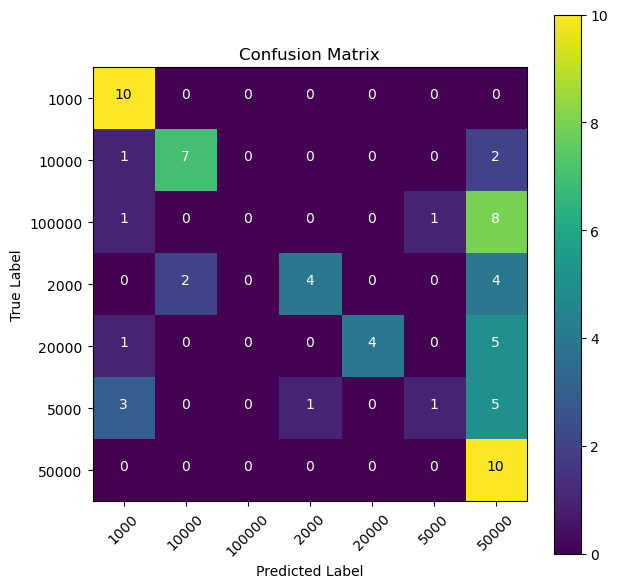

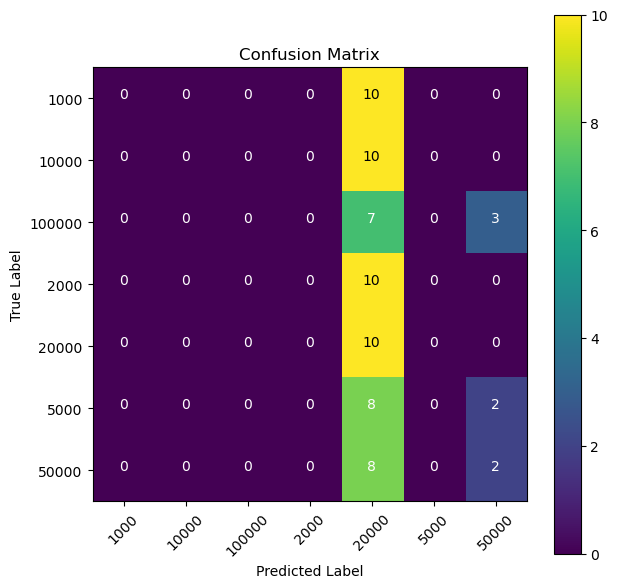

In [23]:
#start: 12 Juni 12:36 AM
j = 190
for i in range (j,len(parameter)):
#for i in range (0,10): #aslinya in range len(parameter) tapi kalau mau coba per sedikit2 ya gini deh
  vgg_epoch = (parameter[i][0])
  learning_rate = (parameter[i][1])
  batch_size = (parameter[i][2])
  dropout_rate = (parameter[i][3])
  i=i+1
  savePercobaan(i)
  print("Percobaan ke-",i,"↓")
  print("HYPERPARAMETER".center(100,"─"))
  print("vgg epoch:",vgg_epoch)
  print("learning rate:",learning_rate)
  print("batch size:",batch_size)
  print("dropout rate:",dropout_rate)
  print("".center(100,"─"))
  vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate)
  new_row = {'Epoch': vgg_epoch, 'Learning Rate': learning_rate, 'Batch Size': batch_size, 'Dropout Rate': dropout_rate, 'Accuracy': arr_accuracy16[-1]}
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)
  hasilTabel.index = hasilTabel.index + (j+1)
  hasilTabel.to_excel("hasilTabel.xlsx")
  print("".center(100,"─"))

In [ ]:
result = pd.read_excel("hasilTabel.xlsx")
print(result)

   Percobaan  Epoch  Learning Rate  Batch Size  Dropout Rate  Accuracy
0          1     34       0.013475          32      0.533236  0.300000
1          2     38       0.008827          32      0.624940  0.571429
2          3     35       0.012391          32      0.704752  0.171429
3          4     32       0.001534          32      0.769208  0.571429
4          5     35       0.023369          64      0.516714  0.142857


#### **<font color='Pink'>Testing</font>**

In [14]:
inv_map_classes = {0: '1000', 1: '10000', 2: '100000', 3: '2000', 4: '20000', 5: '5000', 6: '50000'}

1/1 [==============================] - 0s 105ms/step
Prediksi: 100000 | Probabilitas: 0.975997


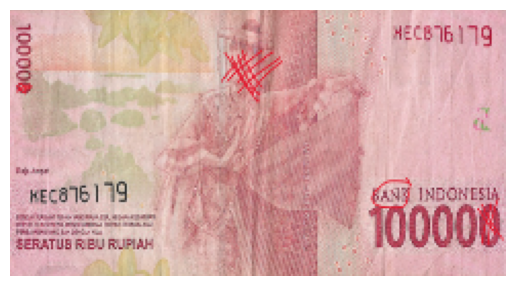

In [28]:
from tensorflow.keras.models import load_model

path = r"D:\UNAIR\Semester_8\Skripsi\deteksi_nominal_vending_machine\datasetUang/100000/100k_b_2016_15.png"
img = cv2.resize(cv2.imread(path),(242,130))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#img = cv2.imread(path)
img_normalized = img/255

model = load_model("percobaan148_noImgPro/vgg16-model148.h5")

vgg16_image_prediction = np.argmax(model.predict(np.array([img_normalized])))
prob = np.amax(model.predict(np.array([img_normalized])))
plt.imshow(img)
plt.axis("off")
print("Prediksi:",inv_map_classes[vgg16_image_prediction],"| Probabilitas:",prob)

#Revisi

In [48]:
import splitfolders
dataset="datasetAbu"
for i in range(0,5):
    seed = random.randint(0,1500)
    print(seed)
    i=i+1
    splitfolders.ratio(dataset, output="datasetSplit"+str(i), seed=seed, ratio=(0.7, 0.2, 0.1)) #70% : 10% : 20%

1392


Copying files: 700 files [00:06, 101.92 files/s]


172


Copying files: 700 files [00:01, 541.42 files/s]


198


Copying files: 700 files [00:01, 559.61 files/s]


751


Copying files: 700 files [00:01, 657.31 files/s]


1401


Copying files: 700 files [00:01, 611.13 files/s]


Found 490 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Percobaan ke- 1 ↓
───────────────────────────────────────HYPERPARAMETER VGG-16────────────────────────────────────────
vgg epoch: 48
learning rate: 0.001789042
batch size: 64
dropout rate: 0.617462768
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/48
8/8 [==============================] - ETA: 0s - loss: 2.6178 - acc: 0.2837
Epoch 1: val_acc improved from -inf to 0.29286, saving model to percobaan1_noImgPro/model\vgg_16_1-saved-model-01-acc-0.29.hdf5
8/8 [==============================] - 38s 5s/step - loss: 2.6178 - acc: 0.2837 - val_loss: 2.0056 - val_acc: 0.2929
Epoch 2/48
8/8 [==============================] - ETA: 0s - loss: 1.4761 - acc: 0.5224
Epoch 2: val_acc did not improve from 0.29286
8/8 [==============================] - 33s 4s/step - loss: 1.4761 - acc: 0.5224 - val_loss: 1.9059 - val_acc: 0

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\1083539539.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


────────────────────────────────────────────────────────────────────────────────────────────────────
Found 490 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Percobaan ke- 2 ↓
───────────────────────────────────────HYPERPARAMETER VGG-16────────────────────────────────────────
vgg epoch: 48
learning rate: 0.001789042
batch size: 64
dropout rate: 0.617462768
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/48
8/8 [==============================] - ETA: 0s - loss: 2.8154 - acc: 0.2265
Epoch 1: val_acc improved from -inf to 0.32857, saving model to percobaan2_noImgPro/model\vgg_16_2-saved-model-01-acc-0.33.hdf5
8/8 [==============================] - 42s 5s/step - loss: 2.8154 - acc: 0.2265 - val_loss: 2.1719 - val_acc: 0.3286
Epoch 2/48
8/8 [==============================] - ETA: 0s - loss: 1.4989 - acc: 0.5286
Epoch 2: val_acc improved from 0.32857 to 0.37143, savin

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\1083539539.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Percobaan ke- 3 ↓
───────────────────────────────────────HYPERPARAMETER VGG-16────────────────────────────────────────
vgg epoch: 48
learning rate: 0.001789042
batch size: 64
dropout rate: 0.617462768
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/48
8/8 [==============================] - ETA: 0s - loss: 2.6044 - acc: 0.2653
Epoch 1: val_acc improved from -inf to 0.35000, saving model to percobaan3_noImgPro/model\vgg_16_3-saved-model-01-acc-0.35.hdf5
8/8 [==============================] - 42s 5s/step - loss: 2.6044 - acc: 0.2653 - val_loss: 1.9698 - val_acc: 0.3500
Epoch 2/48
8/8 [==============================] - ETA: 0s - loss: 1.4322 - acc: 0.5265
Epoch 2: val_acc improved from 0.35000 to 0.47143, saving model to percobaan3_noImgPro/model\vgg_16_3-saved-model-02-acc-0.47.hdf5
8/8 [==============================] - 39s 5s/step - loss: 1.4322 - acc: 0.5265 - val_loss: 1.7580 - val_acc: 0.4714
Epoch 3/48
8/8 [===============

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\1083539539.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/48
8/8 [==============================] - ETA: 0s - loss: 2.8436 - acc: 0.2184
Epoch 1: val_acc improved from -inf to 0.18571, saving model to percobaan4_noImgPro/model\vgg_16_4-saved-model-01-acc-0.19.hdf5
8/8 [==============================] - 42s 5s/step - loss: 2.8436 - acc: 0.2184 - val_loss: 1.8745 - val_acc: 0.1857
Epoch 2/48
8/8 [==============================] - ETA: 0s - loss: 1.6348 - acc: 0.4837
Epoch 2: val_acc improved from 0.18571 to 0.25714, saving model to percobaan4_noImgPro/model\vgg_16_4-saved-model-02-acc-0.26.hdf5
8/8 [==============================] - 39s 5s/step - loss: 1.6348 - acc: 0.4837 - val_loss: 1.7520 - val_acc: 0.2571
Epoch 3/48
8/8 [==============================] - ETA: 0s - loss: 1.0781 - acc: 0.6388
Epoch 3: val_acc improved from 0.25714 to 0.35000, saving model to percobaan4_noImgPro/model\vgg_16_4-saved-model-03-acc-0.35.hdf5
8/8 [==============================] - 43s 6s/step - loss: 1.0781 - acc: 0.6388 - val_loss: 1.6647 - val_acc: 0.350

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\1083539539.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Epoch 1/48
8/8 [==============================] - ETA: 0s - loss: 2.8126 - acc: 0.2510
Epoch 1: val_acc improved from -inf to 0.20714, saving model to percobaan5_noImgPro/model\vgg_16_5-saved-model-01-acc-0.21.hdf5
8/8 [==============================] - 40s 5s/step - loss: 2.8126 - acc: 0.2510 - val_loss: 2.1026 - val_acc: 0.2071
Epoch 2/48
8/8 [==============================] - ETA: 0s - loss: 1.5578 - acc: 0.4755
Epoch 2: val_acc improved from 0.20714 to 0.24286, saving model to percobaan5_noImgPro/model\vgg_16_5-saved-model-02-acc-0.24.hdf5
8/8 [==============================] - 39s 5s/step - loss: 1.5578 - acc: 0.4755 - val_loss: 1.9412 - val_acc: 0.2429
Epoch 3/48
8/8 [==============================] - ETA: 0s - loss: 1.0075 - acc: 0.6367
Epoch 3: val_acc improved from 0.24286 to 0.27143, saving model to percobaan5_noImgPro/model\vgg_16_5-saved-model-03-acc-0.27.hdf5
8/8 [==============================] - 45s 6s/step - loss: 1.0075 - acc: 0.6367 - val_loss: 1.7806 - val_acc: 0.271

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\1083539539.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


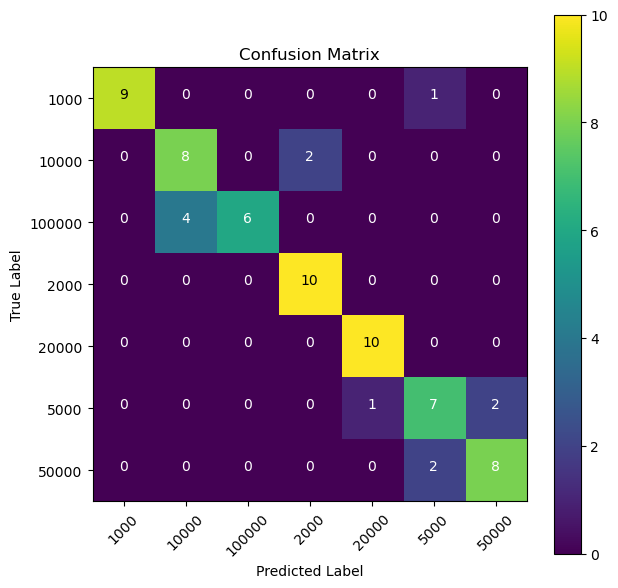

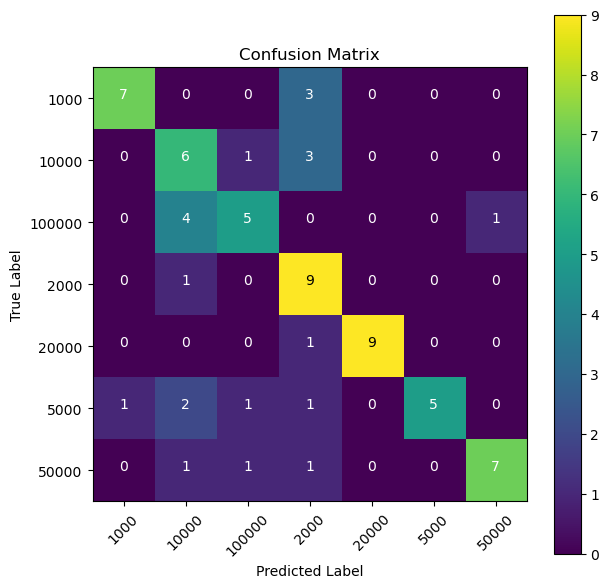

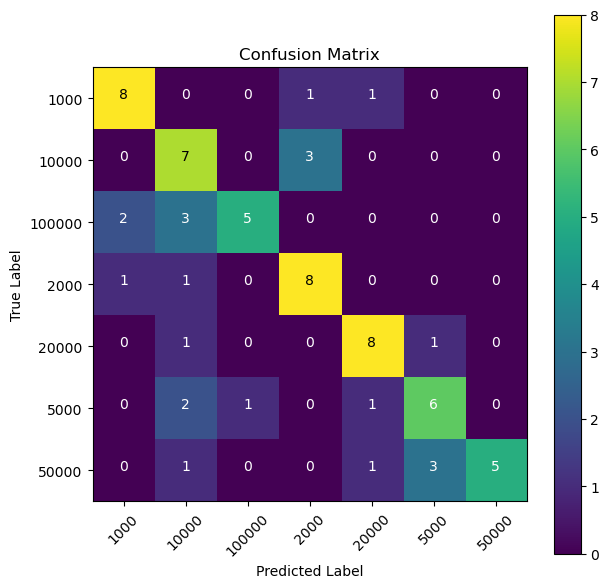

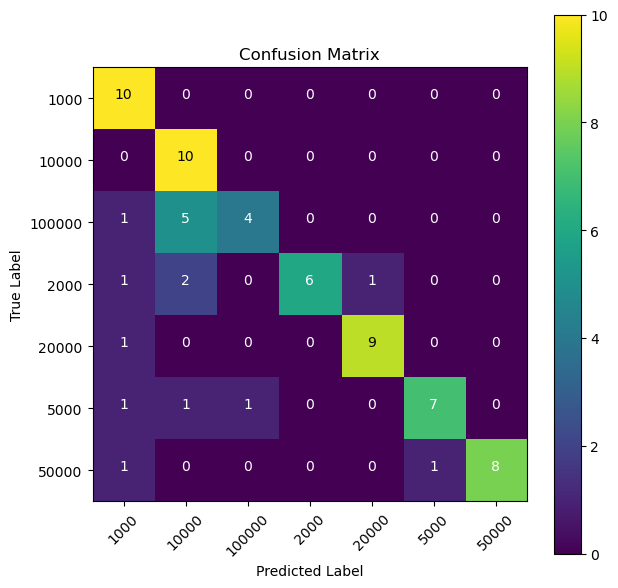

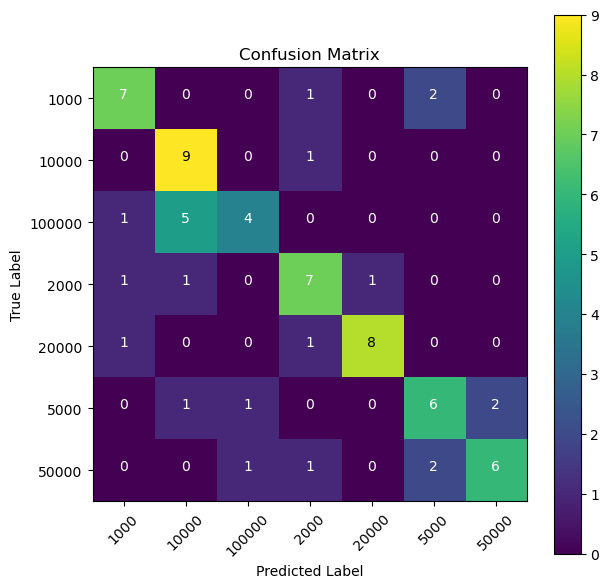

In [22]:
for i in range (0,5):
#for i in range (0,10): #aslinya in range len(parameter) tapi kalau mau coba per sedikit2 ya gini deh
  vgg_epoch = 48
  learning_rate = 0.001789042
  batch_size = 64
  dropout_rate = 0.617462768
  i=i+1
  dataset = "datasetSplit"+str(i)
  IMAGE_SIZE = (130, 242, 3)
  train_pred_test_folders = os.listdir(dataset)
  train_path = dataset+'/train'
  test_path = dataset+'/test'
  val_path = dataset+'/val'

  #normalisasi
  train_datagen = ImageDataGenerator(rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
  train_generator16 = train_datagen.flow_from_directory(train_path,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(130, 242))

  validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

  test_datagen = ImageDataGenerator(rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
  test_generator16 = test_datagen.flow_from_directory(test_path, target_size=(130, 242),
      batch_size=1,
      shuffle=True,
      class_mode='categorical')

  validation_generator16 = validation_datagen.flow_from_directory(val_path, shuffle=True, batch_size=1, class_mode='categorical', target_size=(130, 242))

  savePercobaan(i)
  print("Percobaan ke-",i,"↓")
  print("HYPERPARAMETER VGG-16".center(100,"─"))
  print("vgg epoch:",vgg_epoch)
  print("learning rate:",learning_rate)
  print("batch size:",batch_size)
  print("dropout rate:",dropout_rate)
  print("".center(100,"─"))
  vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate)
  new_row = {'Epoch': vgg_epoch, 'Learning Rate': learning_rate, 'Batch Size': batch_size, 'Dropout Rate': dropout_rate, 'Accuracy': arr_accuracy16[-1]}
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)
  hasilTabel.index = hasilTabel.index + (i+1)
  hasilTabel.to_excel("hasilTabelRevisi.xlsx")
  print("".center(100,"─"))

Found 490 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Percobaan ke- 1 ↓
───────────────────────────────────────HYPERPARAMETER VGG-16────────────────────────────────────────
vgg epoch: 45
learning rate: 0.00433602899725914
batch size: 32
dropout rate: 0.638916709600142
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/45
16/16 [==============================] - ETA: 0s - loss: 2.8249 - acc: 0.2551
Epoch 1: val_acc improved from -inf to 0.30000, saving model to percobaan1_noImgPro/model\vgg_16_1-saved-model-01-acc-0.30.hdf5
16/16 [==============================] - 60s 4s/step - loss: 2.8249 - acc: 0.2551 - val_loss: 2.1478 - val_acc: 0.3000
Epoch 2/45
16/16 [==============================] - ETA: 0s - loss: 1.5919 - acc: 0.4776
Epoch 2: val_acc improved from 0.30000 to 0.41429, saving model to percobaan1_noImgPro/model\vgg_16_1-saved-model-02-acc-0.41.hdf5
16/16 

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\777585943.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


────────────────────────────────────────────────────────────────────────────────────────────────────
Found 490 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Percobaan ke- 2 ↓
───────────────────────────────────────HYPERPARAMETER VGG-16────────────────────────────────────────
vgg epoch: 45
learning rate: 0.00433602899725914
batch size: 32
dropout rate: 0.638916709600142
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/45
16/16 [==============================] - ETA: 0s - loss: 2.6523 - acc: 0.2755
Epoch 1: val_acc improved from -inf to 0.31429, saving model to percobaan2_noImgPro/model\vgg_16_2-saved-model-01-acc-0.31.hdf5
16/16 [==============================] - 174s 11s/step - loss: 2.6523 - acc: 0.2755 - val_loss: 1.9749 - val_acc: 0.3143
Epoch 2/45
16/16 [==============================] - ETA: 0s - loss: 1.4835 - acc: 0.4796
Epoch 2: val_acc did not improve f

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\777585943.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


────────────────────────────────────────────────────────────────────────────────────────────────────
Found 490 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Percobaan ke- 3 ↓
───────────────────────────────────────HYPERPARAMETER VGG-16────────────────────────────────────────
vgg epoch: 45
learning rate: 0.00433602899725914
batch size: 32
dropout rate: 0.638916709600142
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/45
16/16 [==============================] - ETA: 0s - loss: 2.6156 - acc: 0.2980
Epoch 1: val_acc improved from -inf to 0.15000, saving model to percobaan3_noImgPro/model\vgg_16_3-saved-model-01-acc-0.15.hdf5
16/16 [==============================] - 116s 7s/step - loss: 2.6156 - acc: 0.2980 - val_loss: 2.7004 - val_acc: 0.1500
Epoch 2/45
16/16 [==============================] - ETA: 0s - loss: 1.4781 - acc: 0.5102
Epoch 2: val_acc improved from 0.15

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\777585943.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Found 490 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Percobaan ke- 4 ↓
───────────────────────────────────────HYPERPARAMETER VGG-16────────────────────────────────────────
vgg epoch: 45
learning rate: 0.00433602899725914
batch size: 32
dropout rate: 0.638916709600142
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/45
16/16 [==============================] - ETA: 0s - loss: 2.6608 - acc: 0.2918
Epoch 1: val_acc improved from -inf to 0.17857, saving model to percobaan4_noImgPro/model\vgg_16_4-saved-model-01-acc-0.18.hdf5
16/16 [==============================] - 88s 5s/step - loss: 2.6608 - acc: 0.2918 - val_loss: 2.0798 - val_acc: 0.1786
Epoch 2/45
16/16 [==============================] - ETA: 0s - loss: 1.6306 - acc: 0.4816
Epoch 2: val_acc improved from 0.17857 to 0.26429, saving model to percobaan4_noImgPro/model\vgg_16_4-saved-model-02-acc-0.26.hdf5
16/16 

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\777585943.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


Found 490 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Percobaan ke- 5 ↓
───────────────────────────────────────HYPERPARAMETER VGG-16────────────────────────────────────────
vgg epoch: 45
learning rate: 0.00433602899725914
batch size: 32
dropout rate: 0.638916709600142
────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 1/45
16/16 [==============================] - ETA: 0s - loss: 2.6782 - acc: 0.2857
Epoch 1: val_acc improved from -inf to 0.30714, saving model to percobaan5_noImgPro/model\vgg_16_5-saved-model-01-acc-0.31.hdf5
16/16 [==============================] - 87s 5s/step - loss: 2.6782 - acc: 0.2857 - val_loss: 2.3737 - val_acc: 0.3071
Epoch 2/45
16/16 [==============================] - ETA: 0s - loss: 1.6128 - acc: 0.4735
Epoch 2: val_acc did not improve from 0.30714
16/16 [==============================] - 77s 4s/step - loss: 1.6128 - acc: 0.4735 - val_los

C:\Users\ardin\AppData\Local\Temp\ipykernel_19668\777585943.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)


────────────────────────────────────────────────────────────────────────────────────────────────────


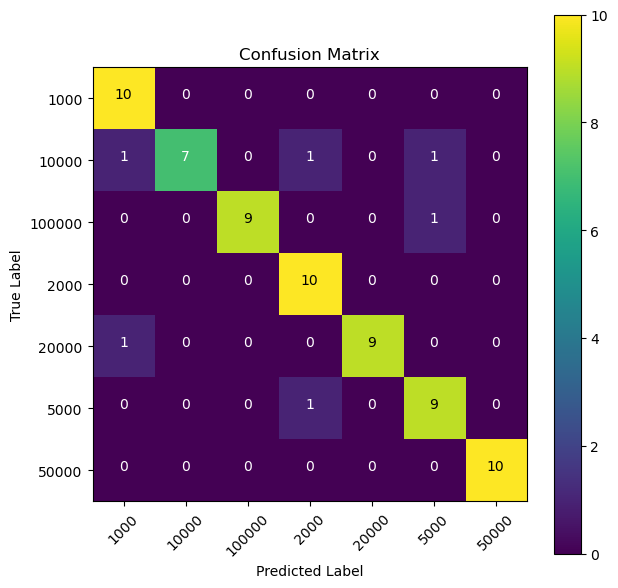

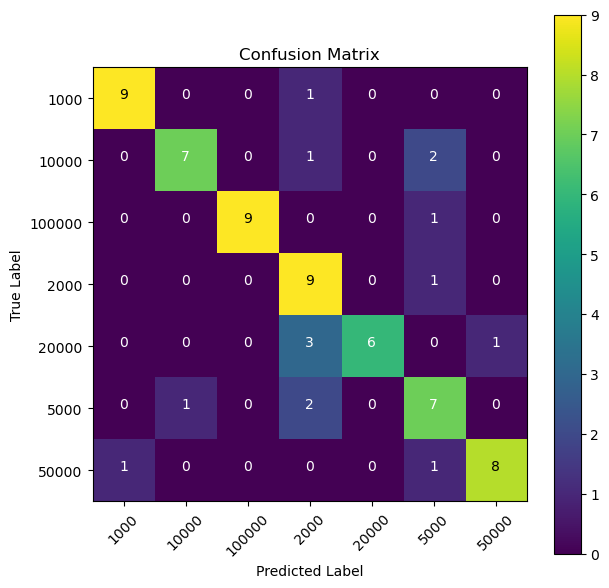

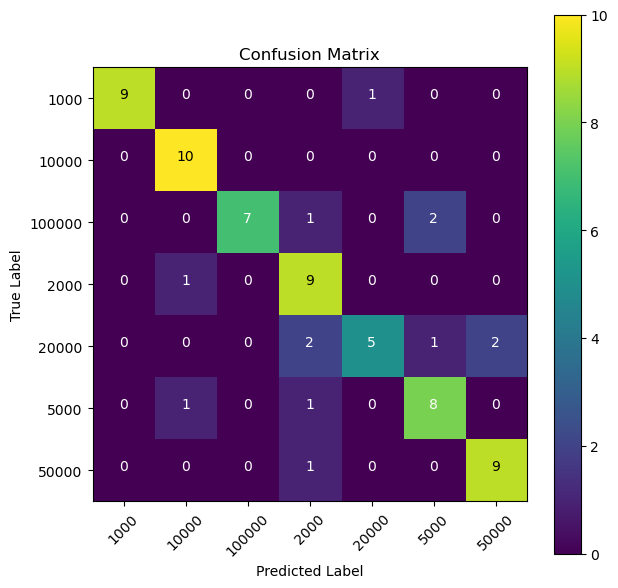

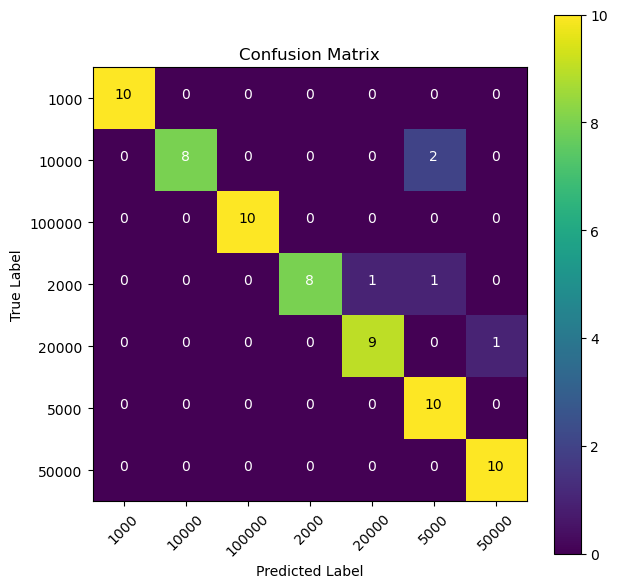

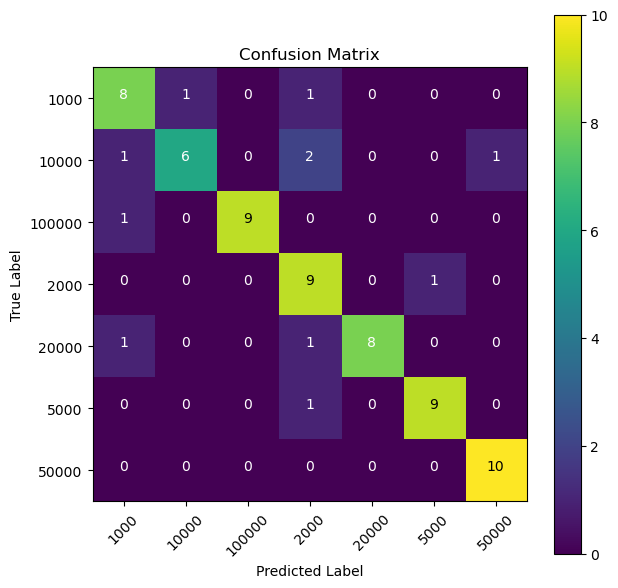

In [49]:
for i in range (0,5):
#for i in range (0,10): #aslinya in range len(parameter) tapi kalau mau coba per sedikit2 ya gini deh
  vgg_epoch = 45
  learning_rate = 0.00433602899725914
  batch_size = 32
  dropout_rate = 0.638916709600142
  i=i+1
  dataset = "datasetSplit"+str(i)
  IMAGE_SIZE = (130, 242, 3)
  train_pred_test_folders = os.listdir(dataset)
  train_path = dataset+'/train'
  test_path = dataset+'/test'
  val_path = dataset+'/val'

  #normalisasi
  train_datagen = ImageDataGenerator(rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
  train_generator16 = train_datagen.flow_from_directory(train_path,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(130, 242))

  validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

  test_datagen = ImageDataGenerator(rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
  test_generator16 = test_datagen.flow_from_directory(test_path, target_size=(130, 242),
      batch_size=1,
      shuffle=True,
      class_mode='categorical')

  validation_generator16 = validation_datagen.flow_from_directory(val_path, shuffle=True, batch_size=1, class_mode='categorical', target_size=(130, 242))

  savePercobaan(i)
  print("Percobaan ke-",i,"↓")
  print("HYPERPARAMETER VGG-16".center(100,"─"))
  print("vgg epoch:",vgg_epoch)
  print("learning rate:",learning_rate)
  print("batch size:",batch_size)
  print("dropout rate:",dropout_rate)
  print("".center(100,"─"))
  vgg16_training(i, vgg_epoch, learning_rate, batch_size, dropout_rate)
  new_row = {'Epoch': vgg_epoch, 'Learning Rate': learning_rate, 'Batch Size': batch_size, 'Dropout Rate': dropout_rate, 'Accuracy': arr_accuracy16[-1]}
  hasilTabel = hasilTabel.append(new_row, ignore_index=True)
  hasilTabel.index = hasilTabel.index + (i+1)
  hasilTabel.to_excel("hasilTabelRevisi.xlsx")
  print("".center(100,"─"))

In [52]:
import splitfolders
dataset="datasetAbu"
seed = [946, 521, 811, 358, 333, 1471, 25, 955, 1492, 467]
for i in range(0,10):
    splitfolders.ratio(dataset, output="datasetSplit"+str(i+1), seed=seed[i], ratio=(0.7, 0.2, 0.1)) #70% : 10% : 20%
    i=i+1

Copying files: 700 files [00:01, 607.62 files/s]
Copying files: 700 files [00:01, 638.14 files/s]
Copying files: 700 files [00:01, 626.90 files/s]
Copying files: 700 files [00:01, 652.18 files/s]
Copying files: 700 files [00:00, 700.51 files/s]
Copying files: 700 files [00:00, 703.48 files/s]
Copying files: 700 files [00:01, 695.56 files/s]
Copying files: 700 files [00:01, 657.38 files/s]
Copying files: 700 files [00:01, 643.42 files/s]
Copying files: 700 files [00:00, 704.97 files/s]


In [ ]:
import splitfolders
dataset="datasetAbu"
seed = [946, 521, 811, 358, 333, 1471, 25, 955, 1492, 467, 300, 1221, 495, 782, 305, 302, 639, 740, 110, 125, 488, 728, 1444, 872, 819, 346, 1315, 855, 382, 1159, 1281, 537, 1354, 108, 377, 226, 170, 196, 1254, 951, 932, 737, 373, 1330, 562, 8, 546, 1111, 1037, 10]
for i in range(6,50):
    splitfolders.ratio(dataset, output="datasetSplit"+str(i+1), seed=seed[i], ratio=(0.7, 0.2, 0.1)) #70% : 10% : 20%
    i=i+1